# **Analisis Komparatif Augmentasi Data Online dan Offline terhadap Kinerja Arsitektur CNN (ResNet50, DenseNet121, EfficientNetB0) untuk Klasifikasi Kanker Kulit**

Nama Kelompok : Data Leakage Kok Masuk IEEE

Nomor Kelompok : Kelompok 5

Anggota Kelompok
1. Gaung Taqwa Indraswara
2. Muhammad Fakhri Aldiansyah



# **1. Introduction**

Kanker kulit merupakan salah satu jenis kanker dengan tingkat keganasan dan mortalitas yang tinggi jika tidak terdeteksi sejak dini. Diagnosis akurat pada tahap awal secara signifikan meningkatkan tingkat kelangsungan hidup pasien. Namun, proses diagnosis konvensional yang bergantung pada evaluasi visual oleh dokter kulit memiliki tantangan seperti subjektivitas dan kemiripan visual antara lesi jinak dan ganas.

Dalam beberapa tahun terakhir, *Deep Learning*, khususnya arsitektur *Convolutional Neural Network* (CNN), telah menunjukkan kemampuan luar biasa dalam analisis citra medis. Model-model canggih seperti ResNet50, DenseNet121, dan EfficientNetB0, yang dilatih pada dataset berskala besar, telah menjadi standar dalam tugas klasifikasi gambar.

Salah satu tantangan utama dalam melatih model ini adalah keterbatasan dan ketidakseimbangan data, seperti yang ditemukan pada dataset **HAM10000**. Untuk mengatasi ini, **augmentasi data**—teknik untuk menciptakan variasi data latih secara artifisial—menjadi strategi krusial. Proyek ini akan mengeksplorasi dua pendekatan augmentasi utama:
1.  **Augmentasi Offline**: Membuat dan menyimpan semua versi gambar yang telah diaugmentasi sebelum proses training.
2.  **Augmentasi Online**: Menerapkan transformasi augmentasi secara acak dan *real-time* selama proses training.

Selain itu, proyek ini juga menginvestigasi sebuah metodologi dari paper acuan oleh Mridha et al. (2023) yang berpotensi mengandung **data leakage**, di mana augmentasi dilakukan sebelum pemisahan data. Kami akan mereplikasi, memperbaiki, dan membandingkan metodologi tersebut untuk mendapatkan hasil yang lebih valid secara ilmiah.

# **2. Objective**

Penelitian ini bertujuan untuk:
1.  Menganalisis dan membandingkan kinerja arsitektur *transfer learning* (ResNet50, DenseNet121, EfficientNetB0) dengan model CNN kustom untuk tugas klasifikasi tujuh jenis kanker kulit pada dataset HAM10000.
2.  Mengevaluasi dampak dari dua strategi augmentasi data—**online** dan **offline**—terhadap akurasi dan metrik evaluasi lainnya pada setiap arsitektur.
3.  Mengidentifikasi dan memvalidasi adanya isu **data leakage** pada metodologi paper acuan, serta menunjukkan dampaknya terhadap hasil evaluasi model.
4.  Menentukan kombinasi arsitektur dan teknik augmentasi data yang paling optimal untuk menghasilkan model diagnosis kanker kulit yang akurat dan dapat diandalkan.

# **3. Import Library**

In [2]:
# komponen inti PyTorch buat ngebangun dan ngelatih neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# buat baca data tabular
import pandas as pd

# buat baca sistem file/mengenali path (gambar, csv dan)
import os
import shutil

# buat buka/baca gambar
from PIL import Image
import cv2

# buat import model2 pretrained, dataset terkenal, sama buat transform juga
from torchvision import datasets, transforms, models

# ini buat data loader dan class dataset
from torch.utils.data import DataLoader, Dataset

# buat train test split
from sklearn.model_selection import train_test_split

# buat confusion matrix sama classification report
from sklearn.metrics import confusion_matrix, classification_report

# buat random seed
import random

# buat olah matrix
import numpy as np

# buat progress bar
from tqdm import tqdm

# buat plot grafik
import matplotlib.pyplot as plt
import seaborn as sns

# buat copy object di py
import copy

# buat download dataset dr kaggle
import kagglehub

# **4. Set Seed**

Menetapkan seed untuk semua library yang melibatkan proses acak (seperti random, numpy, dan torch) ke nilai yang sama, yaitu 2025. Tujuannya adalah untuk memastikan reproducibility, sehingga setiap kali kami menjalankan notebook, hasil yang melibatkan keacakan (seperti pembagian data atau inisialisasi bobot) akan selalu konsisten dan dapat dibandingkan secara adil.

In [3]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 2025
set_seed(SEED)

# **5. Load Dataset**

Mengunduh dataset HAM10000 menggunakan kagglehub dan mendefinisikan beberapa variabel konfigurasi global. Kami secara otomatis mengatur device untuk menggunakan GPU (cuda:0) jika tersedia agar proses training lebih cepat. Kami juga menetapkan batch_size dan class_names untuk digunakan di seluruh notebook.

In [4]:
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


In [5]:
# Konfigurasi Global
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

data_dir = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print(f"Path to dataset files: {data_dir}")

batch_size = 64
class_names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

Menggunakan device: cuda:0
Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


# **6. EDA**

Berikut adalah 7 pertanyaan kunci yang akan kita jawab melalui analisis data eksplorasi (EDA) yang lebih lengkap, dan beberapa terinspirasi dari analisis pada paper acuan:

1. Bagaimana contoh gambar di setiap kelas lesi?

2. Bagaimana persebaran kelas lesi yang akan diklasifikasikan

3. Bagaimana demografi dasar pasien? (Mencakup distribusi data berdasarkan jenis kelamin dan sebaran usia).

4. Di bagian tubuh mana lesi paling sering ditemukan? (Menganalisis frekuensi lokasi lesi).

5. Apakah ada hubungan antara jenis kelamin dan tipe lesi kulit? (Memeriksa apakah tipe lesi tertentu lebih umum pada pria atau wanita).

6. Bagaimana distribusi usia untuk setiap jenis lesi? (Melihat apakah ada tipe lesi yang cenderung muncul pada kelompok usia tertentu).

5. Untuk kasus Melanoma, adakah pola antara lokasi lesi dan usia pasien? (Fokus pada kelas paling berbahaya untuk menemukan korelasi spesifik).

## **6.0. Load Metadata**

In [6]:
metadata_eda = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))

## **6.1. Contoh Gambar Tiap Kelas**

Menampilkan 5 sampel gambar secara acak dari masing-masing 7 kelas dalam sebuah grid. Kami juga menambahkan label kelas dan lokasi di atas setiap gambar untuk memberikan konteks visual.

5 Contoh Gambar untuk Setiap Kelas Lesi


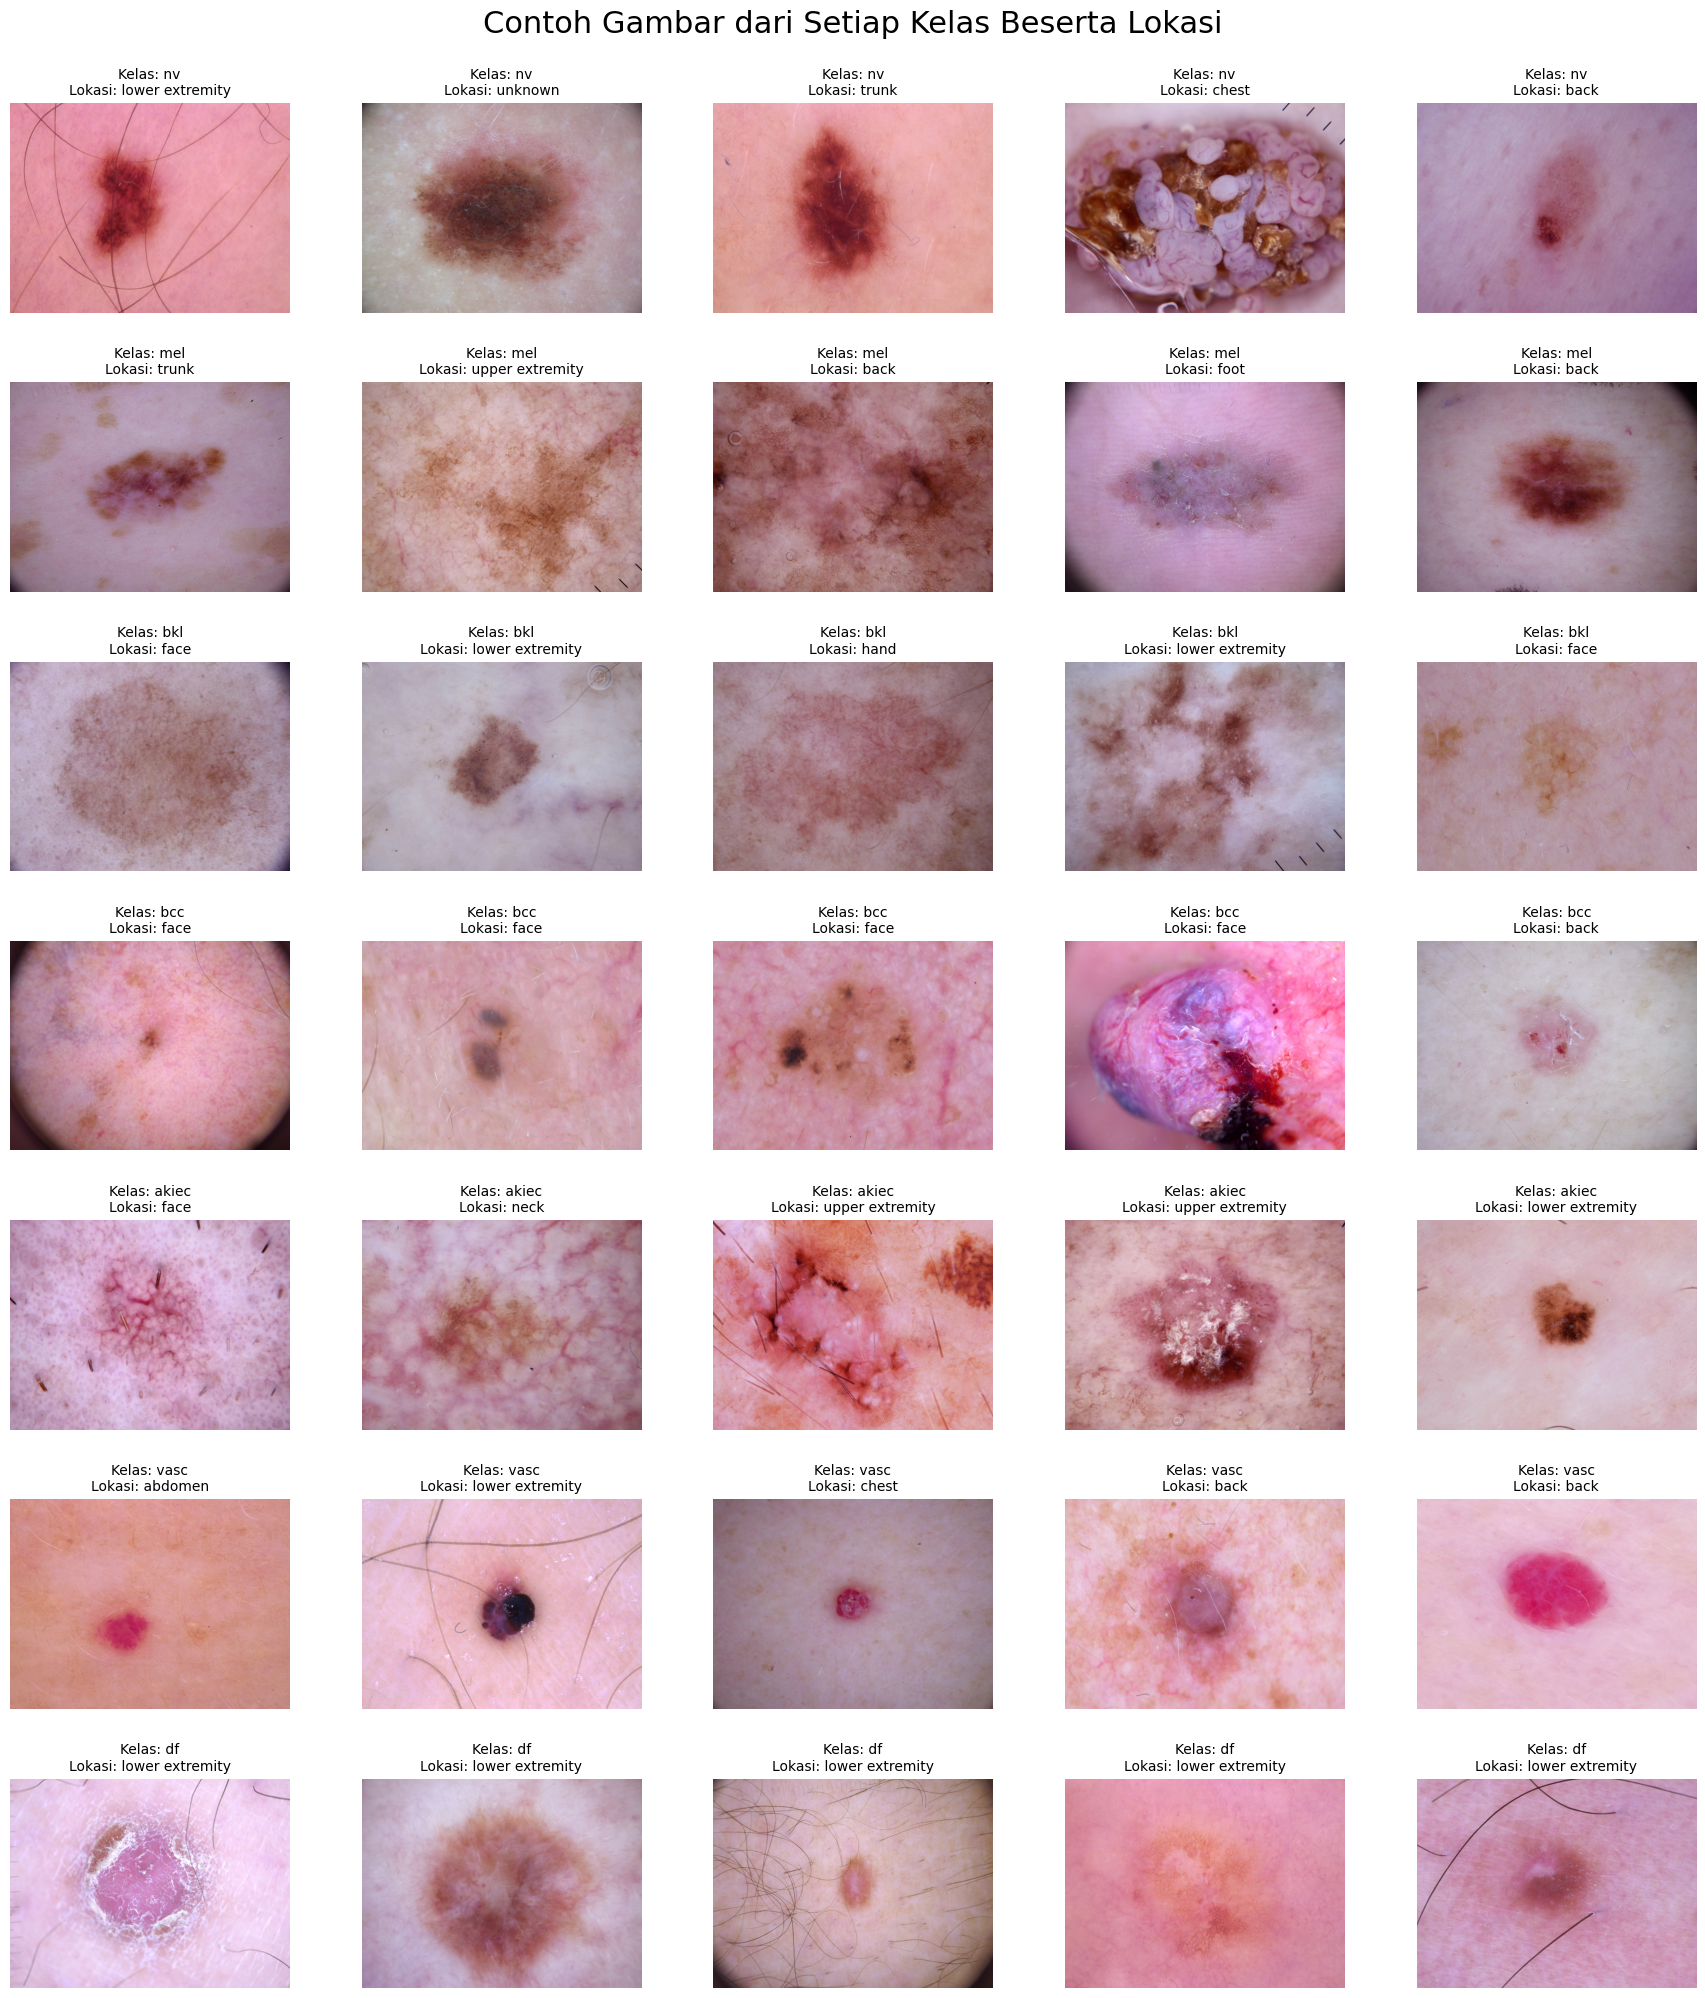

In [7]:
print("5 Contoh Gambar untuk Setiap Kelas Lesi")

fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(18, 20))

for i, class_name in enumerate(class_names):
    class_df = metadata_eda[metadata_eda['dx'] == class_name]
    sample_images = class_df.sample(5, random_state=SEED)

    axes[i, 0].set_ylabel(class_name.upper(), fontsize=16, rotation=0, labelpad=40, ha='right', weight='bold')

    for j, (_, row) in enumerate(sample_images.iterrows()):
        image_id = row['image_id']
        localization = row['localization']
        dx_class = row['dx']

        path1 = os.path.join(data_dir, 'HAM10000_images_part_1', f'{image_id}.jpg')
        path2 = os.path.join(data_dir, 'HAM10000_images_part_2', f'{image_id}.jpg')

        img_path = path1 if os.path.exists(path1) else path2

        ax = axes[i, j]

        try:
            image = Image.open(img_path)
            ax.imshow(image)
        except FileNotFoundError:
            print(f"File tidak ditemukan: {img_path}")

        title_text = f"Kelas: {dx_class}\nLokasi: {localization}"
        ax.set_title(title_text, fontsize=10)
        ax.axis('off')

plt.tight_layout(pad=3.0)
plt.suptitle('Contoh Gambar dari Setiap Kelas Beserta Lokasi', fontsize=22, y=1.01)
plt.show()

Grid gambar yang dihasilkan memungkinkan kami untuk melihat secara langsung dan membandingkan variasi visual dan kemiripan antar kelas lesi kulit secara kasat mata.

## **6.2. Persebaran Kelas**

Membuat diagram batang untuk memvisualisasikan jumlah gambar untuk setiap kelas penyakit.

Distribusi Kelas


/tmp/ipython-input-3478311912.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=metadata_eda, x='dx', order=class_names, palette='viridis')


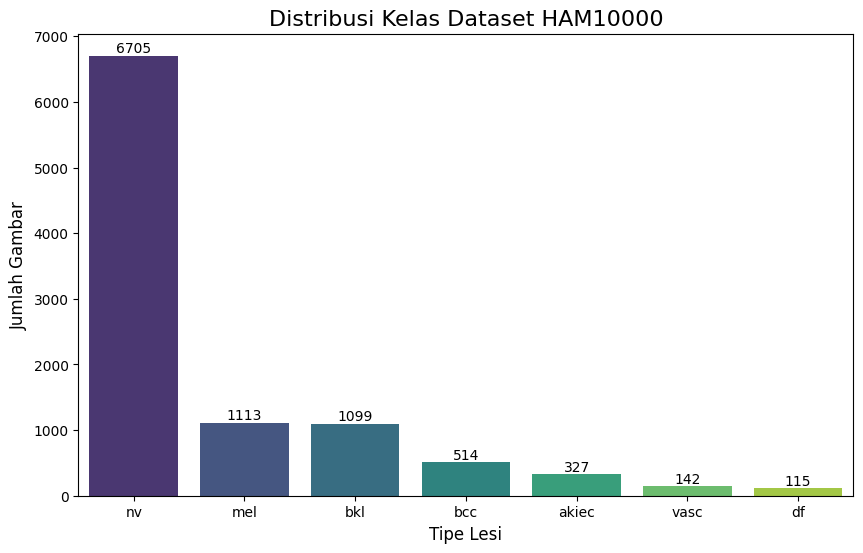

In [8]:
print("Distribusi Kelas")

metadata_eda = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))

# plot distribusi kelas
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=metadata_eda, x='dx', order=class_names, palette='viridis')

plt.title('Distribusi Kelas Dataset HAM10000', fontsize=16)
plt.xlabel('Tipe Lesi', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

Grafik ini dengan jelas menunjukkan bahwa dataset sangat tidak seimbang. Kelas nv (tahi lalat) sangat mendominasi. Temuan ini sangat krusial untuk meyakinkan kami untuk harus menerapkan teknik penyeimbangan data seperti augmentasi agar model kami tidak bias.

## **6.3. Demografi Pasien**

### **6.3.1. Distribusi Gender**

Membuat diagram lingkaran (pie chart) untuk menunjukkan proporsi jenis kelamin pasien.

In [9]:
print("Analisis Demografi Pasien (Jenis Kelamin)")

gender_counts = metadata_eda['sex'].value_counts()
gender_labels = gender_counts.index
colors = sns.color_palette('mako', len(gender_labels))

def func(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

plt.figure(figsize=(10, 7))
ax1 = plt.gca()

wedges, texts, autotexts = ax1.pie(gender_counts,
                                   autopct=lambda pct: func(pct, gender_counts),
                                   startangle=90,
                                   colors=colors,
                                   textprops=dict(color="w"))

ax1.legend(wedges, gender_labels,
           title="Jenis Gender",
           loc="upper right")

ax1.set_title('Distribusi Pasien Berdasarkan Jenis Kelamin', fontsize=16)
plt.setp(autotexts, size=10, weight="bold")

plt.show()

Analisis Demografi Pasien (Jenis Kelamin)


Kami menemukan bahwa jumlah pasien pria (54.0%) sedikit lebih banyak daripada wanita (45.4%), dengan sebagian kecil datanya tidak diketahui.

### **6.3.2. Distribusi Usia**

Membuat histogram untuk membandingkan distribusi usia antara pasien pria dan wanita.



In [9]:
print("Analisis Demografi Pasien (Usia)")

plt.figure(figsize=(12, 6))

sns.histplot(data=metadata_eda, x='age', bins=20, hue='sex', multiple='dodge')

plt.title('Distribusi Usia Pasien Berdasarkan Jenis Kelamin', fontsize=16)
plt.xlabel('Usia', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)

plt.show()

Analisis Demografi Pasien (Usia)


Grafik menunjukkan bahwa puncak distribusi usia pasien berada di rentang 40 hingga 60 tahun untuk kedua jenis kelamin. Female cenderung mendominasi dari rentang 20-50, namun untuk umur 50+ male lebih banyak relatif dibandingkan dengan female di bin umur yang sama

### **6.3.3. Distribusi Usia Gender 'Unknown'**

Membuat histogram terpisah untuk menganalisis 57 kasus di mana jenis kelaminnya tidak tercatat dan kurang terlihat di grafik sebelumnya.

Analisis Demografi Pasien (Usia untuk Jenis Kelamin 'Unknown')


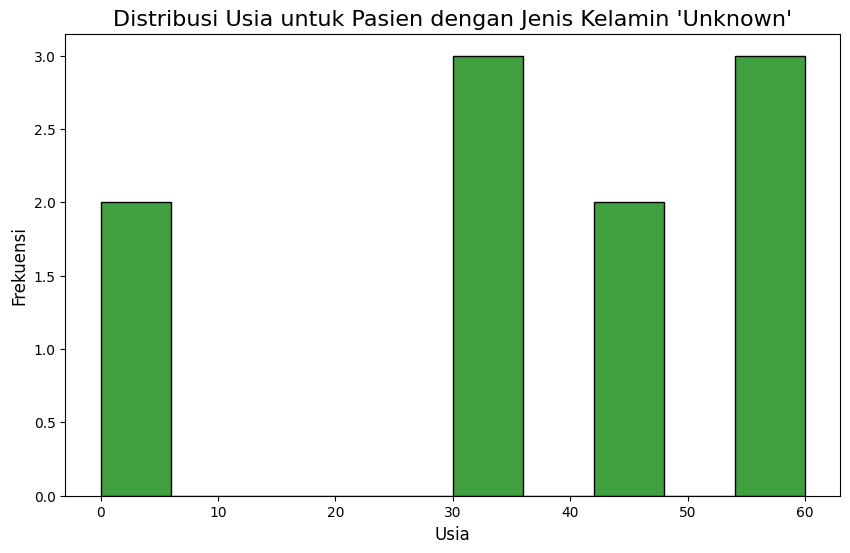

In [10]:
print("Analisis Demografi Pasien (Usia untuk Jenis Kelamin 'Unknown')")

unknown_gender_df = metadata_eda[metadata_eda['sex'] == 'unknown']

plt.figure(figsize=(10, 6))

sns.histplot(data=unknown_gender_df, x='age', bins=10, color='green')

plt.title("Distribusi Usia untuk Pasien dengan Jenis Kelamin 'Unknown'", fontsize=16)
plt.xlabel('Usia', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)

plt.show()

Kami menemukan bahwa sebagian besar dari kasus 'unknown' ini terkonsentrasi pada pasien berusia 30-60 tahun. Walaupun ada juga sebgain kecil di usia 0-5 tahun

## **6.4. Frekuensi Lokasi Lesi**

Membuat diagram batang horizontal yang diurutkan untuk menunjukkan di bagian tubuh mana lesi paling sering ditemukan.

Analisis Lokasi Kemunculan Lesi


/tmp/ipython-input-3694322267.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=metadata_eda, y='localization', order=metadata_eda['localization'].value_counts().index, palette='viridis')


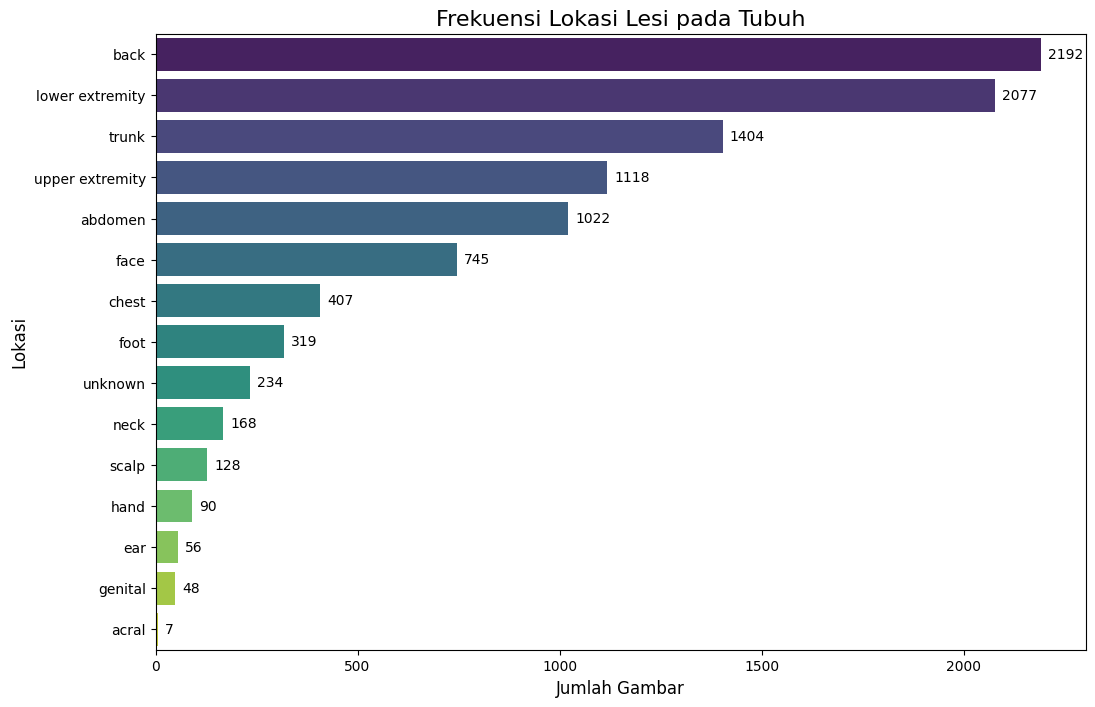

In [12]:
print("Analisis Lokasi Kemunculan Lesi")

plt.figure(figsize=(12, 8))
ax = sns.countplot(data=metadata_eda, y='localization', order=metadata_eda['localization'].value_counts().index, palette='viridis')

plt.title('Frekuensi Lokasi Lesi pada Tubuh', fontsize=16)
plt.xlabel('Jumlah Gambar', fontsize=12)
plt.ylabel('Lokasi', fontsize=12)

for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{int(width)}',
                (width, p.get_y() + p.get_height() / 2.),
                ha='left',
                va='center',
                xytext=(5, 0),
                textcoords='offset points')

plt.show()

Sama seperti di paper acuan, lokasi 'back' (punggung), 'lower extremity' (kaki bagian bawah), dan 'trunk' (batang tubuh) adalah tiga lokasi paling umum/banyak di dataset ini.

## **5. Distribusi Lesi Berdasarkan Jenis Kelamin**

Membuat dua plot: satu countplot untuk jumlah absolut dan satu barplot untuk persentase, guna melihat hubungan antara tipe lesi dan jenis kelamin.

Analisis Tipe Lesi Berdasarkan Jenis Kelamin


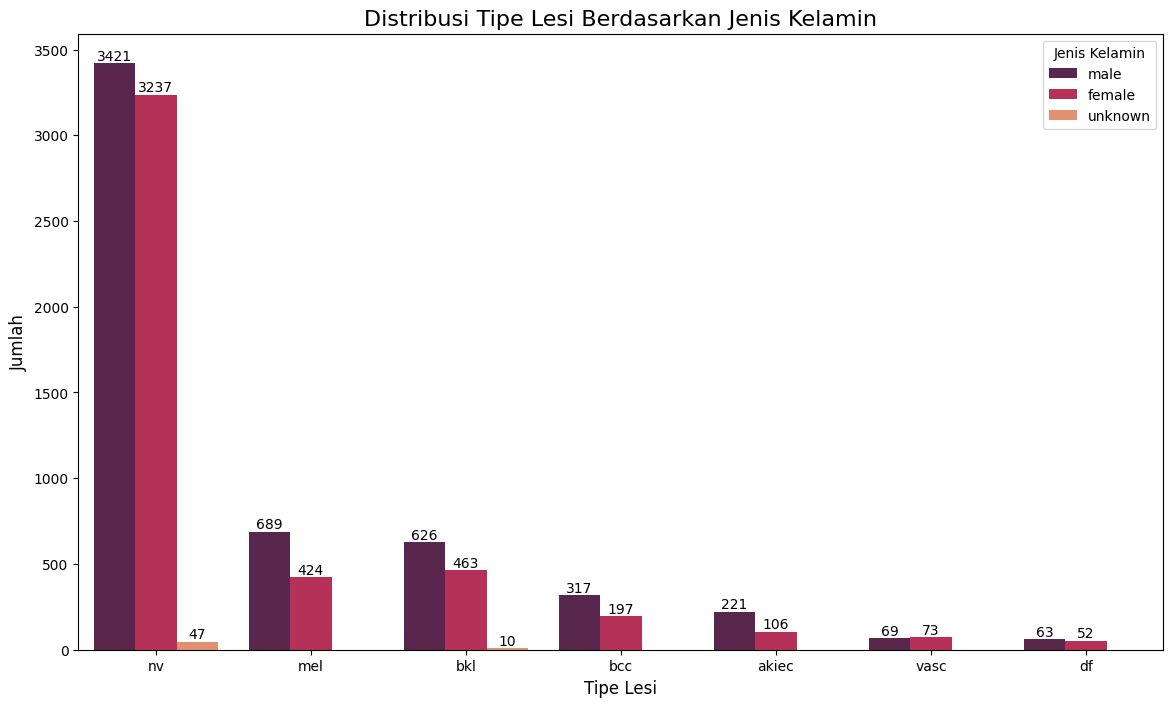

In [13]:
print("Analisis Tipe Lesi Berdasarkan Jenis Kelamin")

plt.figure(figsize=(14, 8))
ax = sns.countplot(data=metadata_eda, x='dx', hue='sex', order=class_names, palette='rocket')

plt.title('Distribusi Tipe Lesi Berdasarkan Jenis Kelamin', fontsize=16)
plt.xlabel('Tipe Lesi', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.legend(title='Jenis Kelamin')

for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(f'{height}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center',
                    va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

plt.show()

Barplot persentase untuk melihat lebih adil persebaran tiap kelas relatif terhadap jumlah kelas tersebut

Analisis Tipe Lesi Berdasarkan Jenis Kelamin (dalam Persentase)


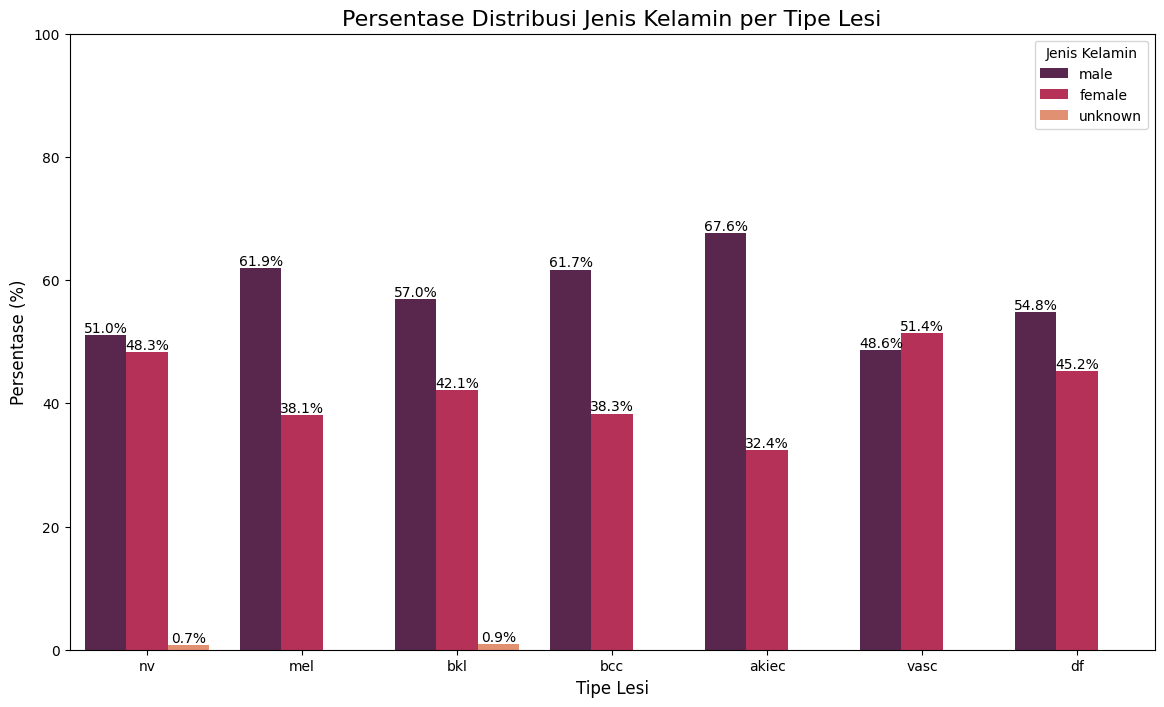

In [11]:
print("Analisis Tipe Lesi Berdasarkan Jenis Kelamin (dalam Persentase)")

df_percent = metadata_eda.groupby('dx')['sex'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()

plt.figure(figsize=(14, 8))
ax_percent = sns.barplot(data=df_percent, x='dx', y='percentage', hue='sex', order=class_names, palette='rocket')

plt.title('Persentase Distribusi Jenis Kelamin per Tipe Lesi', fontsize=16)
plt.xlabel('Tipe Lesi', fontsize=12)
plt.ylabel('Persentase (%)', fontsize=12)
plt.ylim(0, 100)
plt.legend(title='Jenis Kelamin')

for p in ax_percent.patches:
    height = p.get_height()
    if height > 0:
        txt = f'{height:.1f}%'
        ax_percent.annotate(txt,
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points')


plt.show()

jika dilihat dalam bentuk persentase, hampir semua kelas lebih banyak ber gender male, kecuali vasc yang sdikit lebih banyak female walaupun hanya berbeda 4 gambar lebih banyak jika dilihat dari plot diatasnya

## **6.6. Distribusi Lesi Berdasarkan Usia**

Menggunakan box plot untuk memvisualisasikan rentang usia pasien untuk setiap tipe lesi.

Analisis Distribusi Usia untuk Setiap Tipe Lesi


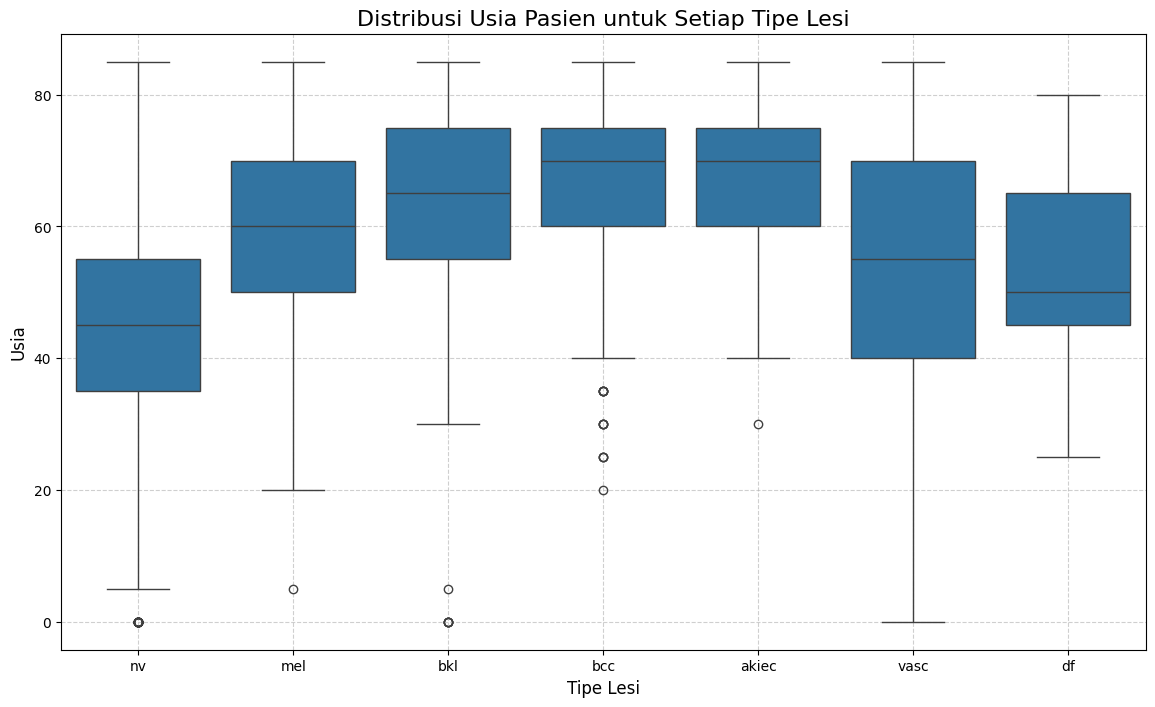

In [15]:
print("Analisis Distribusi Usia untuk Setiap Tipe Lesi")

plt.figure(figsize=(14, 8))
sns.boxplot(data=metadata_eda, x='dx', y='age', order=class_names)
plt.title('Distribusi Usia Pasien untuk Setiap Tipe Lesi', fontsize=16)
plt.xlabel('Tipe Lesi', fontsize=12)
plt.ylabel('Usia', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Kami menemukan pola yang jelas yaitu lesi ganas seperti bcc dan akiec cenderung muncul pada usia yang lebih tua (median di atas 60 tahun), berbeda dengan nv (tahi lalat) yang sebarannya lebih luas.

## **7. Analisis Hubungan Usia dan Lokasi untuk Kasus Melanoma**

Membuat heatmap yang secara spesifik memetakan frekuensi kasus Melanoma (mel) berdasarkan usia dan lokasi lesi sam seperti di paper. Kami menyembunyikan sel bernilai nol agar lebih mudah dibaca.

Analisis Hubungan Usia dan Lokasi Khusus untuk Melanoma


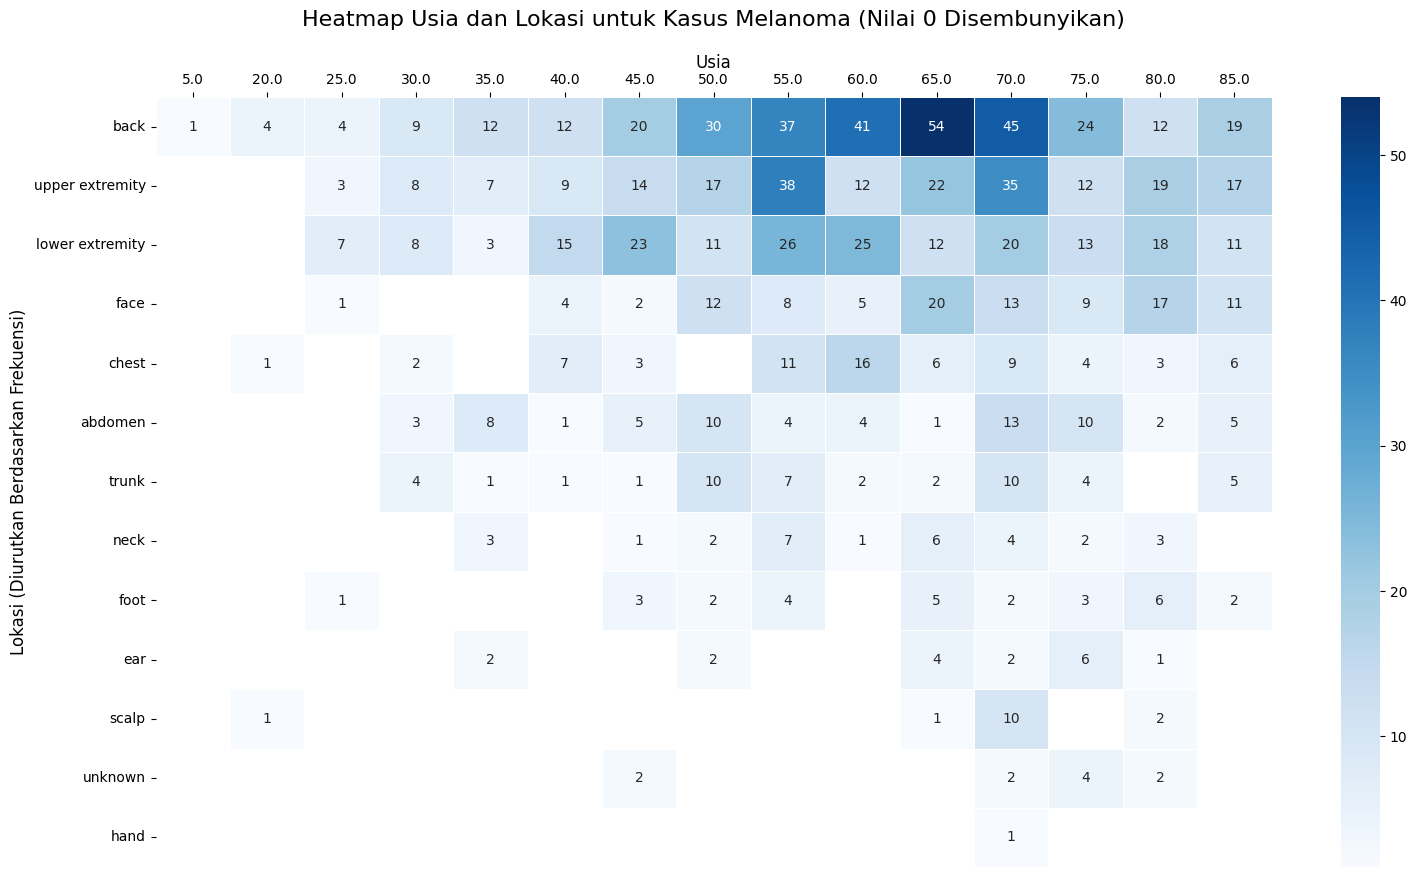

In [20]:
print("Analisis Hubungan Usia dan Lokasi Khusus untuk Melanoma")

melanoma_df = metadata_eda[metadata_eda['dx'] == 'mel']
sorted_locations = melanoma_df['localization'].value_counts().index
melanoma_pivot = melanoma_df.pivot_table(index='localization', columns='age', aggfunc='size', fill_value=0)
melanoma_pivot = melanoma_pivot.reindex(sorted_locations)
mask_zeros = melanoma_pivot == 0

# heatmap
plt.figure(figsize=(18, 10))
ax = sns.heatmap(melanoma_pivot,
                   annot=True,
                   fmt='d',
                   cmap='Blues',
                   linewidths=.5,
                   mask=mask_zeros)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.title('Heatmap Usia dan Lokasi untuk Kasus Melanoma (Nilai 0 Disembunyikan)', fontsize=16, pad=20)
plt.xlabel('Usia', fontsize=12)
plt.ylabel('Lokasi (Diurutkan Berdasarkan Frekuensi)', fontsize=12)
plt.show()

- **Konsentrasi Usia**: Kasus Melanoma paling banyak terkonsentrasi pada pasien berusia 45 hingga 80 tahun.

- **Lokasi Paling Umum**: Tiga lokasi paling umum adalah punggung (back), kaki bagian bawah (lower extremity), dan dada (chest).

# **7. Transform Image**

Mendefinisikan transformasi dasar yang akan kami terapkan pada setiap gambar. Prosesnya meliputi Resize ke 100x100 piksel, konversi ke ToTensor, dan Normalize menggunakan rata-rata dan standar deviasi dari ImageNet, yang merupakan praktik standar untuk transfer learning.

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_test_transforms = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# **8. Offline Augmentation**

Kami mendefinisikan fungsi perform_offline_augmentation untuk membuat dan menyimpan gambar baru hasil augmentasi. Fungsi ini akan menyeimbangkan kelas minoritas hingga mencapai jumlah target. Kami juga membuat kelas OfflineAugmentedDataset sebagai "jembatan" antara DataFrame dan DataLoader PyTorch, serta mendefinisikan transforms_to_apply yang berisi berbagai jenis transformasi yang akan kami gunakan.

In [ ]:
def perform_offline_augmentation(df, class_names, data_dir, augmented_data_dir, transforms_to_apply, target_count=5000):

    new_metadata_list = []

    for class_name in tqdm(class_names, desc="Augmenting Classes"):
        class_df = df[df['dx'] == class_name]
        existing_images_ids = list(class_df['image_id'])

        for img_id in existing_images_ids:
            original_path = os.path.join(data_dir, 'HAM10000_images_part_1', f"{img_id}.jpg")
            if not os.path.exists(original_path):
                 original_path = os.path.join(data_dir, 'HAM10000_images_part_2', f"{img_id}.jpg")

            new_path = os.path.join(augmented_data_dir, f"{img_id}.jpg")
            shutil.copy(original_path, new_path)
            new_metadata_list.append({
                'image_id': img_id, 'dx': class_name,
                'lesion_id': class_df[class_df['image_id'] == img_id].iloc[0]['lesion_id'],
                'path': new_path
            })

        if class_name != 'nv':
            generated_count = len(existing_images_ids)
            while generated_count < target_count:
                random_img_id = random.choice(existing_images_ids)

                original_path = os.path.join(data_dir, 'HAM10000_images_part_1', f"{random_img_id}.jpg")
                if not os.path.exists(original_path):
                    original_path = os.path.join(data_dir, 'HAM10000_images_part_2', f"{random_img_id}.jpg")

                original_image = Image.open(original_path)

                aug_name, transform = random.choice(list(transforms_to_apply.items()))
                augmented_image = transform(original_image)

                new_image_id = f"{random_img_id}_aug_{aug_name}_{random.randint(1000,9999)}"
                new_path = os.path.join(augmented_data_dir, f"{new_image_id}.jpg")
                augmented_image.save(new_path)

                new_metadata_list.append({
                    'image_id': new_image_id, 'dx': class_name,
                    'lesion_id': class_df[class_df['image_id'] == random_img_id].iloc[0]['lesion_id'],
                    'path': new_path
                })

                generated_count += 1

    return pd.DataFrame(new_metadata_list)

kelas OfflineAugementedDataset ini digunakan untuk sebagai pointer anatara gambar dan juga list gambar di df serta memberikannya beberapa meteadat aklainnya

In [ ]:
class OfflineAugmentedDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.lesion_type_dict = {'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
        self.df['label'] = self.df['dx'].map(self.lesion_type_dict)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.df.iloc[index]['path']
        label = self.df.iloc[index]['label']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

berikut adalah transformasi yang sesuai dengan paper

image.png

In [ ]:
transforms_to_apply = {
    'rotate_15': transforms.RandomRotation(degrees=(15, 15)), # Rotasi +15 derajat
    'rotate_neg_15': transforms.RandomRotation(degrees=(-15, -15)), # Rotasi -15 derajat
    'rotate_45': transforms.RandomRotation(degrees=(45, 45)), # Rotasi +45 derajat
    'rotate_neg_45': transforms.RandomRotation(degrees=(-45, -45)), # Rotasi -45 derajat
    'hflip': transforms.RandomHorizontalFlip(p=1.0),
    'colorjitter': transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1), # Representasi "noise addition"
}

# **9. Pembuatan Augementasi Offline Paper Method (Data Leakage Replication)**

Mereplikasi metodologi yang berpotensi salah dari paper acuan dengan menjalankan fungsi augmentasi pada seluruh dataset sebelum membaginya.

In [ ]:
metadata_full = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))

paper_augmented_dir = "/kaggle/working/paper_method_data"
if os.path.exists(paper_augmented_dir): shutil.rmtree(paper_augmented_dir)
os.makedirs(paper_augmented_dir, exist_ok=True)
print(f"Direktori untuk eksperimen replikasi paper dibuat di: {paper_augmented_dir}")

Direktori untuk eksperimen replikasi paper dibuat di: /kaggle/working/paper_method_data


mungkin tidak 100% menyamai jumlah di paper namun ini sudah lumayan mirip

In [ ]:
full_augmented_df = perform_offline_augmentation(
    df=metadata_full,
    class_names=class_names,
    data_dir=data_dir,
    augmented_data_dir=paper_augmented_dir,
    transforms_to_apply=transforms_to_apply,
    target_count=6700
)

print("\nDistribusi kelas setelah augmentasi metode paper:")
print(full_augmented_df['dx'].value_counts())

Augmenting Classes: 100%|██████████| 7/7 [07:22<00:00, 63.25s/it]


Distribusi kelas setelah augmentasi metode paper:
dx
nv       6705
mel      6700
bkl      6700
bcc      6700
akiec    6700
vasc     6700
df       6700
Name: count, dtype: int64


Output menunjukkan bahwa setelah proses ini, semua kelas memiliki jumlah gambar yang seimbang, sekitar 6700.

## **10. Split Data Setelah Augmentasi Offline (Sesuai Paper)**

Membagi dataset besar yang sudah "terkontaminasi" augmentasi menjadi set train, validation, dan test. Ini adalah langkah yang menyebabkan data leakage.

In [ ]:
train_df_paper, val_test_df_paper = train_test_split(full_augmented_df, test_size=0.30, random_state=SEED, stratify=full_augmented_df['dx'])
val_df_paper, test_df_paper = train_test_split(val_test_df_paper, test_size=0.50, random_state=SEED, stratify=val_test_df_paper['dx'])

In [ ]:
train_dataset_paper = OfflineAugmentedDataset(df=train_df_paper, transform=train_transforms)
val_dataset_paper = OfflineAugmentedDataset(df=val_df_paper, transform=val_test_transforms)
test_dataset_paper = OfflineAugmentedDataset(df=test_df_paper, transform=val_test_transforms)

batch_size = 64
train_loader_paper = DataLoader(train_dataset_paper, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_paper = DataLoader(val_dataset_paper, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_paper = DataLoader(test_dataset_paper, batch_size=batch_size, shuffle=False, num_workers=2)

# **10. Helper Function**

Mendefinisikan tiga fungsi pembantu: train_and_evaluate untuk mengelola loop training dan validasi, plot_history untuk memvisualisasikan kurva akurasi dan loss, serta evaluate_on_test untuk menghasilkan metrik evaluasi akhir pada set tes. Ini kami lakukan untuk membuat kode lebih rapi dan menghindari duplikasi.

In [ ]:
def train_and_evaluate(model, model_name, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=25):
    print(f"--- Memulai Pelatihan Model: {model_name} ---")

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, running_corrects = 0.0, 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())

        # Validation phase
        model.eval()
        running_loss, running_corrects = 0.0, 0

        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_val_loss)
                current_lr = optimizer.param_groups[0]['lr']
                print(f"  > LR Scheduler: Menggunakan ReduceLROnPlateau. LR saat ini: {current_lr:0.7f}")
            else:
                scheduler.step()

        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f"{model_name}.pth")
            print(f"  > Model terbaik disimpan -> {model_name}.pth (Val Acc: {best_acc:.4f})")

    print(f"\nPelatihan Selesai. Akurasi validasi terbaik: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, history


In [ ]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def evaluate_on_test(model, test_loader, model_name):
    print(f"\n--- Evaluasi Akhir {model_name} pada Test Set ---")
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Testing {model_name}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    return classification_report(all_labels, all_preds, output_dict=True)

variabel results ini adlaah dict yang berisi nama model dan hasil training nya

In [ ]:
results = {}

# **11. Arsitektur Model Baseline**

Mendefinisikan arsitektur OptimizedCNN, sebuah CNN kustom yang kami coba reimplementasi agar sama persis dengan yang ada di paper acuan untuk dijadikan baseline.

image.png

image.png

In [ ]:
class OptimizedCNN(nn.Module):
    def __init__(self):
        super(OptimizedCNN, self).__init__()
        # Arsitektur sama persis dengan Tabel 5 dari paper

        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size  =3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        # Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        # Flatten dan Fully Connected Layers
        self.flatten = nn.Flatten()

        # Kalkulasi input untuk fc1:
        # Ukuran input: 100x100. Setelah 2x MaxPool (2x2), ukuran menjadi (100/2)/2 = 25.
        # Ukuran fitur: 64 filter * 25 * 25 = 40000. Ini cocok dengan shape 'Flatten' di Tabel 5.
        self.fc1 = nn.Linear(64 * 25 * 25, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        # Menggunakan aktivasi ReLU, sesuai optimasi terbaik paper
        x = F.relu(self.pool1(F.relu(self.conv2(F.relu(self.conv1(x))))))
        x = self.dropout1(x)

        x = F.relu(self.pool2(F.relu(self.conv4(F.relu(self.conv3(x))))))
        x = self.dropout2(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x


# **12. Train dan Evaluate Model Baseline**

Melatih model OptimizedCNN menggunakan data yang disiapkan dengan metodologi paper yang mengandung data leakage.

## **12.1. CNN Baseline Paper Method**

--- Memulai Pelatihan Model: CNN_Paper_Method ---


Epoch 1/50 | Train Loss: 1.3518 Acc: 0.4563 | Val Loss: 1.0130 Acc: 0.6023
  > Model terbaik disimpan -> CNN_Paper_Method.pth (Val Acc: 0.6023)


Epoch 2/50 | Train Loss: 0.9893 Acc: 0.6218 | Val Loss: 0.8023 Acc: 0.7045
  > Model terbaik disimpan -> CNN_Paper_Method.pth (Val Acc: 0.7045)


Epoch 3/50 | Train Loss: 0.8037 Acc: 0.6937 | Val Loss: 0.6313 Acc: 0.7669
  > Model terbaik disimpan -> CNN_Paper_Method.pth (Val Acc: 0.7669)


Epoch 4/50 | Train Loss: 0.6654 Acc: 0.7476 | Val Loss: 0.5373 Acc: 0.8016
  > Model terbaik disimpan -> CNN_Paper_Method.pth (Val Acc: 0.8016)


Epoch 5/50 | Train Loss: 0.5689 Acc: 0.7823 | Val Loss: 0.4862 Acc: 0.8233
  > Model terbaik disimpan -> CNN_Paper_Method.pth (Val Acc: 0.8233)


Epoch 6/50 | Train Loss: 0.5098 Acc: 0.8045 | Val Loss: 0.4359 Acc: 0.8387
  > Model terbaik disimpan -> CNN_Paper_Method.pth (Val Acc: 0.8387)


Epoch 7/50 | Train Loss: 0.4389 Acc: 0.8317 | Val Loss: 0.4208 Acc: 0.8511
  > Model terbaik disimpan -> CNN_Paper_Method.pth (Val Acc: 0.8511)


Epoch 8/50 | Train Loss: 0.3953 Acc: 0.8517 | Val Loss: 0.3792 Acc: 0.8647
  > Model terbaik disimpan -> CNN_Paper_Method.pth (Val Acc: 0.8647)


Epoch 9/50 | Train Loss: 0.3607 Acc: 0.8619 | Val Loss: 0.3704 Acc: 0.8734
  > Model terbaik disimpan -> CNN_Paper_Method.pth (Val Acc: 0.8734)


Epoch 10/50 | Train Loss: 0.3364 Acc: 0.8715 | Val Loss: 0.3551 Acc: 0.8827
  > Model terbaik disimpan -> CNN_Paper_Method.pth (Val Acc: 0.8827)


Epoch 11/50 | Train Loss: 0.3182 Acc: 0.8788 | Val Loss: 0.3810 Acc: 0.8775


Epoch 12/50 | Train Loss: 0.2844 Acc: 0.8928 | Val Loss: 0.4029 Acc: 0.8692


Epoch 13/50 | Train Loss: 0.2639 Acc: 0.8999 | Val Loss: 0.4382 Acc: 0.8671


Epoch 14/50 | Train Loss: 0.2585 Acc: 0.9030 | Val Loss: 0.3312 Acc: 0.8980
  > Model terbaik disimpan -> CNN_Paper_Method.pth (Val Acc: 0.8980)


Epoch 15/50 | Train Loss: 0.2367 Acc: 0.9108 | Val Loss: 0.3632 Acc: 0.8924


Epoch 16/50 | Train Loss: 0.2377 Acc: 0.9111 | Val Loss: 0.3480 Acc: 0.9012
  > Model terbaik disimpan -> CNN_Paper_Method.pth (Val Acc: 0.9012)


Epoch 17/50 | Train Loss: 0.2202 Acc: 0.9163 | Val Loss: 0.3570 Acc: 0.9001


Epoch 18/50 | Train Loss: 0.2132 Acc: 0.9191 | Val Loss: 0.3937 Acc: 0.8907


Epoch 19/50 | Train Loss: 0.2033 Acc: 0.9238 | Val Loss: 0.4030 Acc: 0.8906


Epoch 20/50 | Train Loss: 0.2208 Acc: 0.9188 | Val Loss: 0.3827 Acc: 0.8962


Epoch 21/50 | Train Loss: 0.1955 Acc: 0.9271 | Val Loss: 0.3650 Acc: 0.9008


Epoch 22/50 | Train Loss: 0.1851 Acc: 0.9318 | Val Loss: 0.3569 Acc: 0.9007


Epoch 23/50 | Train Loss: 0.1794 Acc: 0.9335 | Val Loss: 0.3676 Acc: 0.9009


Epoch 24/50 | Train Loss: 0.1773 Acc: 0.9326 | Val Loss: 0.3764 Acc: 0.9042
  > Model terbaik disimpan -> CNN_Paper_Method.pth (Val Acc: 0.9042)


Epoch 25/50 | Train Loss: 0.1831 Acc: 0.9307 | Val Loss: 0.3671 Acc: 0.9073
  > Model terbaik disimpan -> CNN_Paper_Method.pth (Val Acc: 0.9073)


Epoch 26/50 | Train Loss: 0.1654 Acc: 0.9380 | Val Loss: 0.3812 Acc: 0.9048


Epoch 27/50 | Train Loss: 0.1646 Acc: 0.9377 | Val Loss: 0.3942 Acc: 0.9015


Epoch 28/50 | Train Loss: 0.1662 Acc: 0.9355 | Val Loss: 0.4019 Acc: 0.9043


Epoch 29/50 | Train Loss: 0.1525 Acc: 0.9435 | Val Loss: 0.3878 Acc: 0.9058


Epoch 30/50 | Train Loss: 0.1573 Acc: 0.9404 | Val Loss: 0.3967 Acc: 0.9075
  > Model terbaik disimpan -> CNN_Paper_Method.pth (Val Acc: 0.9075)


Epoch 31/50 | Train Loss: 0.1454 Acc: 0.9455 | Val Loss: 0.4234 Acc: 0.9051


Epoch 32/50 | Train Loss: 0.1561 Acc: 0.9416 | Val Loss: 0.4605 Acc: 0.9036


Epoch 33/50 | Train Loss: 0.1435 Acc: 0.9467 | Val Loss: 0.4278 Acc: 0.9103
  > Model terbaik disimpan -> CNN_Paper_Method.pth (Val Acc: 0.9103)


Epoch 34/50 | Train Loss: 0.1346 Acc: 0.9504 | Val Loss: 0.4470 Acc: 0.9034


Epoch 35/50 | Train Loss: 0.2263 Acc: 0.9239 | Val Loss: 0.4218 Acc: 0.8967


Epoch 36/50 | Train Loss: 0.1394 Acc: 0.9500 | Val Loss: 0.4047 Acc: 0.9095


Epoch 37/50 | Train Loss: 0.1328 Acc: 0.9513 | Val Loss: 0.3892 Acc: 0.9058


Epoch 38/50 | Train Loss: 0.1331 Acc: 0.9523 | Val Loss: 0.3712 Acc: 0.9080


Epoch 39/50 | Train Loss: 0.1342 Acc: 0.9505 | Val Loss: 0.4668 Acc: 0.9061


Epoch 40/50 | Train Loss: 0.1322 Acc: 0.9502 | Val Loss: 0.4773 Acc: 0.9078


Epoch 41/50 | Train Loss: 0.1269 Acc: 0.9548 | Val Loss: 0.4239 Acc: 0.9109
  > Model terbaik disimpan -> CNN_Paper_Method.pth (Val Acc: 0.9109)


Epoch 42/50 | Train Loss: 0.1180 Acc: 0.9556 | Val Loss: 0.4464 Acc: 0.9080


Epoch 43/50 | Train Loss: 0.1773 Acc: 0.9388 | Val Loss: 0.4000 Acc: 0.9099


Epoch 44/50 | Train Loss: 0.1210 Acc: 0.9553 | Val Loss: 0.4208 Acc: 0.9095


Epoch 45/50 | Train Loss: 0.1392 Acc: 0.9509 | Val Loss: 0.3848 Acc: 0.9123
  > Model terbaik disimpan -> CNN_Paper_Method.pth (Val Acc: 0.9123)


Epoch 46/50 | Train Loss: 0.1083 Acc: 0.9597 | Val Loss: 0.4493 Acc: 0.9085


Epoch 47/50 | Train Loss: 0.1176 Acc: 0.9574 | Val Loss: 0.4082 Acc: 0.9117


Epoch 48/50 | Train Loss: 0.1172 Acc: 0.9575 | Val Loss: 0.4236 Acc: 0.9068


Epoch 49/50 | Train Loss: 0.1746 Acc: 0.9414 | Val Loss: 0.4267 Acc: 0.9068


Epoch 50/50 | Train Loss: 0.1048 Acc: 0.9608 | Val Loss: 0.4396 Acc: 0.9052

Pelatihan Selesai. Akurasi validasi terbaik: 0.9123


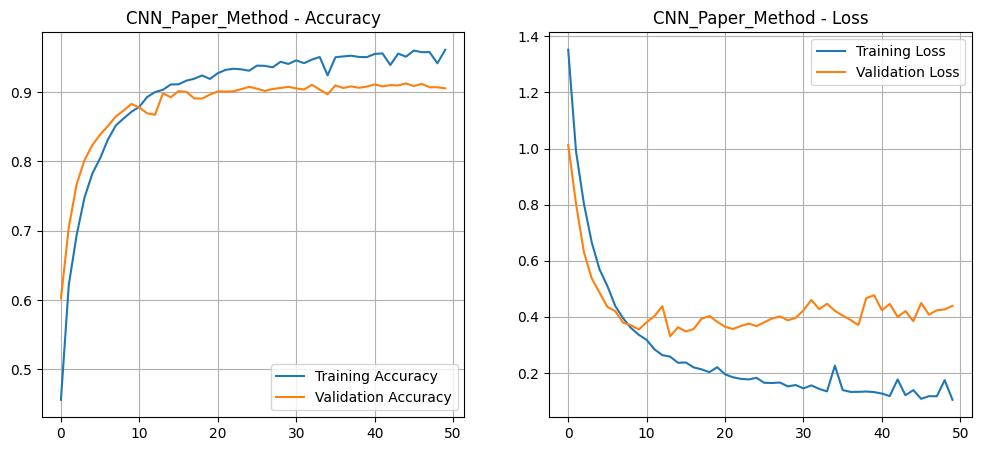


--- Evaluasi Akhir CNN_Paper_Method pada Test Set ---


Testing CNN_Paper_Method: 100%|██████████| 110/110 [00:14<00:00,  7.50it/s]



Classification Report:
              precision    recall  f1-score   support

          nv     0.8923    0.8479    0.8695      1006
         mel     0.8216    0.8388    0.8301      1005
         bkl     0.8347    0.8239    0.8292      1005
         bcc     0.9518    0.9234    0.9374      1005
       akiec     0.9076    0.9682    0.9369      1005
        vasc     0.9941    1.0000    0.9970      1005
          df     0.9960    0.9950    0.9955      1005

    accuracy                         0.9139      7036
   macro avg     0.9140    0.9139    0.9137      7036
weighted avg     0.9140    0.9139    0.9137      7036



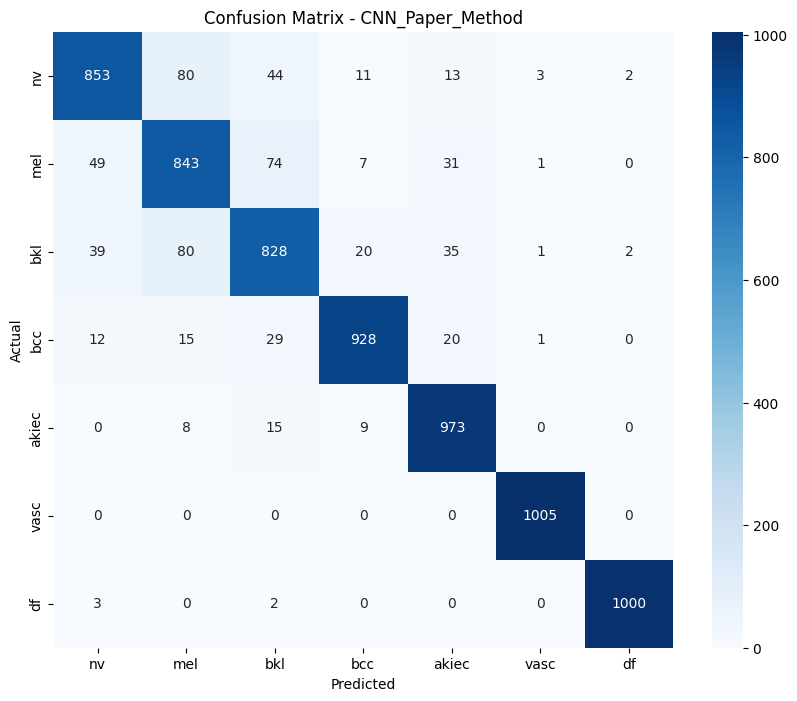

In [ ]:
cnn_paper_model = OptimizedCNN().to(device)
criterion_paper = nn.CrossEntropyLoss()
optimizer_cnn_paper = optim.Adam(cnn_paper_model.parameters(), lr=0.001)

cnn_paper_model, cnn_paper_history = train_and_evaluate(
    cnn_paper_model,
    "CNN_Paper_Method",
    train_loader_paper,
    val_loader_paper,
    criterion_paper,
    optimizer_cnn_paper,
    num_epochs=50
)
plot_history(cnn_paper_history, "CNN_Paper_Method")
cnn_paper_report = evaluate_on_test(cnn_paper_model, test_loader_paper, "CNN_Paper_Method")
results['CNN_Paper_Method'] = cnn_paper_report['accuracy']

Model ini mencapai akurasi tes yang sangat tinggi, yaitu 91.39%. Angka yang tinggi dan performa yang seimbang di semua kelas ini menjadi indikasi kuat bagi kami bahwa hasil ini terinflasi akibat data leakage.

# **13. Eksperimen 1: Memperbaiki Data Leakage**

Memperbaiki metodologi dengan melakukan split data terlebih dahulu pada dataset asli. Setelah itu, kami menerapkan augmentasi offline hanya pada set pelatihan.

In [ ]:
print(f"Menggunakan data_dir dari kagglehub: {data_dir}")

metadata = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))

train_df, val_test_df = train_test_split(metadata, test_size=0.30, random_state=SEED, stratify=metadata['dx'])
val_df, test_df = train_test_split(val_test_df, test_size=0.50, random_state=SEED, stratify=val_test_df['dx'])
print("Data asli telah dibagi (Split First):")
print(f"  > Ukuran Training Set Asli: {len(train_df)}")
print(f"  > Ukuran Validation Set Asli: {len(val_df)}")
print(f"  > Ukuran Test Set Asli: {len(test_df)}")


base_dir = "/kaggle/working/"
augmented_data_dir = os.path.join(base_dir, "augmented_train_data")
if os.path.exists(augmented_data_dir):
    shutil.rmtree(augmented_data_dir)
os.makedirs(augmented_data_dir, exist_ok=True)
print(f"\nDirektori untuk data augmentasi dibuat di: {augmented_data_dir}")

augmented_train_df = perform_offline_augmentation(
    df=train_df, # inputnya hanya train_df
    class_names=class_names,
    data_dir=data_dir,
    augmented_data_dir=augmented_data_dir,
    transforms_to_apply=transforms_to_apply,
    target_count=4700 # ini menyesuaikan dengan jumlah kelas tertinggi di df train yaitu kelas nv
)

# menambahkan kolom 'path' ke DataFrame val dan test yang asli
val_df['path'] = val_df['image_id'].apply(lambda x: os.path.join(data_dir, 'HAM10000_images_part_1' if os.path.exists(os.path.join(data_dir, 'HAM10000_images_part_1', f'{x}.jpg')) else 'HAM10000_images_part_2', f'{x}.jpg'))
test_df['path'] = test_df['image_id'].apply(lambda x: os.path.join(data_dir, 'HAM10000_images_part_1' if os.path.exists(os.path.join(data_dir, 'HAM10000_images_part_1', f'{x}.jpg')) else 'HAM10000_images_part_2', f'{x}.jpg'))

print(f"\nUkuran dataset training SETELAH augmentasi: {len(augmented_train_df)} gambar")
print("Distribusi kelas baru di set training:")
print(augmented_train_df['dx'].value_counts())

Menggunakan data_dir dari kagglehub: /kaggle/input/
Data asli telah dibagi (Split First):
  > Ukuran Training Set Asli: 7010
  > Ukuran Validation Set Asli: 1502
  > Ukuran Test Set Asli: 1503

Direktori untuk data augmentasi dibuat di: /kaggle/working/augmented_train_data


Augmenting Classes: 100%|██████████| 7/7 [04:10<00:00, 35.81s/it]



Ukuran dataset training SETELAH augmentasi: 32893 gambar
Distribusi kelas baru di set training:
dx
mel      4700
bkl      4700
bcc      4700
vasc     4700
akiec    4700
df       4700
nv       4693
Name: count, dtype: int64


Output menunjukkan bahwa set pelatihan kami yang awalnya hanya 7010 gambar, kini menjadi 32.893 gambar yang seimbang, sementara set validasi dan tes tetap "murni".

In [21]:
train_dataset = OfflineAugmentedDataset(df=augmented_train_df, transform=train_transforms)
val_dataset = OfflineAugmentedDataset(df=val_df, transform=val_test_transforms)
test_dataset = OfflineAugmentedDataset(df=test_df, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## **13.1. CNN Baseline Offline**

--- Memulai Pelatihan Model: CNN_Baseline ---


Epoch 1/50 | Train Loss: 1.3620 Acc: 0.4596 | Val Loss: 1.0196 Acc: 0.6225
  > Model terbaik disimpan -> CNN_Baseline.pth (Val Acc: 0.6225)


Epoch 2/50 | Train Loss: 1.0149 Acc: 0.6029 | Val Loss: 0.8047 Acc: 0.6778
  > Model terbaik disimpan -> CNN_Baseline.pth (Val Acc: 0.6778)


Epoch 3/50 | Train Loss: 0.8095 Acc: 0.6904 | Val Loss: 0.7601 Acc: 0.6977
  > Model terbaik disimpan -> CNN_Baseline.pth (Val Acc: 0.6977)


Epoch 4/50 | Train Loss: 0.6489 Acc: 0.7517 | Val Loss: 0.8063 Acc: 0.6911


Epoch 5/50 | Train Loss: 0.5468 Acc: 0.7893 | Val Loss: 0.7638 Acc: 0.7250
  > Model terbaik disimpan -> CNN_Baseline.pth (Val Acc: 0.7250)


Epoch 6/50 | Train Loss: 0.4753 Acc: 0.8190 | Val Loss: 0.8921 Acc: 0.6751


Epoch 7/50 | Train Loss: 0.4219 Acc: 0.8386 | Val Loss: 0.7946 Acc: 0.7204


Epoch 8/50 | Train Loss: 0.3733 Acc: 0.8573 | Val Loss: 0.8601 Acc: 0.7051


Epoch 9/50 | Train Loss: 0.3372 Acc: 0.8708 | Val Loss: 0.8649 Acc: 0.7177


Epoch 10/50 | Train Loss: 0.3167 Acc: 0.8781 | Val Loss: 0.9454 Acc: 0.7244


Epoch 11/50 | Train Loss: 0.2981 Acc: 0.8861 | Val Loss: 0.9334 Acc: 0.7244


Epoch 12/50 | Train Loss: 0.2753 Acc: 0.8945 | Val Loss: 0.9785 Acc: 0.7277
  > Model terbaik disimpan -> CNN_Baseline.pth (Val Acc: 0.7277)


Epoch 13/50 | Train Loss: 0.2529 Acc: 0.9013 | Val Loss: 1.0308 Acc: 0.7304
  > Model terbaik disimpan -> CNN_Baseline.pth (Val Acc: 0.7304)


Epoch 14/50 | Train Loss: 0.2448 Acc: 0.9072 | Val Loss: 1.0166 Acc: 0.7257


Epoch 15/50 | Train Loss: 0.2271 Acc: 0.9143 | Val Loss: 1.0746 Acc: 0.7190


Epoch 16/50 | Train Loss: 0.2227 Acc: 0.9135 | Val Loss: 1.0662 Acc: 0.7197


Epoch 17/50 | Train Loss: 0.2220 Acc: 0.9169 | Val Loss: 1.0439 Acc: 0.7210


Epoch 18/50 | Train Loss: 0.2068 Acc: 0.9214 | Val Loss: 1.0139 Acc: 0.7357
  > Model terbaik disimpan -> CNN_Baseline.pth (Val Acc: 0.7357)


Epoch 19/50 | Train Loss: 0.1927 Acc: 0.9275 | Val Loss: 1.0673 Acc: 0.7443
  > Model terbaik disimpan -> CNN_Baseline.pth (Val Acc: 0.7443)


Epoch 20/50 | Train Loss: 0.1941 Acc: 0.9262 | Val Loss: 1.0689 Acc: 0.7157


Epoch 21/50 | Train Loss: 0.1801 Acc: 0.9306 | Val Loss: 1.1371 Acc: 0.7357


Epoch 22/50 | Train Loss: 0.1738 Acc: 0.9342 | Val Loss: 1.2252 Acc: 0.7257


Epoch 23/50 | Train Loss: 0.1764 Acc: 0.9341 | Val Loss: 1.0108 Acc: 0.7297


Epoch 24/50 | Train Loss: 0.1661 Acc: 0.9396 | Val Loss: 1.2348 Acc: 0.7324


Epoch 25/50 | Train Loss: 0.1687 Acc: 0.9380 | Val Loss: 1.2440 Acc: 0.7230


Epoch 26/50 | Train Loss: 0.1557 Acc: 0.9405 | Val Loss: 1.2296 Acc: 0.7277


Epoch 27/50 | Train Loss: 0.1535 Acc: 0.9442 | Val Loss: 1.2359 Acc: 0.7397


Epoch 28/50 | Train Loss: 0.1493 Acc: 0.9456 | Val Loss: 1.2125 Acc: 0.7457
  > Model terbaik disimpan -> CNN_Baseline.pth (Val Acc: 0.7457)


Epoch 29/50 | Train Loss: 0.1446 Acc: 0.9473 | Val Loss: 1.2627 Acc: 0.7297


Epoch 30/50 | Train Loss: 0.1440 Acc: 0.9468 | Val Loss: 1.3171 Acc: 0.7330


Epoch 31/50 | Train Loss: 0.1414 Acc: 0.9471 | Val Loss: 1.1545 Acc: 0.7417


Epoch 32/50 | Train Loss: 0.1368 Acc: 0.9501 | Val Loss: 1.2999 Acc: 0.7330


Epoch 33/50 | Train Loss: 0.1387 Acc: 0.9492 | Val Loss: 1.2594 Acc: 0.7170


Epoch 34/50 | Train Loss: 0.1340 Acc: 0.9494 | Val Loss: 1.2020 Acc: 0.7357


Epoch 35/50 | Train Loss: 0.1320 Acc: 0.9515 | Val Loss: 1.2863 Acc: 0.7310


Epoch 36/50 | Train Loss: 0.1260 Acc: 0.9553 | Val Loss: 1.4092 Acc: 0.7357


Epoch 37/50 | Train Loss: 0.1224 Acc: 0.9536 | Val Loss: 1.4969 Acc: 0.7270


Epoch 38/50 | Train Loss: 0.1244 Acc: 0.9557 | Val Loss: 1.3524 Acc: 0.7477
  > Model terbaik disimpan -> CNN_Baseline.pth (Val Acc: 0.7477)


Epoch 39/50 | Train Loss: 0.1257 Acc: 0.9538 | Val Loss: 1.4233 Acc: 0.7237


Epoch 40/50 | Train Loss: 0.1145 Acc: 0.9588 | Val Loss: 1.4490 Acc: 0.7403


Epoch 41/50 | Train Loss: 0.1235 Acc: 0.9556 | Val Loss: 1.3133 Acc: 0.7297


Epoch 42/50 | Train Loss: 0.1228 Acc: 0.9553 | Val Loss: 1.3933 Acc: 0.7290


Epoch 43/50 | Train Loss: 0.1258 Acc: 0.9557 | Val Loss: 1.4589 Acc: 0.7337


Epoch 44/50 | Train Loss: 0.1188 Acc: 0.9561 | Val Loss: 1.4813 Acc: 0.7403


Epoch 45/50 | Train Loss: 0.1153 Acc: 0.9580 | Val Loss: 1.4207 Acc: 0.7264


Epoch 46/50 | Train Loss: 0.1069 Acc: 0.9618 | Val Loss: 1.4372 Acc: 0.7270


Epoch 47/50 | Train Loss: 0.1045 Acc: 0.9616 | Val Loss: 1.5861 Acc: 0.7224


Epoch 48/50 | Train Loss: 0.1126 Acc: 0.9598 | Val Loss: 1.6288 Acc: 0.7304


Epoch 49/50 | Train Loss: 0.1144 Acc: 0.9575 | Val Loss: 1.6428 Acc: 0.7091


Epoch 50/50 | Train Loss: 0.1062 Acc: 0.9621 | Val Loss: 1.5052 Acc: 0.7217

Pelatihan Selesai. Akurasi validasi terbaik: 0.7477


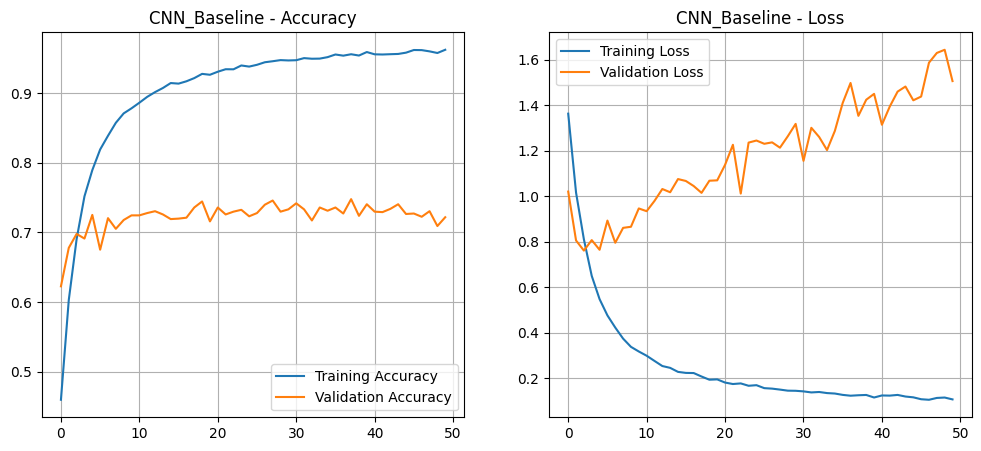


--- Evaluasi Akhir CNN_Baseline pada Test Set ---


Testing CNN_Baseline: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]



Classification Report:
              precision    recall  f1-score   support

          nv     0.8758    0.8688    0.8723      1006
         mel     0.5308    0.4132    0.4646       167
         bkl     0.4971    0.5212    0.5089       165
         bcc     0.4808    0.6494    0.5525        77
       akiec     0.4310    0.5102    0.4673        49
        vasc     0.7600    0.8636    0.8085        22
          df     0.4667    0.4118    0.4375        17

    accuracy                         0.7518      1503
   macro avg     0.5774    0.6054    0.5874      1503
weighted avg     0.7548    0.7518    0.7516      1503



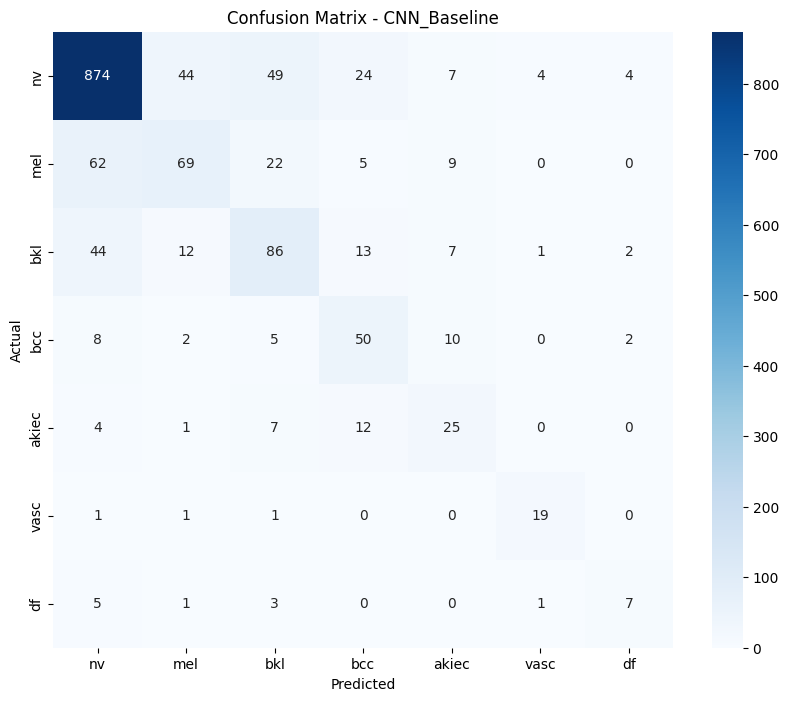

In [ ]:
cnn_model = OptimizedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)

cnn_model, cnn_history = train_and_evaluate(
    cnn_model,
    "CNN_Baseline",
    train_loader,
    val_loader,
    criterion,
    optimizer_cnn,
    num_epochs=50
)

plot_history(cnn_history, "CNN_Baseline")
cnn_report = evaluate_on_test(cnn_model, test_loader, "CNN_Baseline")
results['CNN_Baseline'] = cnn_report['accuracy']

# **14. Eksperimen 1B : Mencoba Improve CNN dari Paper**

Model `OptimizedCNN_V2` dirancang untuk mengatasi beberapa kelemahan potensial dari arsitektur baseline. Dua modifikasi utama yang dilakukan adalah penambahan **Batch Normalization** dan penggantian layer `Flatten` dengan **Global Average Pooling**.

#### 1. Penambahan Batch Normalization (`nn.BatchNorm2d`)
- **Modifikasi**: Sebuah layer `BatchNorm2d` ditambahkan setelah setiap layer konvolusi, sebelum fungsi aktivasi ReLU.
- **Justifikasi**:
    - **Mempercepat Konvergensi dan Menstabilkan Pelatihan**: Batch Normalization menormalkan output dari layer sebelumnya dengan menjaga rata-rata aktivasi mendekati 0 dan standar deviasi mendekati 1. Ini memastikan bahwa input untuk layer berikutnya memiliki distribusi yang stabil, yang secara signifikan mempercepat proses pelatihan. Hal ini didokumentasikan dengan baik dalam paper aslinya oleh Ioffe dan Szegedy (2015), yang menyatakan bahwa BN mengatasi masalah *Internal Covariate Shift*.
    - **Efek Regularisasi**: Batch Normalization menambahkan sedikit *noise* ke setiap *batch* karena normalisasi bergantung pada statistik mini-batch. Efek ini berfungsi sebagai regularisasi, yang dapat mengurangi kebutuhan akan `Dropout`. Beberapa arsitektur modern bahkan hanya menggunakan BN tanpa `Dropout`.

#### 2. Penggantian `Flatten` dengan Global Average Pooling (`nn.AdaptiveAvgPool2d`)
- **Modifikasi**: Layer `Flatten` yang mengubah output konvolusi menjadi vektor satu dimensi yang sangat besar (misalnya, 40.000 fitur) digantikan oleh `AdaptiveAvgPool2d((1, 1))`. Layer ini mengambil setiap *feature map* dari layer konvolusi terakhir dan menghitung rata-ratanya, menghasilkan satu nilai per *feature map*.
- **Justifikasi**:
    - **Mengurangi Overfitting secara Drastis**: Penggunaan `Flatten` pada *feature map* berukuran besar akan menghasilkan jumlah parameter yang sangat banyak di layer *fully connected* pertama (dalam kasus ini, `64 * 25 * 25 = 40.000` fitur, menghasilkan `40000 * 128 = 5,120,000` parameter). Jumlah parameter yang besar ini sangat rentan terhadap *overfitting*.
    - **Efisiensi Parameter**: Global Average Pooling (GAP) secara drastis mengurangi jumlah parameter. Setelah GAP, outputnya adalah `(batch_size, 64, 1, 1)`, yang kemudian diubah menjadi vektor berukuran 64. Layer *fully connected* berikutnya hanya membutuhkan `64 * 128 = 8,192` parameter, sebuah penurunan yang sangat signifikan.
    - **Mempertahankan Hubungan Spasial**: GAP lebih sesuai dengan struktur konvolusional karena memetakan *feature map* ke kategori secara lebih langsung, menjadikannya lebih robust terhadap variasi spasial kecil pada input. Praktik ini dipopulerkan oleh paper *Network in Network* oleh Lin et al. (2013) dan kini menjadi standar di banyak arsitektur modern.

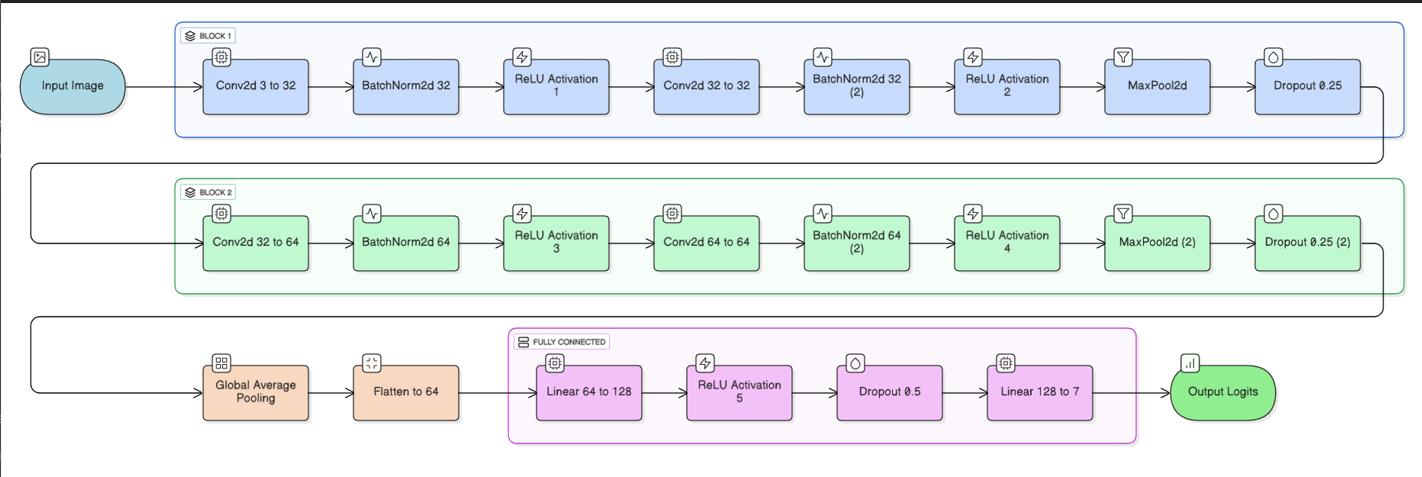

## **14.1. CNN V2 Offline**

In [12]:
class OptimizedCNN_V2(nn.Module):
    def __init__(self):
        super(OptimizedCNN_V2, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # <-- TAMBAHAN
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32) # <-- TAMBAHAN
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        # Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64) # <-- TAMBAHAN
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64) # <-- TAMBAHAN
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        # --- PERUBAHAN BESAR DI SINI ---
        # hapus Flatten, ganti dengan Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # FC Layers baru, jauh lebih kecil dan anti-overfit
        self.fc1 = nn.Linear(64, 128) # Inputnya 64 (dari GAP), bukan 40000
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        # Block 1 (Conv -> BN -> ReLU)
        # Pola forward pass diubah agar lebih standar
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Perubahan di bagian sini
        x = self.gap(x)         # -> (batch_size, 64, 1, 1)
        x = x.view(x.size(0), -1) # -> (batch_size, 64) (Flatten versi mini)

        # FC Layers
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

--- Memulai Pelatihan Model: CNN_V2_Baseline ---


Epoch 1/50 | Train Loss: 1.3977 Acc: 0.4602 | Val Loss: 0.9740 Acc: 0.6318
  > Model terbaik disimpan -> CNN_V2_Baseline.pth (Val Acc: 0.6318)


Epoch 2/50 | Train Loss: 1.1593 Acc: 0.5531 | Val Loss: 0.7998 Acc: 0.6977
  > Model terbaik disimpan -> CNN_V2_Baseline.pth (Val Acc: 0.6977)


Epoch 3/50 | Train Loss: 1.0558 Acc: 0.5917 | Val Loss: 0.9848 Acc: 0.6338


Epoch 4/50 | Train Loss: 0.9881 Acc: 0.6204 | Val Loss: 1.0037 Acc: 0.6431


Epoch 5/50 | Train Loss: 0.9386 Acc: 0.6387 | Val Loss: 0.7681 Acc: 0.7104
  > Model terbaik disimpan -> CNN_V2_Baseline.pth (Val Acc: 0.7104)


Epoch 6/50 | Train Loss: 0.8853 Acc: 0.6577 | Val Loss: 0.7910 Acc: 0.7124
  > Model terbaik disimpan -> CNN_V2_Baseline.pth (Val Acc: 0.7124)


Epoch 7/50 | Train Loss: 0.8438 Acc: 0.6736 | Val Loss: 0.8408 Acc: 0.6864


Epoch 8/50 | Train Loss: 0.8016 Acc: 0.6941 | Val Loss: 0.9744 Acc: 0.6425


Epoch 9/50 | Train Loss: 0.7718 Acc: 0.7013 | Val Loss: 0.8356 Acc: 0.6924


Epoch 10/50 | Train Loss: 0.7455 Acc: 0.7137 | Val Loss: 0.9516 Acc: 0.6591


Epoch 11/50 | Train Loss: 0.7178 Acc: 0.7244 | Val Loss: 0.7607 Acc: 0.7210
  > Model terbaik disimpan -> CNN_V2_Baseline.pth (Val Acc: 0.7210)


Epoch 12/50 | Train Loss: 0.6951 Acc: 0.7327 | Val Loss: 0.7794 Acc: 0.7137


Epoch 13/50 | Train Loss: 0.6713 Acc: 0.7418 | Val Loss: 0.7523 Acc: 0.7277
  > Model terbaik disimpan -> CNN_V2_Baseline.pth (Val Acc: 0.7277)


Epoch 14/50 | Train Loss: 0.6533 Acc: 0.7515 | Val Loss: 0.9569 Acc: 0.6591


Epoch 15/50 | Train Loss: 0.6311 Acc: 0.7589 | Val Loss: 0.6600 Acc: 0.7683
  > Model terbaik disimpan -> CNN_V2_Baseline.pth (Val Acc: 0.7683)


Epoch 16/50 | Train Loss: 0.6079 Acc: 0.7704 | Val Loss: 0.6590 Acc: 0.7563


Epoch 17/50 | Train Loss: 0.5884 Acc: 0.7779 | Val Loss: 0.7162 Acc: 0.7503


Epoch 18/50 | Train Loss: 0.5704 Acc: 0.7857 | Val Loss: 0.8881 Acc: 0.7024


Epoch 19/50 | Train Loss: 0.5595 Acc: 0.7881 | Val Loss: 0.6900 Acc: 0.7676


Epoch 20/50 | Train Loss: 0.5427 Acc: 0.7968 | Val Loss: 0.8514 Acc: 0.6904


Epoch 21/50 | Train Loss: 0.5347 Acc: 0.7975 | Val Loss: 1.4182 Acc: 0.5752


Epoch 22/50 | Train Loss: 0.5265 Acc: 0.8005 | Val Loss: 0.6538 Acc: 0.7650


Epoch 23/50 | Train Loss: 0.5012 Acc: 0.8113 | Val Loss: 0.6325 Acc: 0.7810
  > Model terbaik disimpan -> CNN_V2_Baseline.pth (Val Acc: 0.7810)


Epoch 24/50 | Train Loss: 0.4975 Acc: 0.8135 | Val Loss: 0.6760 Acc: 0.7610


Epoch 25/50 | Train Loss: 0.4791 Acc: 0.8225 | Val Loss: 0.7918 Acc: 0.7237


Epoch 26/50 | Train Loss: 0.4727 Acc: 0.8253 | Val Loss: 0.8126 Acc: 0.7250


Epoch 27/50 | Train Loss: 0.4652 Acc: 0.8246 | Val Loss: 0.6825 Acc: 0.7650


Epoch 28/50 | Train Loss: 0.4419 Acc: 0.8364 | Val Loss: 0.6979 Acc: 0.7743


Epoch 29/50 | Train Loss: 0.4422 Acc: 0.8357 | Val Loss: 0.7229 Acc: 0.7630


Epoch 30/50 | Train Loss: 0.4416 Acc: 0.8343 | Val Loss: 0.7367 Acc: 0.7636


Epoch 31/50 | Train Loss: 0.4267 Acc: 0.8446 | Val Loss: 0.7570 Acc: 0.7650


Epoch 32/50 | Train Loss: 0.4121 Acc: 0.8485 | Val Loss: 0.8005 Acc: 0.7370


Epoch 33/50 | Train Loss: 0.4064 Acc: 0.8490 | Val Loss: 0.6797 Acc: 0.7730


Epoch 34/50 | Train Loss: 0.4064 Acc: 0.8518 | Val Loss: 0.6451 Acc: 0.7770


Epoch 35/50 | Train Loss: 0.3944 Acc: 0.8536 | Val Loss: 0.8260 Acc: 0.7423


Epoch 36/50 | Train Loss: 0.3928 Acc: 0.8542 | Val Loss: 0.7468 Acc: 0.7590


Epoch 37/50 | Train Loss: 0.3782 Acc: 0.8597 | Val Loss: 0.8118 Acc: 0.7403


Epoch 38/50 | Train Loss: 0.3789 Acc: 0.8581 | Val Loss: 2.9588 Acc: 0.4128


Epoch 39/50 | Train Loss: 0.3764 Acc: 0.8584 | Val Loss: 0.8233 Acc: 0.7523


Epoch 40/50 | Train Loss: 0.3713 Acc: 0.8631 | Val Loss: 0.7109 Acc: 0.7736


Epoch 41/50 | Train Loss: 0.3529 Acc: 0.8691 | Val Loss: 0.8592 Acc: 0.7370


Epoch 42/50 | Train Loss: 0.3640 Acc: 0.8665 | Val Loss: 0.7002 Acc: 0.7856
  > Model terbaik disimpan -> CNN_V2_Baseline.pth (Val Acc: 0.7856)


Epoch 43/50 | Train Loss: 0.3507 Acc: 0.8707 | Val Loss: 1.1437 Acc: 0.6704


Epoch 44/50 | Train Loss: 0.3451 Acc: 0.8712 | Val Loss: 0.8828 Acc: 0.7244


Epoch 45/50 | Train Loss: 0.3447 Acc: 0.8707 | Val Loss: 0.7816 Acc: 0.7750


Epoch 46/50 | Train Loss: 0.3425 Acc: 0.8711 | Val Loss: 0.7556 Acc: 0.7796


Epoch 47/50 | Train Loss: 0.3316 Acc: 0.8760 | Val Loss: 0.8380 Acc: 0.7610


Epoch 48/50 | Train Loss: 0.3328 Acc: 0.8759 | Val Loss: 0.7284 Acc: 0.7863
  > Model terbaik disimpan -> CNN_V2_Baseline.pth (Val Acc: 0.7863)


Epoch 49/50 | Train Loss: 0.3289 Acc: 0.8792 | Val Loss: 0.7255 Acc: 0.7830


Epoch 50/50 | Train Loss: 0.3233 Acc: 0.8785 | Val Loss: 0.8638 Acc: 0.7537

Pelatihan Selesai. Akurasi validasi terbaik: 0.7863


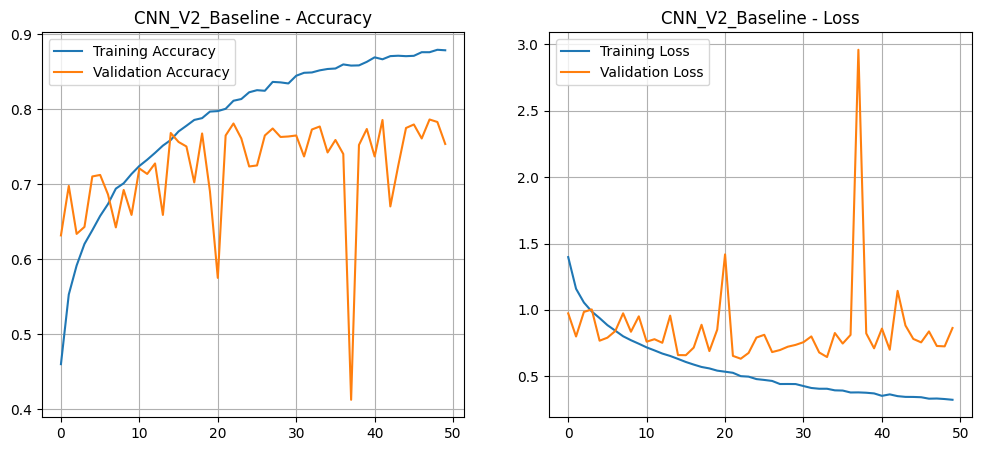


--- Evaluasi Akhir CNN_V2_Baseline pada Test Set ---


Testing CNN_V2_Baseline: 100%|██████████| 24/24 [00:07<00:00,  3.38it/s]



Classification Report:
              precision    recall  f1-score   support

          nv     0.8708    0.8777    0.8743      1006
         mel     0.4832    0.4311    0.4557       167
         bkl     0.6059    0.6242    0.6149       165
         bcc     0.5361    0.6753    0.5977        77
       akiec     0.5385    0.4286    0.4773        49
        vasc     0.9444    0.7727    0.8500        22
          df     0.5000    0.4706    0.4848        17

    accuracy                         0.7691      1503
   macro avg     0.6398    0.6115    0.6221      1503
weighted avg     0.7676    0.7691    0.7674      1503



In [ ]:
cnn_v2_model = OptimizedCNN_V2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_cnn_v2 = optim.Adam(cnn_v2_model.parameters(), lr=0.001)

cnn_v2_model, cnn_v2_history = train_and_evaluate(
    cnn_v2_model,
    "CNN_V2_Baseline",
    train_loader,
    val_loader,
    criterion,
    optimizer_cnn_v2,
    num_epochs=50
)

plot_history(cnn_v2_history, "CNN_V2_Baseline")
cnn_v2_report = evaluate_on_test(cnn_v2_model, test_loader, "CNN_V2_Baseline")
results['CNN_V2_Baseline'] = cnn_v2_report['accuracy']

Model ini mencapai akurasi tes 76.91%, sedikit lebih baik daripada CNN_Baseline (75.18%). Ini menunjukkan bahwa penambahan Batch Normalization dan Global Average Pooling memang memberikan perbaikan, meskipun tidak drastis.

# **15. Eksperimen 1B: Variasi Model Lain**

## **15.1. ResNet50 Offline**

Mengimplementasikan transfer learning dengan memuat ResNet50 pre-trained. Kami membekukan sebagian besar lapisan dan hanya melakukan fine-tuning pada blok konvolusi terakhir (layer4) dan classifier-nya.


--- Memulai Pelatihan Model Pre-Trained dengan Fine-Tuning (Dataset Offline) ---

--- Melatih ResNet50_FineTune ---


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


--- Memulai Pelatihan Model: ResNet50_FineTune ---


Epoch 1/50 | Train Loss: 0.3822 Acc: 0.8614 | Val Loss: 0.5930 Acc: 0.7936
  > Model terbaik disimpan -> ResNet50_FineTune.pth (Val Acc: 0.7936)


Epoch 2/50 | Train Loss: 0.0967 Acc: 0.9654 | Val Loss: 0.5989 Acc: 0.8249
  > Model terbaik disimpan -> ResNet50_FineTune.pth (Val Acc: 0.8249)


Epoch 3/50 | Train Loss: 0.0480 Acc: 0.9830 | Val Loss: 0.6754 Acc: 0.8083


Epoch 4/50 | Train Loss: 0.0306 Acc: 0.9901 | Val Loss: 0.8304 Acc: 0.8242


Epoch 5/50 | Train Loss: 0.0222 Acc: 0.9927 | Val Loss: 0.7105 Acc: 0.8156


Epoch 6/50 | Train Loss: 0.0222 Acc: 0.9928 | Val Loss: 0.8071 Acc: 0.8276
  > Model terbaik disimpan -> ResNet50_FineTune.pth (Val Acc: 0.8276)


Epoch 7/50 | Train Loss: 0.0191 Acc: 0.9941 | Val Loss: 0.9053 Acc: 0.8182


Epoch 8/50 | Train Loss: 0.0165 Acc: 0.9948 | Val Loss: 0.7982 Acc: 0.8136


Epoch 9/50 | Train Loss: 0.0155 Acc: 0.9949 | Val Loss: 0.7833 Acc: 0.8322
  > Model terbaik disimpan -> ResNet50_FineTune.pth (Val Acc: 0.8322)


Epoch 10/50 | Train Loss: 0.0125 Acc: 0.9960 | Val Loss: 0.7686 Acc: 0.8336
  > Model terbaik disimpan -> ResNet50_FineTune.pth (Val Acc: 0.8336)


Epoch 11/50 | Train Loss: 0.0123 Acc: 0.9960 | Val Loss: 0.8828 Acc: 0.8336


Epoch 12/50 | Train Loss: 0.0168 Acc: 0.9946 | Val Loss: 0.8892 Acc: 0.8202


Epoch 13/50 | Train Loss: 0.0083 Acc: 0.9974 | Val Loss: 0.9127 Acc: 0.8316


Epoch 14/50 | Train Loss: 0.0096 Acc: 0.9969 | Val Loss: 0.8845 Acc: 0.8342
  > Model terbaik disimpan -> ResNet50_FineTune.pth (Val Acc: 0.8342)


Epoch 15/50 | Train Loss: 0.0137 Acc: 0.9958 | Val Loss: 0.9292 Acc: 0.8349
  > Model terbaik disimpan -> ResNet50_FineTune.pth (Val Acc: 0.8349)


Epoch 16/50 | Train Loss: 0.0097 Acc: 0.9967 | Val Loss: 0.9752 Acc: 0.8316


Epoch 17/50 | Train Loss: 0.0076 Acc: 0.9975 | Val Loss: 0.9878 Acc: 0.8362
  > Model terbaik disimpan -> ResNet50_FineTune.pth (Val Acc: 0.8362)


Epoch 18/50 | Train Loss: 0.0054 Acc: 0.9982 | Val Loss: 1.0055 Acc: 0.8109


Epoch 19/50 | Train Loss: 0.0108 Acc: 0.9967 | Val Loss: 1.0551 Acc: 0.8256


Epoch 20/50 | Train Loss: 0.0087 Acc: 0.9972 | Val Loss: 1.0486 Acc: 0.8142


Epoch 21/50 | Train Loss: 0.0104 Acc: 0.9970 | Val Loss: 1.1195 Acc: 0.8156


Epoch 22/50 | Train Loss: 0.0068 Acc: 0.9978 | Val Loss: 1.1557 Acc: 0.7949


Epoch 23/50 | Train Loss: 0.0063 Acc: 0.9981 | Val Loss: 0.9572 Acc: 0.8282


Epoch 24/50 | Train Loss: 0.0028 Acc: 0.9993 | Val Loss: 1.1490 Acc: 0.8242


Epoch 25/50 | Train Loss: 0.0076 Acc: 0.9974 | Val Loss: 1.1520 Acc: 0.8289


Epoch 26/50 | Train Loss: 0.0082 Acc: 0.9978 | Val Loss: 1.0366 Acc: 0.8169


Epoch 27/50 | Train Loss: 0.0088 Acc: 0.9972 | Val Loss: 1.0999 Acc: 0.8289


Epoch 28/50 | Train Loss: 0.0058 Acc: 0.9982 | Val Loss: 1.1362 Acc: 0.8282


Epoch 29/50 | Train Loss: 0.0043 Acc: 0.9984 | Val Loss: 1.0775 Acc: 0.8196


Epoch 30/50 | Train Loss: 0.0056 Acc: 0.9984 | Val Loss: 1.0152 Acc: 0.8269


Epoch 31/50 | Train Loss: 0.0027 Acc: 0.9991 | Val Loss: 1.2513 Acc: 0.8289


Epoch 32/50 | Train Loss: 0.0068 Acc: 0.9977 | Val Loss: 1.0739 Acc: 0.8182


Epoch 33/50 | Train Loss: 0.0048 Acc: 0.9984 | Val Loss: 1.0750 Acc: 0.8096


Epoch 34/50 | Train Loss: 0.0057 Acc: 0.9982 | Val Loss: 1.0668 Acc: 0.8269


Epoch 35/50 | Train Loss: 0.0047 Acc: 0.9987 | Val Loss: 1.0788 Acc: 0.8296


Epoch 36/50 | Train Loss: 0.0031 Acc: 0.9991 | Val Loss: 1.1538 Acc: 0.8369
  > Model terbaik disimpan -> ResNet50_FineTune.pth (Val Acc: 0.8369)


Epoch 37/50 | Train Loss: 0.0035 Acc: 0.9988 | Val Loss: 1.0361 Acc: 0.8309


Epoch 38/50 | Train Loss: 0.0051 Acc: 0.9983 | Val Loss: 1.2038 Acc: 0.8229


Epoch 39/50 | Train Loss: 0.0040 Acc: 0.9987 | Val Loss: 1.1907 Acc: 0.8142


Epoch 40/50 | Train Loss: 0.0036 Acc: 0.9988 | Val Loss: 1.1562 Acc: 0.8262


Epoch 41/50 | Train Loss: 0.0037 Acc: 0.9989 | Val Loss: 1.1869 Acc: 0.8189


Epoch 42/50 | Train Loss: 0.0039 Acc: 0.9987 | Val Loss: 1.2230 Acc: 0.8256


Epoch 43/50 | Train Loss: 0.0052 Acc: 0.9985 | Val Loss: 1.0424 Acc: 0.8382
  > Model terbaik disimpan -> ResNet50_FineTune.pth (Val Acc: 0.8382)


Epoch 44/50 | Train Loss: 0.0047 Acc: 0.9986 | Val Loss: 1.1415 Acc: 0.8309


Epoch 45/50 | Train Loss: 0.0028 Acc: 0.9992 | Val Loss: 1.1367 Acc: 0.8415
  > Model terbaik disimpan -> ResNet50_FineTune.pth (Val Acc: 0.8415)


Epoch 46/50 | Train Loss: 0.0022 Acc: 0.9992 | Val Loss: 1.2210 Acc: 0.8382


Epoch 47/50 | Train Loss: 0.0027 Acc: 0.9993 | Val Loss: 1.1593 Acc: 0.8336


Epoch 48/50 | Train Loss: 0.0040 Acc: 0.9988 | Val Loss: 1.1747 Acc: 0.8289


Epoch 49/50 | Train Loss: 0.0040 Acc: 0.9988 | Val Loss: 1.1307 Acc: 0.8302


Epoch 50/50 | Train Loss: 0.0067 Acc: 0.9984 | Val Loss: 1.2295 Acc: 0.8389

Pelatihan Selesai. Akurasi validasi terbaik: 0.8415



--- Evaluasi Akhir ResNet50_FineTune pada Test Set ---


Testing ResNet50_FineTune: 100%|██████████| 24/24 [00:07<00:00,  3.41it/s]



Classification Report:
              precision    recall  f1-score   support

          nv     0.9065    0.9344    0.9202      1006
         mel     0.6447    0.5868    0.6144       167
         bkl     0.6957    0.6788    0.6871       165
         bcc     0.7654    0.8052    0.7848        77
       akiec     0.6905    0.5918    0.6374        49
        vasc     0.9474    0.8182    0.8780        22
          df     0.8182    0.5294    0.6429        17

    accuracy                         0.8436      1503
   macro avg     0.7812    0.7064    0.7378      1503
weighted avg     0.8396    0.8436    0.8407      1503



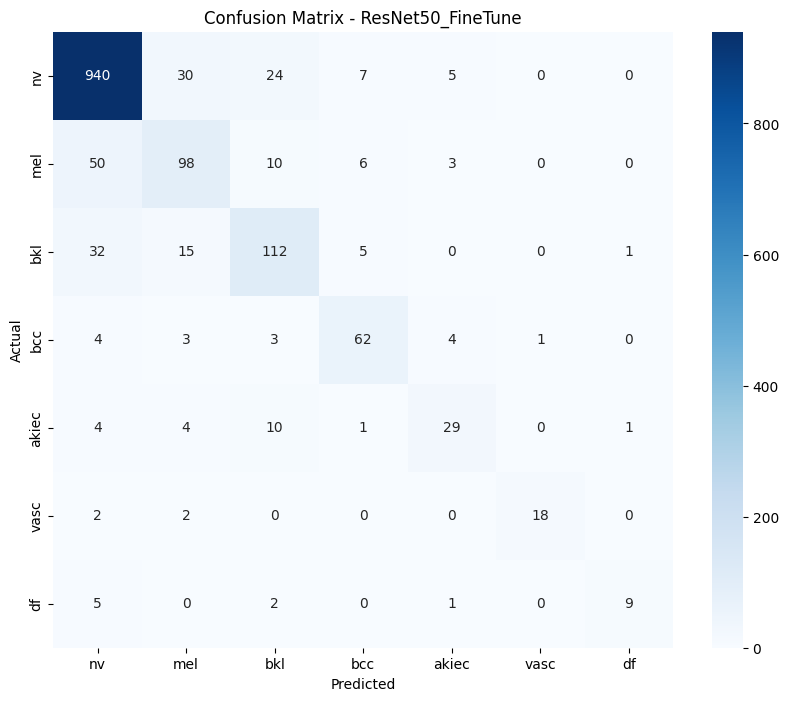

In [ ]:
print("\n--- Memulai Pelatihan Model Pre-Trained dengan Fine-Tuning (Dataset Offline) ---")

# RESNET50 dengan Fine-Tuning
print("\n--- Melatih ResNet50_FineTune ---")
resnet_model_ft = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# freeze semua layer terlebih dulu
for param in resnet_model_ft.parameters():
    param.requires_grad = False

# lalu unfreeze layer terakhir (klo di resnet50 layer4)
for param in resnet_model_ft.layer4.parameters():
    param.requires_grad = True

# mengganti classifier (layer ini otomatis requires_grad = True)
num_ftrs_ft = resnet_model_ft.fc.in_features
resnet_model_ft.fc = nn.Linear(num_ftrs_ft, 7)
resnet_model_ft = resnet_model_ft.to(device)

# optimizer sekarang akan melatih 'layer4' dan 'fc'
optimizer_resnet_ft = optim.Adam(resnet_model_ft.parameters(), lr=0.001)

resnet_model_ft, resnet_history_ft = train_and_evaluate(
    resnet_model_ft,
    "ResNet50_FineTune",
    train_loader,
    val_loader,
    criterion,
    optimizer_resnet_ft,
    num_epochs=50
)

plot_history(resnet_history_ft, "ResNet50_FineTune")
resnet_report_ft = evaluate_on_test(resnet_model_ft, test_loader, "ResNet50_FineTune")
results['ResNet50_FineTune'] = resnet_report_ft['accuracy']

Kami mendapatkan akurasi tes yang sangat baik sebesar 84.36%, yang menunjukkan betapa kuatnya transfer learning dibandingkan melatih model dari awal.

## **15.2. DenseNet121 Offline**

Menerapkan strategi fine-tuning yang sama pada DenseNet121, dengan hanya melatih dense block terakhir (denseblock4).


--- Melatih DenseNet121_FineTune ---


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 195MB/s]


--- Memulai Pelatihan Model: DenseNet121_FineTune ---


Epoch 1/50 | Train Loss: 0.4349 Acc: 0.8388 | Val Loss: 0.6389 Acc: 0.7830
  > Model terbaik disimpan -> DenseNet121_FineTune.pth (Val Acc: 0.7830)


Epoch 2/50 | Train Loss: 0.1611 Acc: 0.9430 | Val Loss: 0.6748 Acc: 0.7850
  > Model terbaik disimpan -> DenseNet121_FineTune.pth (Val Acc: 0.7850)


Epoch 3/50 | Train Loss: 0.0949 Acc: 0.9658 | Val Loss: 0.7152 Acc: 0.8129
  > Model terbaik disimpan -> DenseNet121_FineTune.pth (Val Acc: 0.8129)


Epoch 4/50 | Train Loss: 0.0655 Acc: 0.9774 | Val Loss: 0.7959 Acc: 0.7856


Epoch 5/50 | Train Loss: 0.0554 Acc: 0.9808 | Val Loss: 0.8213 Acc: 0.8123


Epoch 6/50 | Train Loss: 0.0452 Acc: 0.9842 | Val Loss: 0.8615 Acc: 0.8129


Epoch 7/50 | Train Loss: 0.0409 Acc: 0.9863 | Val Loss: 0.9441 Acc: 0.7896


Epoch 8/50 | Train Loss: 0.0415 Acc: 0.9854 | Val Loss: 0.9838 Acc: 0.8129


Epoch 9/50 | Train Loss: 0.0329 Acc: 0.9890 | Val Loss: 0.9735 Acc: 0.8056


Epoch 10/50 | Train Loss: 0.0304 Acc: 0.9893 | Val Loss: 1.0240 Acc: 0.8142
  > Model terbaik disimpan -> DenseNet121_FineTune.pth (Val Acc: 0.8142)


Epoch 11/50 | Train Loss: 0.0325 Acc: 0.9891 | Val Loss: 1.1018 Acc: 0.8029


Epoch 12/50 | Train Loss: 0.0387 Acc: 0.9867 | Val Loss: 0.9602 Acc: 0.8202
  > Model terbaik disimpan -> DenseNet121_FineTune.pth (Val Acc: 0.8202)


Epoch 13/50 | Train Loss: 0.0213 Acc: 0.9929 | Val Loss: 1.1618 Acc: 0.7989


Epoch 14/50 | Train Loss: 0.0279 Acc: 0.9905 | Val Loss: 1.1503 Acc: 0.7989


Epoch 15/50 | Train Loss: 0.0226 Acc: 0.9926 | Val Loss: 1.0961 Acc: 0.8089


Epoch 16/50 | Train Loss: 0.0230 Acc: 0.9925 | Val Loss: 1.2664 Acc: 0.8129


Epoch 17/50 | Train Loss: 0.0293 Acc: 0.9903 | Val Loss: 1.1848 Acc: 0.7963


Epoch 18/50 | Train Loss: 0.0257 Acc: 0.9912 | Val Loss: 1.1994 Acc: 0.8089


Epoch 19/50 | Train Loss: 0.0182 Acc: 0.9940 | Val Loss: 1.1665 Acc: 0.8156


Epoch 20/50 | Train Loss: 0.0198 Acc: 0.9931 | Val Loss: 1.1315 Acc: 0.8276
  > Model terbaik disimpan -> DenseNet121_FineTune.pth (Val Acc: 0.8276)


Epoch 21/50 | Train Loss: 0.0225 Acc: 0.9924 | Val Loss: 1.1853 Acc: 0.8023


Epoch 22/50 | Train Loss: 0.0193 Acc: 0.9934 | Val Loss: 1.1720 Acc: 0.8116


Epoch 23/50 | Train Loss: 0.0157 Acc: 0.9948 | Val Loss: 1.3609 Acc: 0.8076


Epoch 24/50 | Train Loss: 0.0189 Acc: 0.9941 | Val Loss: 1.2380 Acc: 0.8162


Epoch 25/50 | Train Loss: 0.0187 Acc: 0.9942 | Val Loss: 1.2912 Acc: 0.8202


Epoch 26/50 | Train Loss: 0.0208 Acc: 0.9934 | Val Loss: 1.2522 Acc: 0.8076


Epoch 27/50 | Train Loss: 0.0128 Acc: 0.9957 | Val Loss: 1.3127 Acc: 0.7996


Epoch 28/50 | Train Loss: 0.0098 Acc: 0.9966 | Val Loss: 1.3620 Acc: 0.8222


Epoch 29/50 | Train Loss: 0.0211 Acc: 0.9932 | Val Loss: 1.2643 Acc: 0.8202


Epoch 30/50 | Train Loss: 0.0161 Acc: 0.9948 | Val Loss: 1.4162 Acc: 0.8063


Epoch 31/50 | Train Loss: 0.0218 Acc: 0.9934 | Val Loss: 1.3354 Acc: 0.8096


Epoch 32/50 | Train Loss: 0.0105 Acc: 0.9969 | Val Loss: 1.3198 Acc: 0.8256


Epoch 33/50 | Train Loss: 0.0082 Acc: 0.9971 | Val Loss: 1.4357 Acc: 0.8089


Epoch 34/50 | Train Loss: 0.0147 Acc: 0.9955 | Val Loss: 1.4829 Acc: 0.8009


Epoch 35/50 | Train Loss: 0.0205 Acc: 0.9934 | Val Loss: 1.3604 Acc: 0.8083


Epoch 36/50 | Train Loss: 0.0137 Acc: 0.9957 | Val Loss: 1.3641 Acc: 0.8123


Epoch 37/50 | Train Loss: 0.0074 Acc: 0.9975 | Val Loss: 1.3242 Acc: 0.8089


Epoch 38/50 | Train Loss: 0.0118 Acc: 0.9962 | Val Loss: 1.4169 Acc: 0.8129


Epoch 39/50 | Train Loss: 0.0194 Acc: 0.9935 | Val Loss: 1.3553 Acc: 0.8103


Epoch 40/50 | Train Loss: 0.0111 Acc: 0.9966 | Val Loss: 1.4203 Acc: 0.8096


Epoch 41/50 | Train Loss: 0.0103 Acc: 0.9959 | Val Loss: 1.5050 Acc: 0.7923


Epoch 42/50 | Train Loss: 0.0126 Acc: 0.9963 | Val Loss: 1.4868 Acc: 0.8076


Epoch 43/50 | Train Loss: 0.0129 Acc: 0.9957 | Val Loss: 1.4325 Acc: 0.8083


Epoch 44/50 | Train Loss: 0.0138 Acc: 0.9964 | Val Loss: 1.3711 Acc: 0.8169


Epoch 45/50 | Train Loss: 0.0131 Acc: 0.9963 | Val Loss: 1.4477 Acc: 0.8189


Epoch 46/50 | Train Loss: 0.0099 Acc: 0.9970 | Val Loss: 1.3893 Acc: 0.8142


Epoch 47/50 | Train Loss: 0.0094 Acc: 0.9974 | Val Loss: 1.5485 Acc: 0.8103


Epoch 48/50 | Train Loss: 0.0169 Acc: 0.9945 | Val Loss: 1.4937 Acc: 0.8123


Epoch 49/50 | Train Loss: 0.0114 Acc: 0.9964 | Val Loss: 1.3697 Acc: 0.8109


Epoch 50/50 | Train Loss: 0.0105 Acc: 0.9965 | Val Loss: 1.4335 Acc: 0.8109

Pelatihan Selesai. Akurasi validasi terbaik: 0.8276



--- Evaluasi Akhir DenseNet121_FineTune pada Test Set ---


Testing DenseNet121_FineTune: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]



Classification Report:
              precision    recall  f1-score   support

          nv     0.8998    0.9195    0.9095      1006
         mel     0.6418    0.5150    0.5714       167
         bkl     0.6066    0.6727    0.6379       165
         bcc     0.6593    0.7792    0.7143        77
       akiec     0.6250    0.5102    0.5618        49
        vasc     0.7619    0.7273    0.7442        22
          df     0.8333    0.2941    0.4348        17

    accuracy                         0.8170      1503
   macro avg     0.7182    0.6311    0.6534      1503
weighted avg     0.8149    0.8170    0.8130      1503



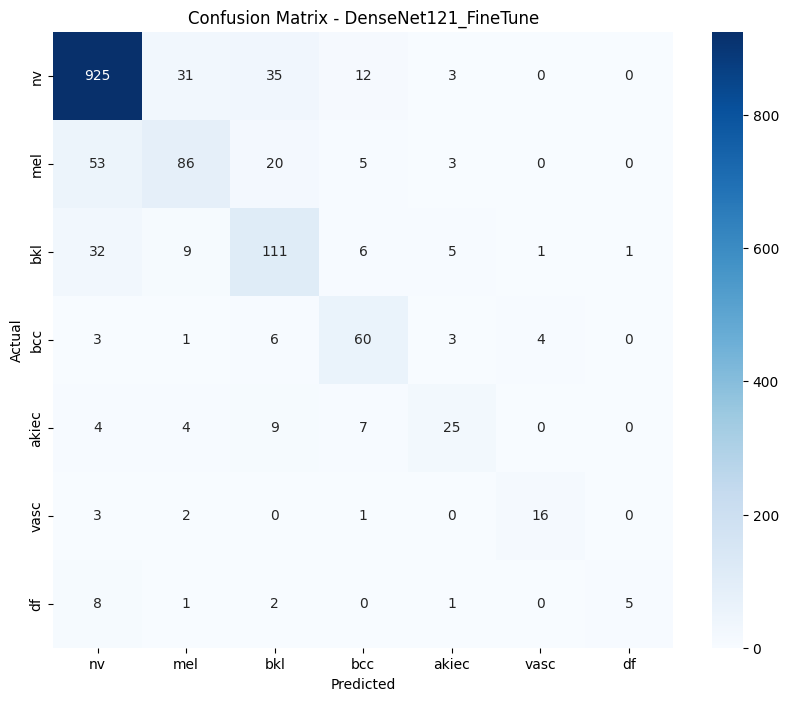

In [ ]:
# DENSENET121 dengan Fine-Tuning
print("\n--- Melatih DenseNet121_FineTune ---")
densenet_model_ft = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

# freeze semua layer
for param in densenet_model_ft.parameters():
    param.requires_grad = False

# unfreeze hanya denseblock terakhir (denseblock4)
for param in densenet_model_ft.features.denseblock4.parameters():
    param.requires_grad = True

# mengganti classifier
num_ftrs = densenet_model_ft.classifier.in_features
densenet_model_ft.classifier = nn.Linear(num_ftrs, 7)
densenet_model_ft = densenet_model_ft.to(device)

# optimizer akan melatih 'denseblock4' dan 'classifier'
optimizer_densenet_ft = optim.Adam(densenet_model_ft.parameters(), lr=0.001)

densenet_model_ft, densenet_history_ft = train_and_evaluate(
    densenet_model_ft,
    "DenseNet121_FineTune",
    train_loader,
    val_loader,
    criterion,
    optimizer_densenet_ft,
    num_epochs=50
)
plot_history(densenet_history_ft, "DenseNet121_FineTune")
densenet_report_ft = evaluate_on_test(densenet_model_ft, test_loader, "DenseNet121_FineTune")
results['DenseNet121_FineTune'] = densenet_report_ft['accuracy']

Kami mencapai akurasi 81.70%, performa yang solid meskipun sedikit di bawah ResNet50.

## **15.3. EfficientNetB0 Offline**

Melatih ulang dua blok fitur terakhir dari EfficientNet-B0.


--- Melatih EfficientNetB0_FineTune ---


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 159MB/s]


--- Memulai Pelatihan Model: EfficientNetB0_FineTune ---


Epoch 1/50 | Train Loss: 0.6800 Acc: 0.7494 | Val Loss: 0.6829 Acc: 0.7463
  > Model terbaik disimpan -> EfficientNetB0_FineTune.pth (Val Acc: 0.7463)


Epoch 2/50 | Train Loss: 0.3521 Acc: 0.8711 | Val Loss: 0.6570 Acc: 0.7876
  > Model terbaik disimpan -> EfficientNetB0_FineTune.pth (Val Acc: 0.7876)


Epoch 3/50 | Train Loss: 0.2560 Acc: 0.9070 | Val Loss: 0.7681 Acc: 0.7617


Epoch 4/50 | Train Loss: 0.1934 Acc: 0.9302 | Val Loss: 0.7782 Acc: 0.7670


Epoch 5/50 | Train Loss: 0.1608 Acc: 0.9431 | Val Loss: 0.8321 Acc: 0.7823


Epoch 6/50 | Train Loss: 0.1420 Acc: 0.9495 | Val Loss: 0.9161 Acc: 0.7623


Epoch 7/50 | Train Loss: 0.1269 Acc: 0.9566 | Val Loss: 0.9223 Acc: 0.7630


Epoch 8/50 | Train Loss: 0.1118 Acc: 0.9615 | Val Loss: 0.9117 Acc: 0.7683


Epoch 9/50 | Train Loss: 0.1012 Acc: 0.9641 | Val Loss: 0.8989 Acc: 0.7803


Epoch 10/50 | Train Loss: 0.0892 Acc: 0.9687 | Val Loss: 0.9436 Acc: 0.7763


Epoch 11/50 | Train Loss: 0.0900 Acc: 0.9691 | Val Loss: 0.9515 Acc: 0.7796


Epoch 12/50 | Train Loss: 0.0822 Acc: 0.9721 | Val Loss: 0.9548 Acc: 0.7823


Epoch 13/50 | Train Loss: 0.0818 Acc: 0.9715 | Val Loss: 0.9708 Acc: 0.7943
  > Model terbaik disimpan -> EfficientNetB0_FineTune.pth (Val Acc: 0.7943)


Epoch 14/50 | Train Loss: 0.0713 Acc: 0.9763 | Val Loss: 0.9344 Acc: 0.7963
  > Model terbaik disimpan -> EfficientNetB0_FineTune.pth (Val Acc: 0.7963)


Epoch 15/50 | Train Loss: 0.0686 Acc: 0.9760 | Val Loss: 1.0354 Acc: 0.7830


Epoch 16/50 | Train Loss: 0.0691 Acc: 0.9760 | Val Loss: 1.0170 Acc: 0.7850


Epoch 17/50 | Train Loss: 0.0628 Acc: 0.9788 | Val Loss: 1.0444 Acc: 0.7876


Epoch 18/50 | Train Loss: 0.0661 Acc: 0.9771 | Val Loss: 1.0649 Acc: 0.7969
  > Model terbaik disimpan -> EfficientNetB0_FineTune.pth (Val Acc: 0.7969)


Epoch 19/50 | Train Loss: 0.0610 Acc: 0.9789 | Val Loss: 0.9947 Acc: 0.7896


Epoch 20/50 | Train Loss: 0.0528 Acc: 0.9824 | Val Loss: 1.0126 Acc: 0.8009
  > Model terbaik disimpan -> EfficientNetB0_FineTune.pth (Val Acc: 0.8009)


Epoch 21/50 | Train Loss: 0.0545 Acc: 0.9818 | Val Loss: 1.0220 Acc: 0.7949


Epoch 22/50 | Train Loss: 0.0544 Acc: 0.9813 | Val Loss: 1.0899 Acc: 0.7856


Epoch 23/50 | Train Loss: 0.0554 Acc: 0.9822 | Val Loss: 1.0981 Acc: 0.7903


Epoch 24/50 | Train Loss: 0.0503 Acc: 0.9830 | Val Loss: 1.1050 Acc: 0.7883


Epoch 25/50 | Train Loss: 0.0510 Acc: 0.9827 | Val Loss: 1.1659 Acc: 0.7856


Epoch 26/50 | Train Loss: 0.0458 Acc: 0.9849 | Val Loss: 1.1997 Acc: 0.7810


Epoch 27/50 | Train Loss: 0.0504 Acc: 0.9836 | Val Loss: 1.1421 Acc: 0.7683


Epoch 28/50 | Train Loss: 0.0477 Acc: 0.9850 | Val Loss: 1.1245 Acc: 0.7783


Epoch 29/50 | Train Loss: 0.0446 Acc: 0.9853 | Val Loss: 1.1026 Acc: 0.7929


Epoch 30/50 | Train Loss: 0.0448 Acc: 0.9859 | Val Loss: 1.1770 Acc: 0.7956


Epoch 31/50 | Train Loss: 0.0452 Acc: 0.9853 | Val Loss: 1.1971 Acc: 0.7896


Epoch 32/50 | Train Loss: 0.0418 Acc: 0.9863 | Val Loss: 1.2143 Acc: 0.7903


Epoch 33/50 | Train Loss: 0.0392 Acc: 0.9864 | Val Loss: 1.1013 Acc: 0.8023
  > Model terbaik disimpan -> EfficientNetB0_FineTune.pth (Val Acc: 0.8023)


Epoch 34/50 | Train Loss: 0.0399 Acc: 0.9866 | Val Loss: 1.1581 Acc: 0.8069
  > Model terbaik disimpan -> EfficientNetB0_FineTune.pth (Val Acc: 0.8069)


Epoch 35/50 | Train Loss: 0.0392 Acc: 0.9876 | Val Loss: 1.0862 Acc: 0.7996


Epoch 36/50 | Train Loss: 0.0389 Acc: 0.9864 | Val Loss: 1.1644 Acc: 0.7876


Epoch 37/50 | Train Loss: 0.0406 Acc: 0.9869 | Val Loss: 1.1371 Acc: 0.7889


Epoch 38/50 | Train Loss: 0.0362 Acc: 0.9877 | Val Loss: 1.1596 Acc: 0.7929


Epoch 39/50 | Train Loss: 0.0375 Acc: 0.9881 | Val Loss: 1.1848 Acc: 0.8043


Epoch 40/50 | Train Loss: 0.0354 Acc: 0.9877 | Val Loss: 1.0979 Acc: 0.7916


Epoch 41/50 | Train Loss: 0.0357 Acc: 0.9878 | Val Loss: 1.2286 Acc: 0.7976


Epoch 42/50 | Train Loss: 0.0350 Acc: 0.9879 | Val Loss: 1.1895 Acc: 0.8016


Epoch 43/50 | Train Loss: 0.0347 Acc: 0.9889 | Val Loss: 1.1723 Acc: 0.7963


Epoch 44/50 | Train Loss: 0.0358 Acc: 0.9880 | Val Loss: 1.0420 Acc: 0.8103
  > Model terbaik disimpan -> EfficientNetB0_FineTune.pth (Val Acc: 0.8103)


Epoch 45/50 | Train Loss: 0.0315 Acc: 0.9891 | Val Loss: 1.1716 Acc: 0.7989


Epoch 46/50 | Train Loss: 0.0349 Acc: 0.9881 | Val Loss: 1.1550 Acc: 0.7936


Epoch 47/50 | Train Loss: 0.0313 Acc: 0.9888 | Val Loss: 1.1998 Acc: 0.8016


Epoch 48/50 | Train Loss: 0.0288 Acc: 0.9904 | Val Loss: 1.2008 Acc: 0.8016


Epoch 49/50 | Train Loss: 0.0303 Acc: 0.9901 | Val Loss: 1.2541 Acc: 0.7983


Epoch 50/50 | Train Loss: 0.0275 Acc: 0.9902 | Val Loss: 1.2391 Acc: 0.7943

Pelatihan Selesai. Akurasi validasi terbaik: 0.8103


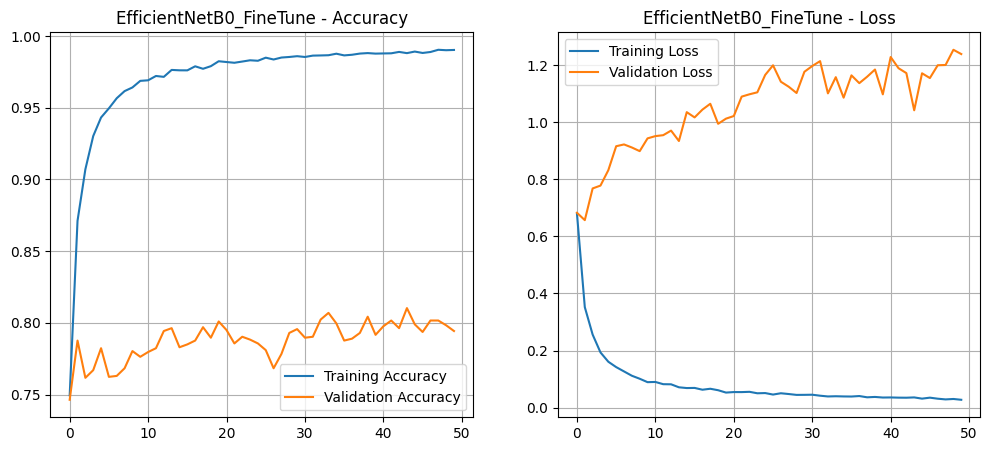


--- Evaluasi Akhir EfficientNetB0_FineTune pada Test Set ---


Testing EfficientNetB0_FineTune: 100%|██████████| 24/24 [00:06<00:00,  3.80it/s]



Classification Report:
              precision    recall  f1-score   support

          nv     0.9078    0.9105    0.9092      1006
         mel     0.5584    0.5150    0.5358       167
         bkl     0.5602    0.6485    0.6011       165
         bcc     0.6250    0.6494    0.6369        77
       akiec     0.6136    0.5510    0.5806        49
        vasc     0.7647    0.5909    0.6667        22
          df     0.7500    0.3529    0.4800        17

    accuracy                         0.8017      1503
   macro avg     0.6828    0.6026    0.6301      1503
weighted avg     0.8029    0.8017    0.8008      1503



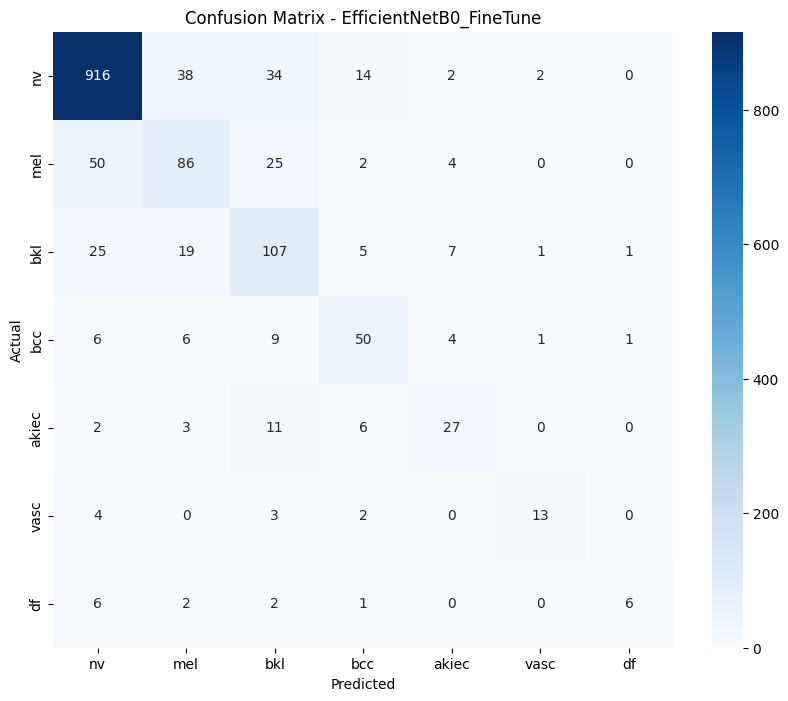

In [ ]:
# EFFICIENTNET-B0 dengan Fine-Tuning
print("\n--- Melatih EfficientNetB0_FineTune ---")
effnet_model_ft = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# freeze semua layer
for param in effnet_model_ft.parameters():
    param.requires_grad = False

# unfreeze 2 blok terakhir (blok 7 dan 8)
for param in effnet_model_ft.features[7].parameters():
    param.requires_grad = True
for param in effnet_model_ft.features[8].parameters():
    param.requires_grad = True

# ganti classifier
num_ftrs = effnet_model_ft.classifier[1].in_features
effnet_model_ft.classifier[1] = nn.Linear(num_ftrs, 7)
effnet_model_ft = effnet_model_ft.to(device)

# optimizer akan melatih blok 7, 8, dan classifier
optimizer_effnet_ft = optim.Adam(effnet_model_ft.parameters(), lr=0.001)

effnet_model_ft, effnet_history_ft = train_and_evaluate(
    effnet_model_ft,
    "EfficientNetB0_FineTune",
    train_loader,
    val_loader,
    criterion,
    optimizer_effnet_ft,
    num_epochs=50
)
plot_history(effnet_history_ft, "EfficientNetB0_FineTune")
effnet_report_ft = evaluate_on_test(effnet_model_ft, test_loader, "EfficientNetB0_FineTune")
results['EfficientNetB0_FineTune'] = effnet_report_ft['accuracy']

Kami mendapatkan akurasi 80.17%.

# **16. Eksperimen 2: Augmentasi Online**

Mempersiapkan skenario augmentasi online di mana transformasi diterapkan secara dinamis (on-the-fly) menggunakan transforms.RandomChoice di dalam DataLoader.

In [ ]:
# Split Data asli dulu (sama seperti metode offline non-leakage)
metadata_online = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))

train_df_online, val_test_df_online = train_test_split(metadata_online, test_size=0.30, random_state=SEED, stratify=metadata_online['dx'])
val_df_online, test_df_online = train_test_split(val_test_df_online, test_size=0.50, random_state=SEED, stratify=val_test_df_online['dx'])

lesion_type_dict = {'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
for df in [train_df_online, val_df_online, test_df_online]:
    df['label'] = df['dx'].map(lesion_type_dict)
    df.dropna(subset=['label'], inplace=True)
    df['label'] = df['label'].astype(int)

In [ ]:
# kita samakaan seperti opsi transformasi di augmentasi offline diatas
train_transforms_online = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomChoice([ # namun dibagian ini akan mejadi random choice
        transforms.RandomRotation(degrees=[15, 15]),    # Rotasi +15 derajat
        transforms.RandomRotation(degrees=[-15, -15]),  # Rotasi -15 derajat
        transforms.RandomRotation(degrees=[45, 45]),    # Rotasi +45 derajat
        transforms.RandomRotation(degrees=[-45, -45]),  # Rotasi -45 derajat
        transforms.RandomRotation(degrees=[0, 0]),      # Opsi untuk tidak merotasi sama sekali
    ]),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Representasi "noise addition"
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


val_test_transforms = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# disini harus buat dataset pointer lagi karena berbeda direktori dengan augmentasi offline
class SimpleHAM10000Dataset(Dataset):
    def __init__(self, df, img_dir, transform):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.image_paths = {os.path.basename(p).replace('.jpg', ''): os.path.join(d, p) for d, _, files in os.walk(img_dir) for p in files if p.endswith('.jpg')}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row['image_id']
        label = row['label']

        img_path = self.image_paths.get(img_id)
        if not img_path:
            return torch.zeros(3, 100, 100), -1

        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        return image, label

In [ ]:
train_dataset_online = SimpleHAM10000Dataset(df=train_df_online, img_dir=data_dir, transform=train_transforms_online)
val_dataset_online = SimpleHAM10000Dataset(df=val_df_online, img_dir=data_dir, transform=val_test_transforms)
test_dataset_online = SimpleHAM10000Dataset(df=test_df_online, img_dir=data_dir, transform=val_test_transforms)

train_loader_online = DataLoader(train_dataset_online, batch_size=batch_size, num_workers=2)
val_loader_online = DataLoader(val_dataset_online, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_online = DataLoader(test_dataset_online, batch_size=batch_size, shuffle=False, num_workers=2)

Melatih semua arsitektur (CNN Baseline, CNN V2, ResNet50, DenseNet121, EfficientNetB0) menggunakan metode augmentasi online.

## **16.1. CNN Baseline Online**

--- Memulai Pelatihan Model: CNN_Online_Sampler ---


Epoch 1/50 | Train Loss: 1.0633 Acc: 0.6635 | Val Loss: 0.9194 Acc: 0.6698
  > Model terbaik disimpan -> CNN_Online_Sampler.pth (Val Acc: 0.6698)


Epoch 2/50 | Train Loss: 0.9599 Acc: 0.6729 | Val Loss: 0.9251 Acc: 0.6804
  > Model terbaik disimpan -> CNN_Online_Sampler.pth (Val Acc: 0.6804)


Epoch 3/50 | Train Loss: 0.9225 Acc: 0.6793 | Val Loss: 0.8686 Acc: 0.6831
  > Model terbaik disimpan -> CNN_Online_Sampler.pth (Val Acc: 0.6831)


Epoch 4/50 | Train Loss: 0.9161 Acc: 0.6802 | Val Loss: 0.8674 Acc: 0.7091
  > Model terbaik disimpan -> CNN_Online_Sampler.pth (Val Acc: 0.7091)


Epoch 5/50 | Train Loss: 0.9040 Acc: 0.6836 | Val Loss: 0.8653 Acc: 0.7177
  > Model terbaik disimpan -> CNN_Online_Sampler.pth (Val Acc: 0.7177)


Epoch 6/50 | Train Loss: 0.8844 Acc: 0.6932 | Val Loss: 0.8904 Acc: 0.7177


Epoch 7/50 | Train Loss: 0.8828 Acc: 0.6924 | Val Loss: 0.8518 Acc: 0.7104


Epoch 8/50 | Train Loss: 0.8647 Acc: 0.6963 | Val Loss: 0.8331 Acc: 0.7057


Epoch 9/50 | Train Loss: 0.8517 Acc: 0.6990 | Val Loss: 0.8155 Acc: 0.7197
  > Model terbaik disimpan -> CNN_Online_Sampler.pth (Val Acc: 0.7197)


Epoch 10/50 | Train Loss: 0.8372 Acc: 0.7043 | Val Loss: 0.8098 Acc: 0.7091


Epoch 11/50 | Train Loss: 0.8256 Acc: 0.7061 | Val Loss: 0.7990 Acc: 0.7210
  > Model terbaik disimpan -> CNN_Online_Sampler.pth (Val Acc: 0.7210)


Epoch 12/50 | Train Loss: 0.8202 Acc: 0.7083 | Val Loss: 0.7762 Acc: 0.7290
  > Model terbaik disimpan -> CNN_Online_Sampler.pth (Val Acc: 0.7290)


Epoch 13/50 | Train Loss: 0.8085 Acc: 0.7113 | Val Loss: 0.7649 Acc: 0.7330
  > Model terbaik disimpan -> CNN_Online_Sampler.pth (Val Acc: 0.7330)


Epoch 14/50 | Train Loss: 0.8019 Acc: 0.7165 | Val Loss: 0.7634 Acc: 0.7390
  > Model terbaik disimpan -> CNN_Online_Sampler.pth (Val Acc: 0.7390)


Epoch 15/50 | Train Loss: 0.7910 Acc: 0.7130 | Val Loss: 0.8018 Acc: 0.7157


Epoch 16/50 | Train Loss: 0.7849 Acc: 0.7150 | Val Loss: 0.7589 Acc: 0.7290


Epoch 17/50 | Train Loss: 0.7825 Acc: 0.7207 | Val Loss: 0.7690 Acc: 0.7330


Epoch 18/50 | Train Loss: 0.7757 Acc: 0.7248 | Val Loss: 0.7665 Acc: 0.7217


Epoch 19/50 | Train Loss: 0.7561 Acc: 0.7210 | Val Loss: 0.7585 Acc: 0.7410
  > Model terbaik disimpan -> CNN_Online_Sampler.pth (Val Acc: 0.7410)


Epoch 20/50 | Train Loss: 0.7622 Acc: 0.7235 | Val Loss: 0.7426 Acc: 0.7383


Epoch 21/50 | Train Loss: 0.7569 Acc: 0.7268 | Val Loss: 0.7387 Acc: 0.7330


Epoch 22/50 | Train Loss: 0.7514 Acc: 0.7301 | Val Loss: 0.7586 Acc: 0.7317


Epoch 23/50 | Train Loss: 0.7432 Acc: 0.7301 | Val Loss: 0.7371 Acc: 0.7490
  > Model terbaik disimpan -> CNN_Online_Sampler.pth (Val Acc: 0.7490)


Epoch 24/50 | Train Loss: 0.7481 Acc: 0.7300 | Val Loss: 0.7474 Acc: 0.7390


Epoch 25/50 | Train Loss: 0.7381 Acc: 0.7294 | Val Loss: 0.7147 Acc: 0.7430


Epoch 26/50 | Train Loss: 0.7310 Acc: 0.7337 | Val Loss: 0.7433 Acc: 0.7397


Epoch 27/50 | Train Loss: 0.7332 Acc: 0.7344 | Val Loss: 0.7062 Acc: 0.7450


Epoch 28/50 | Train Loss: 0.7276 Acc: 0.7382 | Val Loss: 0.7463 Acc: 0.7450


Epoch 29/50 | Train Loss: 0.7192 Acc: 0.7401 | Val Loss: 0.7425 Acc: 0.7330


Epoch 30/50 | Train Loss: 0.7128 Acc: 0.7388 | Val Loss: 0.7284 Acc: 0.7490


Epoch 31/50 | Train Loss: 0.7238 Acc: 0.7315 | Val Loss: 0.7240 Acc: 0.7510
  > Model terbaik disimpan -> CNN_Online_Sampler.pth (Val Acc: 0.7510)


Epoch 32/50 | Train Loss: 0.7120 Acc: 0.7379 | Val Loss: 0.7674 Acc: 0.7184


Epoch 33/50 | Train Loss: 0.7124 Acc: 0.7402 | Val Loss: 0.7213 Acc: 0.7537
  > Model terbaik disimpan -> CNN_Online_Sampler.pth (Val Acc: 0.7537)


Epoch 34/50 | Train Loss: 0.7110 Acc: 0.7385 | Val Loss: 0.7053 Acc: 0.7563
  > Model terbaik disimpan -> CNN_Online_Sampler.pth (Val Acc: 0.7563)


Epoch 35/50 | Train Loss: 0.7098 Acc: 0.7447 | Val Loss: 0.7177 Acc: 0.7483


Epoch 36/50 | Train Loss: 0.6976 Acc: 0.7509 | Val Loss: 0.7169 Acc: 0.7537


Epoch 37/50 | Train Loss: 0.6923 Acc: 0.7468 | Val Loss: 0.6926 Acc: 0.7523


Epoch 38/50 | Train Loss: 0.6899 Acc: 0.7492 | Val Loss: 0.7297 Acc: 0.7423


Epoch 39/50 | Train Loss: 0.6807 Acc: 0.7531 | Val Loss: 0.7025 Acc: 0.7477


Epoch 40/50 | Train Loss: 0.6928 Acc: 0.7499 | Val Loss: 0.7221 Acc: 0.7430


Epoch 41/50 | Train Loss: 0.6809 Acc: 0.7518 | Val Loss: 0.7072 Acc: 0.7497


Epoch 42/50 | Train Loss: 0.6825 Acc: 0.7566 | Val Loss: 0.7593 Acc: 0.7310


Epoch 43/50 | Train Loss: 0.6667 Acc: 0.7549 | Val Loss: 0.7325 Acc: 0.7403


Epoch 44/50 | Train Loss: 0.6826 Acc: 0.7545 | Val Loss: 0.7194 Acc: 0.7523


Epoch 45/50 | Train Loss: 0.6628 Acc: 0.7582 | Val Loss: 0.6687 Acc: 0.7597
  > Model terbaik disimpan -> CNN_Online_Sampler.pth (Val Acc: 0.7597)


Epoch 46/50 | Train Loss: 0.6627 Acc: 0.7499 | Val Loss: 0.7014 Acc: 0.7630
  > Model terbaik disimpan -> CNN_Online_Sampler.pth (Val Acc: 0.7630)


Epoch 47/50 | Train Loss: 0.6682 Acc: 0.7539 | Val Loss: 0.6821 Acc: 0.7590


Epoch 48/50 | Train Loss: 0.6525 Acc: 0.7608 | Val Loss: 0.7000 Acc: 0.7563


Epoch 49/50 | Train Loss: 0.6498 Acc: 0.7663 | Val Loss: 0.6801 Acc: 0.7696
  > Model terbaik disimpan -> CNN_Online_Sampler.pth (Val Acc: 0.7696)


Epoch 50/50 | Train Loss: 0.6621 Acc: 0.7615 | Val Loss: 0.6943 Acc: 0.7630

Pelatihan Selesai. Akurasi validasi terbaik: 0.7696


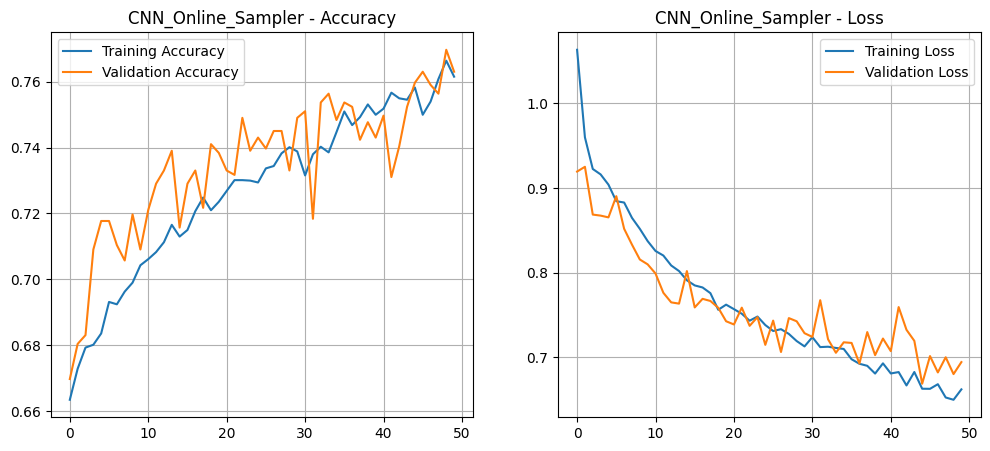


--- Evaluasi Akhir CNN_Online_Sampler pada Test Set ---


Testing CNN_Online_Sampler: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]



Classification Report:
              precision    recall  f1-score   support

          nv     0.8381    0.9105    0.8728      1006
         mel     0.5316    0.2515    0.3415       167
         bkl     0.5573    0.4424    0.4932       165
         bcc     0.4554    0.5974    0.5169        77
       akiec     0.2778    0.5102    0.3597        49
        vasc     1.0000    0.3636    0.5333        22
          df     0.0000    0.0000    0.0000        17

    accuracy                         0.7385      1503
   macro avg     0.5229    0.4394    0.4453      1503
weighted avg     0.7282    0.7385    0.7223      1503



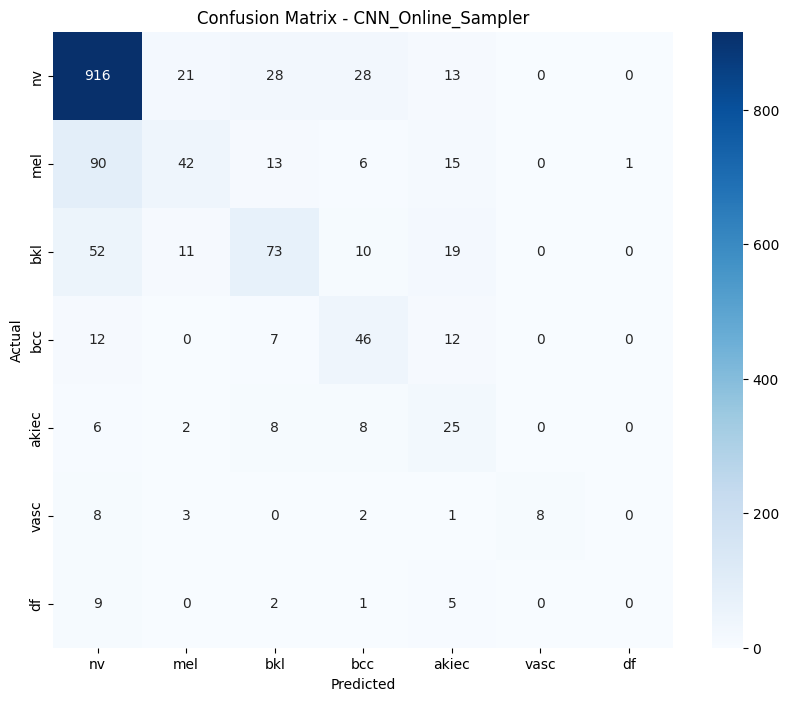

In [ ]:
# CNN BASELINE ONLINE
cnn_online_model = OptimizedCNN().to(device)
optimizer_cnn_online = optim.Adam(cnn_online_model.parameters(), lr=0.001)

cnn_online_model, cnn_online_history = train_and_evaluate(
    cnn_online_model,
    "CNN_Online_Sampler",
    train_loader_online,
    val_loader_online,
    criterion,
    optimizer_cnn_online,
    num_epochs=50
)

plot_history(cnn_online_history, "CNN_Online_Sampler")
cnn_online_report = evaluate_on_test(cnn_online_model, test_loader_online, "CNN_Online_Sampler")
results['CNN_Online_Sampler'] = cnn_online_report['accuracy']

## **16.2. CNN V2 Online**

--- Memulai Pelatihan Model: CNNV2_Online_Sampler ---


Epoch 1/50 | Train Loss: 1.0415 Acc: 0.6641 | Val Loss: 0.9517 Acc: 0.6718
  > Model terbaik disimpan -> CNNV2_Online_Sampler.pth (Val Acc: 0.6718)


Epoch 2/50 | Train Loss: 0.9610 Acc: 0.6700 | Val Loss: 0.9692 Acc: 0.6684


Epoch 3/50 | Train Loss: 0.9473 Acc: 0.6718 | Val Loss: 0.8943 Acc: 0.6744
  > Model terbaik disimpan -> CNNV2_Online_Sampler.pth (Val Acc: 0.6744)


Epoch 4/50 | Train Loss: 0.9304 Acc: 0.6756 | Val Loss: 0.8997 Acc: 0.6838
  > Model terbaik disimpan -> CNNV2_Online_Sampler.pth (Val Acc: 0.6838)


Epoch 5/50 | Train Loss: 0.9113 Acc: 0.6789 | Val Loss: 0.8735 Acc: 0.6991
  > Model terbaik disimpan -> CNNV2_Online_Sampler.pth (Val Acc: 0.6991)


Epoch 6/50 | Train Loss: 0.8925 Acc: 0.6807 | Val Loss: 0.8727 Acc: 0.7084
  > Model terbaik disimpan -> CNNV2_Online_Sampler.pth (Val Acc: 0.7084)


Epoch 7/50 | Train Loss: 0.8775 Acc: 0.6867 | Val Loss: 0.8336 Acc: 0.6997


Epoch 8/50 | Train Loss: 0.8616 Acc: 0.6894 | Val Loss: 0.8126 Acc: 0.7031


Epoch 9/50 | Train Loss: 0.8498 Acc: 0.6896 | Val Loss: 0.8178 Acc: 0.7004


Epoch 10/50 | Train Loss: 0.8532 Acc: 0.6922 | Val Loss: 0.8121 Acc: 0.7031


Epoch 11/50 | Train Loss: 0.8406 Acc: 0.6940 | Val Loss: 0.8208 Acc: 0.7097
  > Model terbaik disimpan -> CNNV2_Online_Sampler.pth (Val Acc: 0.7097)


Epoch 12/50 | Train Loss: 0.8301 Acc: 0.6953 | Val Loss: 0.8190 Acc: 0.7124
  > Model terbaik disimpan -> CNNV2_Online_Sampler.pth (Val Acc: 0.7124)


Epoch 13/50 | Train Loss: 0.8331 Acc: 0.6939 | Val Loss: 0.8059 Acc: 0.7210
  > Model terbaik disimpan -> CNNV2_Online_Sampler.pth (Val Acc: 0.7210)


Epoch 14/50 | Train Loss: 0.8187 Acc: 0.7064 | Val Loss: 0.8077 Acc: 0.7144


Epoch 15/50 | Train Loss: 0.8233 Acc: 0.7011 | Val Loss: 0.8079 Acc: 0.7137


Epoch 16/50 | Train Loss: 0.8217 Acc: 0.7010 | Val Loss: 0.8058 Acc: 0.7117


Epoch 17/50 | Train Loss: 0.8061 Acc: 0.7017 | Val Loss: 0.8028 Acc: 0.7190


Epoch 18/50 | Train Loss: 0.8144 Acc: 0.7006 | Val Loss: 0.7842 Acc: 0.7217
  > Model terbaik disimpan -> CNNV2_Online_Sampler.pth (Val Acc: 0.7217)


Epoch 19/50 | Train Loss: 0.8044 Acc: 0.7066 | Val Loss: 0.8187 Acc: 0.7077


Epoch 20/50 | Train Loss: 0.8016 Acc: 0.7101 | Val Loss: 0.7991 Acc: 0.7170


Epoch 21/50 | Train Loss: 0.8003 Acc: 0.7098 | Val Loss: 0.7695 Acc: 0.7197


Epoch 22/50 | Train Loss: 0.8073 Acc: 0.7006 | Val Loss: 0.7715 Acc: 0.7177


Epoch 23/50 | Train Loss: 0.8018 Acc: 0.7093 | Val Loss: 0.7902 Acc: 0.7170


Epoch 24/50 | Train Loss: 0.7995 Acc: 0.7093 | Val Loss: 0.7865 Acc: 0.7184


Epoch 25/50 | Train Loss: 0.7948 Acc: 0.7087 | Val Loss: 0.7927 Acc: 0.7197


Epoch 26/50 | Train Loss: 0.7946 Acc: 0.7086 | Val Loss: 0.8029 Acc: 0.7157


Epoch 27/50 | Train Loss: 0.7917 Acc: 0.7088 | Val Loss: 0.7777 Acc: 0.7277
  > Model terbaik disimpan -> CNNV2_Online_Sampler.pth (Val Acc: 0.7277)


Epoch 28/50 | Train Loss: 0.7942 Acc: 0.7134 | Val Loss: 0.7884 Acc: 0.7237


Epoch 29/50 | Train Loss: 0.7849 Acc: 0.7131 | Val Loss: 0.7576 Acc: 0.7237


Epoch 30/50 | Train Loss: 0.7874 Acc: 0.7140 | Val Loss: 0.7871 Acc: 0.7177


Epoch 31/50 | Train Loss: 0.7800 Acc: 0.7116 | Val Loss: 0.8054 Acc: 0.7144


Epoch 32/50 | Train Loss: 0.7828 Acc: 0.7164 | Val Loss: 0.7409 Acc: 0.7310
  > Model terbaik disimpan -> CNNV2_Online_Sampler.pth (Val Acc: 0.7310)


Epoch 33/50 | Train Loss: 0.7764 Acc: 0.7163 | Val Loss: 0.7788 Acc: 0.7210


Epoch 34/50 | Train Loss: 0.7752 Acc: 0.7140 | Val Loss: 0.7483 Acc: 0.7270


Epoch 35/50 | Train Loss: 0.7715 Acc: 0.7137 | Val Loss: 0.7808 Acc: 0.7277


Epoch 36/50 | Train Loss: 0.7817 Acc: 0.7110 | Val Loss: 0.7644 Acc: 0.7177


Epoch 37/50 | Train Loss: 0.7674 Acc: 0.7180 | Val Loss: 0.7558 Acc: 0.7257


Epoch 38/50 | Train Loss: 0.7570 Acc: 0.7195 | Val Loss: 0.7405 Acc: 0.7284


Epoch 39/50 | Train Loss: 0.7615 Acc: 0.7154 | Val Loss: 0.7676 Acc: 0.7210


Epoch 40/50 | Train Loss: 0.7542 Acc: 0.7185 | Val Loss: 0.7807 Acc: 0.7197


Epoch 41/50 | Train Loss: 0.7587 Acc: 0.7205 | Val Loss: 0.7586 Acc: 0.7184


Epoch 42/50 | Train Loss: 0.7554 Acc: 0.7204 | Val Loss: 0.7285 Acc: 0.7297


Epoch 43/50 | Train Loss: 0.7534 Acc: 0.7190 | Val Loss: 0.7314 Acc: 0.7290


Epoch 44/50 | Train Loss: 0.7521 Acc: 0.7180 | Val Loss: 0.7490 Acc: 0.7244


Epoch 45/50 | Train Loss: 0.7602 Acc: 0.7168 | Val Loss: 0.7662 Acc: 0.7250


Epoch 46/50 | Train Loss: 0.7519 Acc: 0.7164 | Val Loss: 0.7357 Acc: 0.7244


Epoch 47/50 | Train Loss: 0.7451 Acc: 0.7215 | Val Loss: 0.7526 Acc: 0.7250


Epoch 48/50 | Train Loss: 0.7483 Acc: 0.7233 | Val Loss: 0.7359 Acc: 0.7330
  > Model terbaik disimpan -> CNNV2_Online_Sampler.pth (Val Acc: 0.7330)


Epoch 49/50 | Train Loss: 0.7383 Acc: 0.7252 | Val Loss: 0.7497 Acc: 0.7310


Epoch 50/50 | Train Loss: 0.7428 Acc: 0.7233 | Val Loss: 0.7310 Acc: 0.7317

Pelatihan Selesai. Akurasi validasi terbaik: 0.7330


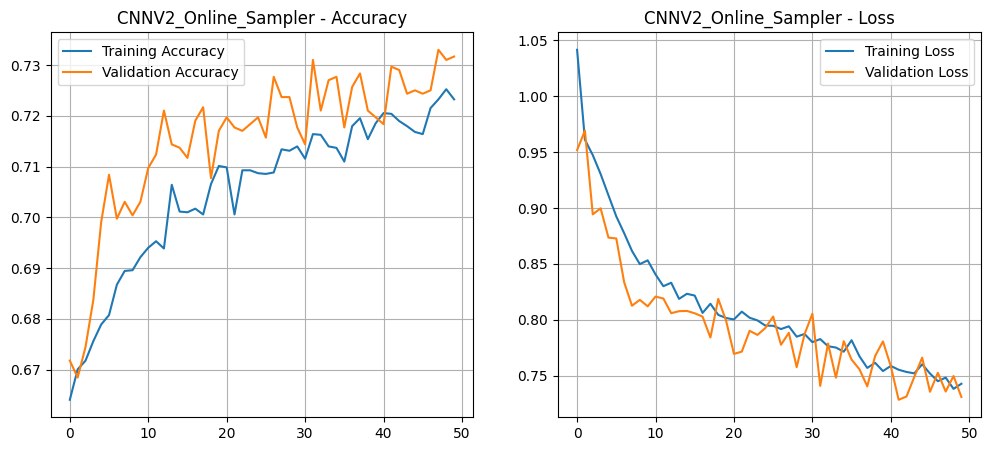


--- Evaluasi Akhir CNNV2_Online_Sampler pada Test Set ---


Testing CNNV2_Online_Sampler: 100%|██████████| 24/24 [00:06<00:00,  3.72it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


Classification Report:
              precision    recall  f1-score   support

          nv     0.7959    0.9304    0.8579      1006
         mel     0.4681    0.1317    0.2056       167
         bkl     0.5268    0.3576    0.4260       165
         bcc     0.4286    0.5065    0.4643        77
       akiec     0.3026    0.4694    0.3680        49
        vasc     1.0000    0.0455    0.0870        22
          df     0.0000    0.0000    0.0000        17

    accuracy                         0.7186      1503
   macro avg     0.5031    0.3487    0.3441      1503
weighted avg     0.6890    0.7186    0.6809      1503



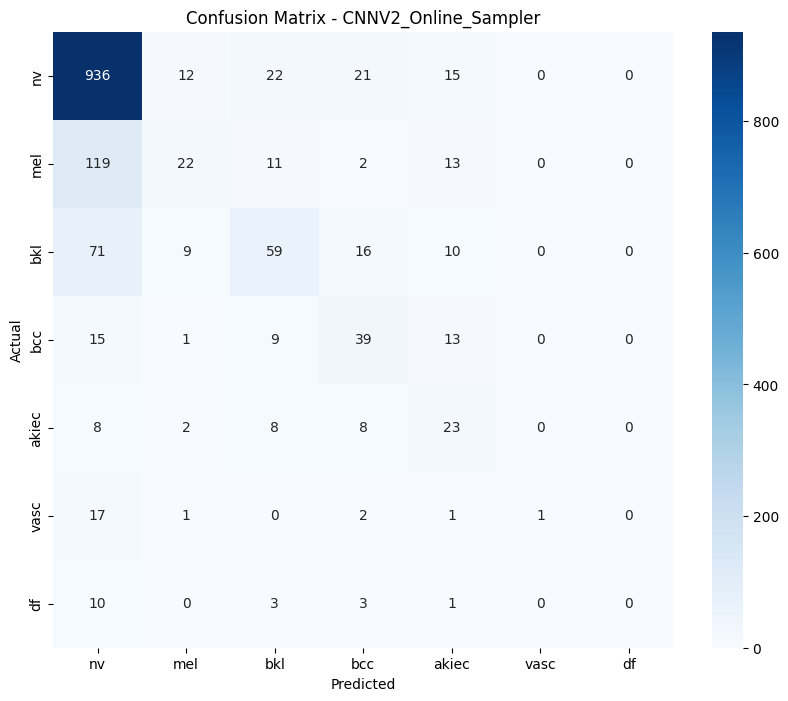

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CNN_V2 BASELINE ONLINE
cnnv2_online_model = OptimizedCNN_V2().to(device)
optimizer_cnnv2_online = optim.Adam(cnnv2_online_model.parameters(), lr=0.001)

cnnv2_online_model, cnnv2_online_history = train_and_evaluate(
    cnnv2_online_model,
    "CNNV2_Online_Sampler",
    train_loader_online,
    val_loader_online,
    criterion,
    optimizer_cnnv2_online,
    num_epochs=50
)

plot_history(cnnv2_online_history, "CNNV2_Online_Sampler")
cnnv2_online_report = evaluate_on_test(cnnv2_online_model, test_loader_online, "CNNV2_Online_Sampler")
results['CNNV2_Online_Sampler'] = cnnv2_online_report['accuracy']

## **16.3. ResNet50 Online**


--- Melatih ResNet50_Online_FineTune ---
--- Memulai Pelatihan Model: ResNet50_Online_FineTune ---


Epoch 1/50 | Train Loss: 0.8134 Acc: 0.7215 | Val Loss: 0.6426 Acc: 0.7590
  > Model terbaik disimpan -> ResNet50_Online_FineTune.pth (Val Acc: 0.7590)


Epoch 2/50 | Train Loss: 0.6123 Acc: 0.7773 | Val Loss: 0.6444 Acc: 0.7650
  > Model terbaik disimpan -> ResNet50_Online_FineTune.pth (Val Acc: 0.7650)


Epoch 3/50 | Train Loss: 0.5378 Acc: 0.8041 | Val Loss: 0.5535 Acc: 0.7943
  > Model terbaik disimpan -> ResNet50_Online_FineTune.pth (Val Acc: 0.7943)


Epoch 4/50 | Train Loss: 0.4701 Acc: 0.8261 | Val Loss: 0.5547 Acc: 0.8003
  > Model terbaik disimpan -> ResNet50_Online_FineTune.pth (Val Acc: 0.8003)


Epoch 5/50 | Train Loss: 0.4423 Acc: 0.8364 | Val Loss: 0.5497 Acc: 0.8063
  > Model terbaik disimpan -> ResNet50_Online_FineTune.pth (Val Acc: 0.8063)


Epoch 6/50 | Train Loss: 0.4000 Acc: 0.8496 | Val Loss: 0.6000 Acc: 0.7936


Epoch 7/50 | Train Loss: 0.3724 Acc: 0.8605 | Val Loss: 0.5589 Acc: 0.7956


Epoch 8/50 | Train Loss: 0.3462 Acc: 0.8709 | Val Loss: 0.5396 Acc: 0.8142
  > Model terbaik disimpan -> ResNet50_Online_FineTune.pth (Val Acc: 0.8142)


Epoch 9/50 | Train Loss: 0.3088 Acc: 0.8887 | Val Loss: 0.5713 Acc: 0.8142


Epoch 10/50 | Train Loss: 0.2948 Acc: 0.8922 | Val Loss: 0.5304 Acc: 0.8169
  > Model terbaik disimpan -> ResNet50_Online_FineTune.pth (Val Acc: 0.8169)


Epoch 11/50 | Train Loss: 0.2796 Acc: 0.8930 | Val Loss: 0.5742 Acc: 0.8182
  > Model terbaik disimpan -> ResNet50_Online_FineTune.pth (Val Acc: 0.8182)


Epoch 12/50 | Train Loss: 0.2425 Acc: 0.9110 | Val Loss: 0.5912 Acc: 0.8196
  > Model terbaik disimpan -> ResNet50_Online_FineTune.pth (Val Acc: 0.8196)


Epoch 13/50 | Train Loss: 0.2449 Acc: 0.9107 | Val Loss: 0.5893 Acc: 0.8289
  > Model terbaik disimpan -> ResNet50_Online_FineTune.pth (Val Acc: 0.8289)


Epoch 14/50 | Train Loss: 0.2150 Acc: 0.9214 | Val Loss: 0.5992 Acc: 0.8196


Epoch 15/50 | Train Loss: 0.2125 Acc: 0.9234 | Val Loss: 0.6558 Acc: 0.8189


Epoch 16/50 | Train Loss: 0.1924 Acc: 0.9298 | Val Loss: 0.6092 Acc: 0.8162


Epoch 17/50 | Train Loss: 0.1904 Acc: 0.9268 | Val Loss: 0.7467 Acc: 0.8162


Epoch 18/50 | Train Loss: 0.1709 Acc: 0.9408 | Val Loss: 0.6838 Acc: 0.8189


Epoch 19/50 | Train Loss: 0.1604 Acc: 0.9435 | Val Loss: 0.7809 Acc: 0.8029


Epoch 20/50 | Train Loss: 0.1605 Acc: 0.9438 | Val Loss: 0.6278 Acc: 0.8356
  > Model terbaik disimpan -> ResNet50_Online_FineTune.pth (Val Acc: 0.8356)


Epoch 21/50 | Train Loss: 0.1469 Acc: 0.9472 | Val Loss: 0.6848 Acc: 0.8216


Epoch 22/50 | Train Loss: 0.1464 Acc: 0.9472 | Val Loss: 0.7208 Acc: 0.8209


Epoch 23/50 | Train Loss: 0.1295 Acc: 0.9545 | Val Loss: 0.7582 Acc: 0.8209


Epoch 24/50 | Train Loss: 0.1280 Acc: 0.9551 | Val Loss: 0.6687 Acc: 0.8336


Epoch 25/50 | Train Loss: 0.1202 Acc: 0.9575 | Val Loss: 0.7022 Acc: 0.8316


Epoch 26/50 | Train Loss: 0.1291 Acc: 0.9559 | Val Loss: 0.7045 Acc: 0.8209


Epoch 27/50 | Train Loss: 0.1048 Acc: 0.9626 | Val Loss: 0.8730 Acc: 0.8222


Epoch 28/50 | Train Loss: 0.1107 Acc: 0.9593 | Val Loss: 0.7067 Acc: 0.8269


Epoch 29/50 | Train Loss: 0.1012 Acc: 0.9660 | Val Loss: 0.7177 Acc: 0.8256


Epoch 30/50 | Train Loss: 0.1074 Acc: 0.9608 | Val Loss: 0.6958 Acc: 0.8356


Epoch 31/50 | Train Loss: 0.0907 Acc: 0.9678 | Val Loss: 0.7429 Acc: 0.8196


Epoch 32/50 | Train Loss: 0.0886 Acc: 0.9679 | Val Loss: 0.7298 Acc: 0.8316


Epoch 33/50 | Train Loss: 0.0796 Acc: 0.9705 | Val Loss: 0.8146 Acc: 0.8362
  > Model terbaik disimpan -> ResNet50_Online_FineTune.pth (Val Acc: 0.8362)


Epoch 34/50 | Train Loss: 0.0852 Acc: 0.9686 | Val Loss: 0.8189 Acc: 0.8229


Epoch 35/50 | Train Loss: 0.0864 Acc: 0.9690 | Val Loss: 0.7861 Acc: 0.8262


Epoch 36/50 | Train Loss: 0.0728 Acc: 0.9736 | Val Loss: 0.8016 Acc: 0.8222


Epoch 37/50 | Train Loss: 0.0749 Acc: 0.9743 | Val Loss: 0.8105 Acc: 0.8236


Epoch 38/50 | Train Loss: 0.0785 Acc: 0.9733 | Val Loss: 0.7704 Acc: 0.8242


Epoch 39/50 | Train Loss: 0.0680 Acc: 0.9776 | Val Loss: 0.7602 Acc: 0.8249


Epoch 40/50 | Train Loss: 0.0759 Acc: 0.9709 | Val Loss: 0.7777 Acc: 0.8269


Epoch 41/50 | Train Loss: 0.0681 Acc: 0.9776 | Val Loss: 0.7819 Acc: 0.8242


Epoch 42/50 | Train Loss: 0.0687 Acc: 0.9773 | Val Loss: 0.8150 Acc: 0.8229


Epoch 43/50 | Train Loss: 0.0640 Acc: 0.9775 | Val Loss: 0.8379 Acc: 0.8262


Epoch 44/50 | Train Loss: 0.0691 Acc: 0.9772 | Val Loss: 0.8088 Acc: 0.8316


Epoch 45/50 | Train Loss: 0.0617 Acc: 0.9766 | Val Loss: 0.8241 Acc: 0.8129


Epoch 46/50 | Train Loss: 0.0656 Acc: 0.9775 | Val Loss: 0.7871 Acc: 0.8269


Epoch 47/50 | Train Loss: 0.0586 Acc: 0.9780 | Val Loss: 0.8000 Acc: 0.8309


Epoch 48/50 | Train Loss: 0.0667 Acc: 0.9780 | Val Loss: 0.8601 Acc: 0.8142


Epoch 49/50 | Train Loss: 0.0548 Acc: 0.9795 | Val Loss: 0.8406 Acc: 0.8169


Epoch 50/50 | Train Loss: 0.0535 Acc: 0.9810 | Val Loss: 0.8751 Acc: 0.8296

Pelatihan Selesai. Akurasi validasi terbaik: 0.8362


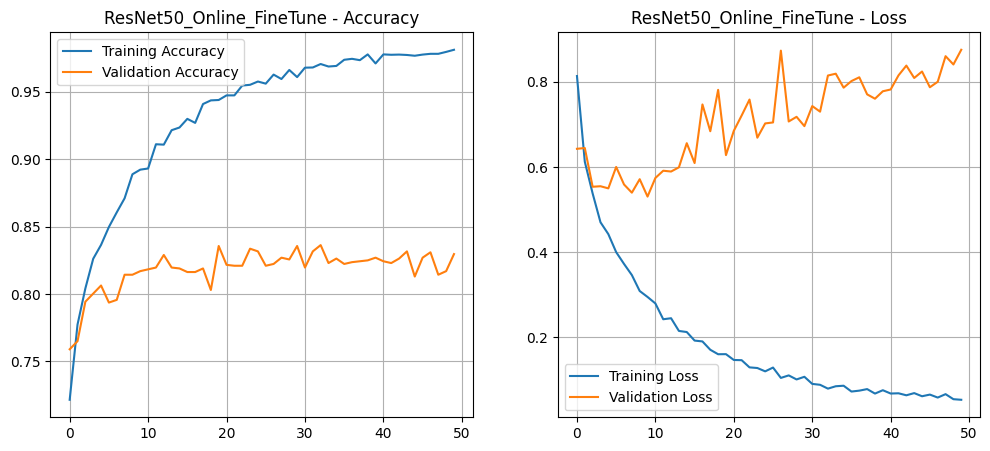


--- Evaluasi Akhir ResNet50_Online_FineTune pada Test Set ---


Testing ResNet50_Online_FineTune: 100%|██████████| 24/24 [00:07<00:00,  3.10it/s]



Classification Report:
              precision    recall  f1-score   support

          nv     0.9044    0.9314    0.9177      1006
         mel     0.6934    0.5689    0.6250       167
         bkl     0.6564    0.6485    0.6524       165
         bcc     0.6556    0.7662    0.7066        77
       akiec     0.5370    0.5918    0.5631        49
        vasc     0.9333    0.6364    0.7568        22
          df     0.8750    0.4118    0.5600        17

    accuracy                         0.8303      1503
   macro avg     0.7507    0.6507    0.6831      1503
weighted avg     0.8291    0.8303    0.8273      1503



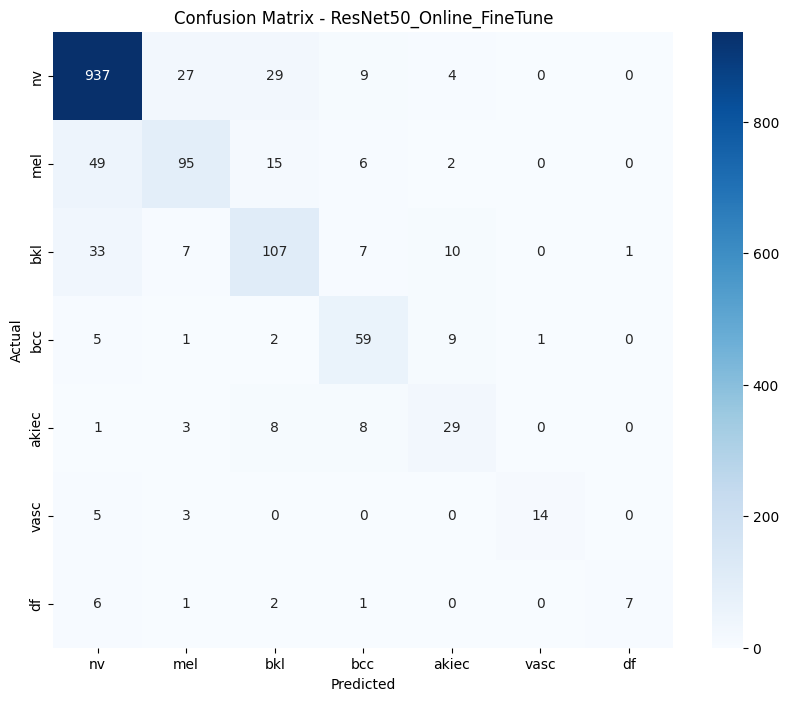

In [ ]:
# RESNET50 Fine-Tuning (Online)
print("\n--- Melatih ResNet50_Online_FineTune ---")
resnet_online_ft = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in resnet_online_ft.parameters(): param.requires_grad = False
for param in resnet_online_ft.layer4.parameters(): param.requires_grad = True
resnet_online_ft.fc = nn.Linear(resnet_online_ft.fc.in_features, 7)
resnet_online_ft = resnet_online_ft.to(device)
optimizer_resnet_online_ft = optim.Adam(resnet_online_ft.parameters(), lr=0.001)

resnet_online_ft, resnet_online_ft_history = train_and_evaluate(
    resnet_online_ft,
    "ResNet50_Online_FineTune",
    train_loader_online,
    val_loader_online,
    criterion,
    optimizer_resnet_online_ft,
    num_epochs=50
)

plot_history(resnet_online_ft_history, "ResNet50_Online_FineTune")
resnet_online_ft_report = evaluate_on_test(resnet_online_ft, test_loader_online, "ResNet50_Online_FineTune")
results['ResNet50_Online_FineTune'] = resnet_online_ft_report['accuracy']

## **16.4. DenseNet121 Online**


--- Melatih DenseNet121_Online_FineTune ---
--- Memulai Pelatihan Model: DenseNet121_Online_FineTune ---


Epoch 1/50 | Train Loss: 0.8124 Acc: 0.7144 | Val Loss: 0.6444 Acc: 0.7597
  > Model terbaik disimpan -> DenseNet121_Online_FineTune.pth (Val Acc: 0.7597)


Epoch 2/50 | Train Loss: 0.6494 Acc: 0.7642 | Val Loss: 0.6238 Acc: 0.7723
  > Model terbaik disimpan -> DenseNet121_Online_FineTune.pth (Val Acc: 0.7723)


Epoch 3/50 | Train Loss: 0.5993 Acc: 0.7775 | Val Loss: 0.6066 Acc: 0.7816
  > Model terbaik disimpan -> DenseNet121_Online_FineTune.pth (Val Acc: 0.7816)


Epoch 4/50 | Train Loss: 0.5612 Acc: 0.7916 | Val Loss: 0.6397 Acc: 0.7776


Epoch 5/50 | Train Loss: 0.5282 Acc: 0.8043 | Val Loss: 0.6060 Acc: 0.7836
  > Model terbaik disimpan -> DenseNet121_Online_FineTune.pth (Val Acc: 0.7836)


Epoch 6/50 | Train Loss: 0.5081 Acc: 0.8100 | Val Loss: 0.6081 Acc: 0.7876
  > Model terbaik disimpan -> DenseNet121_Online_FineTune.pth (Val Acc: 0.7876)


Epoch 7/50 | Train Loss: 0.4771 Acc: 0.8245 | Val Loss: 0.5784 Acc: 0.7943
  > Model terbaik disimpan -> DenseNet121_Online_FineTune.pth (Val Acc: 0.7943)


Epoch 8/50 | Train Loss: 0.4508 Acc: 0.8305 | Val Loss: 0.5863 Acc: 0.8063
  > Model terbaik disimpan -> DenseNet121_Online_FineTune.pth (Val Acc: 0.8063)


Epoch 9/50 | Train Loss: 0.4389 Acc: 0.8342 | Val Loss: 0.6170 Acc: 0.7896


Epoch 10/50 | Train Loss: 0.4080 Acc: 0.8504 | Val Loss: 0.6046 Acc: 0.7989


Epoch 11/50 | Train Loss: 0.4039 Acc: 0.8465 | Val Loss: 0.6462 Acc: 0.7863


Epoch 12/50 | Train Loss: 0.3885 Acc: 0.8479 | Val Loss: 0.6305 Acc: 0.7969


Epoch 13/50 | Train Loss: 0.3653 Acc: 0.8663 | Val Loss: 0.6569 Acc: 0.7916


Epoch 14/50 | Train Loss: 0.3741 Acc: 0.8598 | Val Loss: 0.6357 Acc: 0.8016


Epoch 15/50 | Train Loss: 0.3410 Acc: 0.8736 | Val Loss: 0.6717 Acc: 0.7843


Epoch 16/50 | Train Loss: 0.3444 Acc: 0.8716 | Val Loss: 0.6475 Acc: 0.7996


Epoch 17/50 | Train Loss: 0.3246 Acc: 0.8779 | Val Loss: 0.6682 Acc: 0.7976


Epoch 18/50 | Train Loss: 0.3046 Acc: 0.8857 | Val Loss: 0.6617 Acc: 0.7929


Epoch 19/50 | Train Loss: 0.3118 Acc: 0.8812 | Val Loss: 0.6994 Acc: 0.7896


Epoch 20/50 | Train Loss: 0.2880 Acc: 0.8929 | Val Loss: 0.6541 Acc: 0.8189
  > Model terbaik disimpan -> DenseNet121_Online_FineTune.pth (Val Acc: 0.8189)


Epoch 21/50 | Train Loss: 0.2852 Acc: 0.8899 | Val Loss: 0.6635 Acc: 0.7996


Epoch 22/50 | Train Loss: 0.2712 Acc: 0.8996 | Val Loss: 0.7018 Acc: 0.8116


Epoch 23/50 | Train Loss: 0.2665 Acc: 0.9036 | Val Loss: 0.7161 Acc: 0.7909


Epoch 24/50 | Train Loss: 0.2540 Acc: 0.9046 | Val Loss: 0.7453 Acc: 0.7796


Epoch 25/50 | Train Loss: 0.2453 Acc: 0.9098 | Val Loss: 0.7339 Acc: 0.7983


Epoch 26/50 | Train Loss: 0.2477 Acc: 0.9073 | Val Loss: 0.7805 Acc: 0.7943


Epoch 27/50 | Train Loss: 0.2396 Acc: 0.9134 | Val Loss: 0.7367 Acc: 0.7983


Epoch 28/50 | Train Loss: 0.2412 Acc: 0.9124 | Val Loss: 0.7554 Acc: 0.8003


Epoch 29/50 | Train Loss: 0.2201 Acc: 0.9198 | Val Loss: 0.7772 Acc: 0.8056


Epoch 30/50 | Train Loss: 0.2115 Acc: 0.9231 | Val Loss: 0.7714 Acc: 0.7969


Epoch 31/50 | Train Loss: 0.2156 Acc: 0.9201 | Val Loss: 0.8082 Acc: 0.8149


Epoch 32/50 | Train Loss: 0.1971 Acc: 0.9297 | Val Loss: 0.7841 Acc: 0.8096


Epoch 33/50 | Train Loss: 0.2027 Acc: 0.9241 | Val Loss: 0.8182 Acc: 0.8016


Epoch 34/50 | Train Loss: 0.1942 Acc: 0.9288 | Val Loss: 0.8492 Acc: 0.8056


Epoch 35/50 | Train Loss: 0.1986 Acc: 0.9247 | Val Loss: 0.8403 Acc: 0.7983


Epoch 36/50 | Train Loss: 0.1717 Acc: 0.9381 | Val Loss: 0.7774 Acc: 0.8016


Epoch 37/50 | Train Loss: 0.1826 Acc: 0.9334 | Val Loss: 0.8949 Acc: 0.7956


Epoch 38/50 | Train Loss: 0.1747 Acc: 0.9352 | Val Loss: 0.8480 Acc: 0.8029


Epoch 39/50 | Train Loss: 0.1710 Acc: 0.9368 | Val Loss: 0.8388 Acc: 0.8043


Epoch 40/50 | Train Loss: 0.1670 Acc: 0.9389 | Val Loss: 0.9078 Acc: 0.8036


Epoch 41/50 | Train Loss: 0.1738 Acc: 0.9367 | Val Loss: 0.8483 Acc: 0.7969


Epoch 42/50 | Train Loss: 0.1675 Acc: 0.9432 | Val Loss: 0.8829 Acc: 0.7923


Epoch 43/50 | Train Loss: 0.1629 Acc: 0.9405 | Val Loss: 0.9230 Acc: 0.8076


Epoch 44/50 | Train Loss: 0.1508 Acc: 0.9454 | Val Loss: 0.9389 Acc: 0.7923


Epoch 45/50 | Train Loss: 0.1520 Acc: 0.9471 | Val Loss: 0.8878 Acc: 0.7929


Epoch 46/50 | Train Loss: 0.1636 Acc: 0.9372 | Val Loss: 0.8913 Acc: 0.8036


Epoch 47/50 | Train Loss: 0.1353 Acc: 0.9501 | Val Loss: 0.9756 Acc: 0.7870


Epoch 48/50 | Train Loss: 0.1311 Acc: 0.9558 | Val Loss: 0.9139 Acc: 0.8123


Epoch 49/50 | Train Loss: 0.1530 Acc: 0.9442 | Val Loss: 0.9185 Acc: 0.8096


Epoch 50/50 | Train Loss: 0.1405 Acc: 0.9506 | Val Loss: 0.9633 Acc: 0.8003

Pelatihan Selesai. Akurasi validasi terbaik: 0.8189


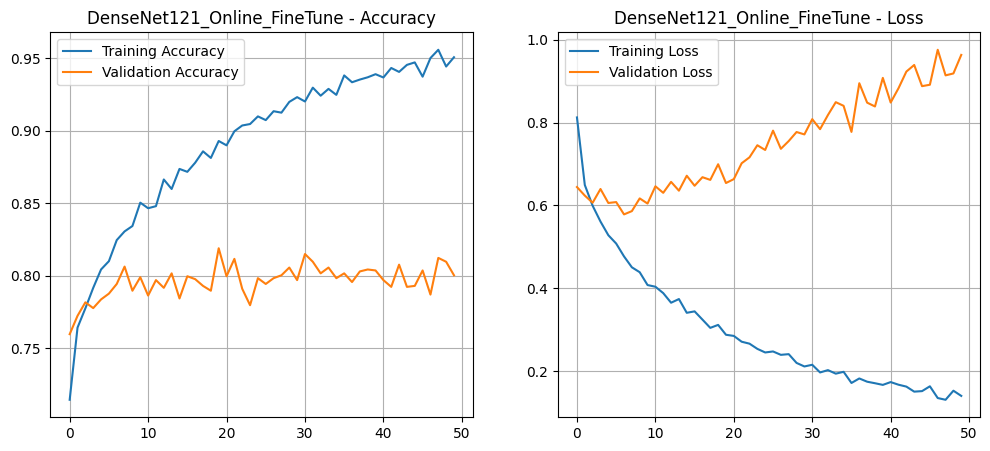


--- Evaluasi Akhir DenseNet121_Online_FineTune pada Test Set ---


Testing DenseNet121_Online_FineTune: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]



Classification Report:
              precision    recall  f1-score   support

          nv     0.8994    0.9155    0.9074      1006
         mel     0.6356    0.4491    0.5263       167
         bkl     0.5706    0.5879    0.5791       165
         bcc     0.5941    0.7792    0.6742        77
       akiec     0.4483    0.5306    0.4860        49
        vasc     0.8500    0.7727    0.8095        22
          df     0.6667    0.4706    0.5517        17

    accuracy                         0.8011      1503
   macro avg     0.6664    0.6437    0.6477      1503
weighted avg     0.8003    0.8011    0.7979      1503



In [ ]:
# DENSENET121 dengan Fine-Tuning (Online)
print("\n--- Melatih DenseNet121_Online_FineTune ---")
densenet_online_ft = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
for param in densenet_online_ft.parameters(): param.requires_grad = False
for param in densenet_online_ft.features.denseblock4.parameters(): param.requires_grad = True
densenet_online_ft.classifier = nn.Linear(densenet_online_ft.classifier.in_features, 7)
densenet_online_ft = densenet_online_ft.to(device)
optimizer_densenet_online_ft = optim.Adam(densenet_online_ft.parameters(), lr=0.001)

densenet_online_ft, densenet_online_ft_history = train_and_evaluate(
    densenet_online_ft, "DenseNet121_Online_FineTune", train_loader_online, val_loader_online,
    criterion, optimizer_densenet_online_ft, num_epochs=50
)

plot_history(densenet_online_ft_history, "DenseNet121_Online_FineTune")
densenet_online_ft_report = evaluate_on_test(densenet_online_ft, test_loader_online, "DenseNet121_Online_FineTune")
results['DenseNet121_Online_FineTune'] = densenet_online_ft_report['accuracy']


## **16.5. EfficientNetB0 Online**

In [ ]:
# Latih EFFICIENTNET-B0 dengan Fine-Tuning (Online)
print("\n--- Melatih EfficientNetB0_Online_FineTune ---")
effnet_online_ft = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
for param in effnet_online_ft.parameters(): param.requires_grad = False
for param in effnet_online_ft.features[7].parameters(): param.requires_grad = True
for param in effnet_online_ft.features[8].parameters(): param.requires_grad = True
effnet_online_ft.classifier[1] = nn.Linear(effnet_online_ft.classifier[1].in_features, 7)
effnet_online_ft = effnet_online_ft.to(device)
optimizer_effnet_online_ft = optim.Adam(effnet_online_ft.parameters(), lr=0.001)

effnet_online_ft, effnet_online_ft_history = train_and_evaluate(
    effnet_online_ft, "EfficientNetB0_Online_FineTune", train_loader_online, val_loader_online,
    criterion, optimizer_effnet_online_ft, num_epochs=50
)

plot_history(effnet_online_ft_history, "EfficientNetB0_Online_FineTune")
effnet_online_ft_report = evaluate_on_test(effnet_online_ft, test_loader_online, "EfficientNetB0_Online_FineTune")
results['EfficientNetB0_Online_FineTune'] = effnet_online_ft_report['accuracy']


--- Melatih EfficientNetB0_Online_FineTune ---
--- Memulai Pelatihan Model: EfficientNetB0_Online_FineTune ---


Epoch 1/50 | Train Loss: 0.9178 Acc: 0.6896 | Val Loss: 0.7636 Acc: 0.7164
  > Model terbaik disimpan -> EfficientNetB0_Online_FineTune.pth (Val Acc: 0.7164)


Epoch 2/50 | Train Loss: 0.7484 Acc: 0.7272 | Val Loss: 0.7471 Acc: 0.7304
  > Model terbaik disimpan -> EfficientNetB0_Online_FineTune.pth (Val Acc: 0.7304)


Epoch 3/50 | Train Loss: 0.7163 Acc: 0.7371 | Val Loss: 0.6923 Acc: 0.7457
  > Model terbaik disimpan -> EfficientNetB0_Online_FineTune.pth (Val Acc: 0.7457)


Epoch 4/50 | Train Loss: 0.6801 Acc: 0.7496 | Val Loss: 0.6732 Acc: 0.7537
  > Model terbaik disimpan -> EfficientNetB0_Online_FineTune.pth (Val Acc: 0.7537)


Epoch 5/50 | Train Loss: 0.6604 Acc: 0.7586 | Val Loss: 0.6656 Acc: 0.7650
  > Model terbaik disimpan -> EfficientNetB0_Online_FineTune.pth (Val Acc: 0.7650)


Epoch 6/50 | Train Loss: 0.6363 Acc: 0.7673 | Val Loss: 0.6657 Acc: 0.7617


Epoch 7/50 | Train Loss: 0.6242 Acc: 0.7733 | Val Loss: 0.6383 Acc: 0.7776
  > Model terbaik disimpan -> EfficientNetB0_Online_FineTune.pth (Val Acc: 0.7776)


Epoch 8/50 | Train Loss: 0.6091 Acc: 0.7718 | Val Loss: 0.6523 Acc: 0.7750


Epoch 9/50 | Train Loss: 0.5921 Acc: 0.7805 | Val Loss: 0.6339 Acc: 0.7676


Epoch 10/50 | Train Loss: 0.5895 Acc: 0.7805 | Val Loss: 0.6452 Acc: 0.7676


Epoch 11/50 | Train Loss: 0.5762 Acc: 0.7872 | Val Loss: 0.6359 Acc: 0.7716


Epoch 12/50 | Train Loss: 0.5678 Acc: 0.7890 | Val Loss: 0.6010 Acc: 0.7870
  > Model terbaik disimpan -> EfficientNetB0_Online_FineTune.pth (Val Acc: 0.7870)


Epoch 13/50 | Train Loss: 0.5601 Acc: 0.7909 | Val Loss: 0.6274 Acc: 0.7756


Epoch 14/50 | Train Loss: 0.5522 Acc: 0.7899 | Val Loss: 0.6381 Acc: 0.7750


Epoch 15/50 | Train Loss: 0.5333 Acc: 0.8043 | Val Loss: 0.6451 Acc: 0.7770


Epoch 16/50 | Train Loss: 0.5218 Acc: 0.8053 | Val Loss: 0.6272 Acc: 0.7816


Epoch 17/50 | Train Loss: 0.5285 Acc: 0.8020 | Val Loss: 0.6374 Acc: 0.7796


Epoch 18/50 | Train Loss: 0.5066 Acc: 0.8117 | Val Loss: 0.6158 Acc: 0.7730


Epoch 19/50 | Train Loss: 0.5247 Acc: 0.8027 | Val Loss: 0.6117 Acc: 0.7756


Epoch 20/50 | Train Loss: 0.5010 Acc: 0.8096 | Val Loss: 0.6116 Acc: 0.7863


Epoch 21/50 | Train Loss: 0.5089 Acc: 0.8124 | Val Loss: 0.6014 Acc: 0.7949
  > Model terbaik disimpan -> EfficientNetB0_Online_FineTune.pth (Val Acc: 0.7949)


Epoch 22/50 | Train Loss: 0.4898 Acc: 0.8200 | Val Loss: 0.6040 Acc: 0.7863


Epoch 23/50 | Train Loss: 0.4810 Acc: 0.8220 | Val Loss: 0.6176 Acc: 0.7863


Epoch 24/50 | Train Loss: 0.4609 Acc: 0.8307 | Val Loss: 0.6461 Acc: 0.7796


Epoch 25/50 | Train Loss: 0.4738 Acc: 0.8267 | Val Loss: 0.6293 Acc: 0.7816


Epoch 26/50 | Train Loss: 0.4478 Acc: 0.8305 | Val Loss: 0.6431 Acc: 0.7776


Epoch 27/50 | Train Loss: 0.4765 Acc: 0.8217 | Val Loss: 0.6147 Acc: 0.7850


Epoch 28/50 | Train Loss: 0.4470 Acc: 0.8361 | Val Loss: 0.6459 Acc: 0.7850


Epoch 29/50 | Train Loss: 0.4479 Acc: 0.8348 | Val Loss: 0.6592 Acc: 0.7790


Epoch 30/50 | Train Loss: 0.4430 Acc: 0.8362 | Val Loss: 0.6619 Acc: 0.7716


Epoch 31/50 | Train Loss: 0.4451 Acc: 0.8328 | Val Loss: 0.6245 Acc: 0.7923


Epoch 32/50 | Train Loss: 0.4274 Acc: 0.8345 | Val Loss: 0.6349 Acc: 0.7883


Epoch 33/50 | Train Loss: 0.4394 Acc: 0.8337 | Val Loss: 0.6502 Acc: 0.7883


Epoch 34/50 | Train Loss: 0.4295 Acc: 0.8438 | Val Loss: 0.6233 Acc: 0.7943


Epoch 35/50 | Train Loss: 0.4266 Acc: 0.8398 | Val Loss: 0.6693 Acc: 0.7776


Epoch 36/50 | Train Loss: 0.4147 Acc: 0.8465 | Val Loss: 0.6211 Acc: 0.7969
  > Model terbaik disimpan -> EfficientNetB0_Online_FineTune.pth (Val Acc: 0.7969)


Epoch 37/50 | Train Loss: 0.4105 Acc: 0.8462 | Val Loss: 0.6331 Acc: 0.7936


Epoch 38/50 | Train Loss: 0.3914 Acc: 0.8511 | Val Loss: 0.6248 Acc: 0.7996
  > Model terbaik disimpan -> EfficientNetB0_Online_FineTune.pth (Val Acc: 0.7996)


Epoch 39/50 | Train Loss: 0.4050 Acc: 0.8494 | Val Loss: 0.6523 Acc: 0.7823


Epoch 40/50 | Train Loss: 0.4071 Acc: 0.8488 | Val Loss: 0.6236 Acc: 0.7876


Epoch 41/50 | Train Loss: 0.3928 Acc: 0.8539 | Val Loss: 0.6480 Acc: 0.7949


Epoch 42/50 | Train Loss: 0.3928 Acc: 0.8556 | Val Loss: 0.6598 Acc: 0.7636


Epoch 43/50 | Train Loss: 0.3878 Acc: 0.8542 | Val Loss: 0.6917 Acc: 0.7783


Epoch 44/50 | Train Loss: 0.3900 Acc: 0.8566 | Val Loss: 0.6627 Acc: 0.7783


Epoch 45/50 | Train Loss: 0.3707 Acc: 0.8598 | Val Loss: 0.6528 Acc: 0.7850


Epoch 46/50 | Train Loss: 0.3766 Acc: 0.8563 | Val Loss: 0.6893 Acc: 0.7830


Epoch 47/50 | Train Loss: 0.3878 Acc: 0.8586 | Val Loss: 0.6597 Acc: 0.7830


Epoch 48/50 | Train Loss: 0.3805 Acc: 0.8575 | Val Loss: 0.6839 Acc: 0.7909


Epoch 49/50 | Train Loss: 0.3643 Acc: 0.8656 | Val Loss: 0.6872 Acc: 0.7843


Epoch 50/50 | Train Loss: 0.3711 Acc: 0.8623 | Val Loss: 0.6982 Acc: 0.7850

Pelatihan Selesai. Akurasi validasi terbaik: 0.7996



--- Evaluasi Akhir EfficientNetB0_Online_FineTune pada Test Set ---


Testing EfficientNetB0_Online_FineTune: 100%|██████████| 24/24 [00:06<00:00,  3.65it/s]



Classification Report:
              precision    recall  f1-score   support

          nv     0.8820    0.9066    0.8941      1006
         mel     0.5125    0.4910    0.5015       167
         bkl     0.5714    0.5333    0.5517       165
         bcc     0.5205    0.4935    0.5067        77
       akiec     0.5000    0.5918    0.5421        49
        vasc     0.7895    0.6818    0.7317        22
          df     0.6000    0.1765    0.2727        17

    accuracy                         0.7764      1503
   macro avg     0.6251    0.5535    0.5715      1503
weighted avg     0.7713    0.7764    0.7722      1503



- ResNet50 Online menjadi yang terbaik di skenario ini dengan akurasi 83.03%, sangat kompetitif dan hanya sedikit di bawah versi offline-nya.

- Model CNN kustom (73.85% dan 71.86%) kembali menunjukkan performa yang jauh di bawah model transfer learning.

# **17. Save Model Terbaik**

Meringkas semua hasil akurasi dari setiap model dalam sebuah dictionary. Kami kemudian secara terprogram menghapus hasil dari model yang tidak valid (CNN_Paper_Method) dan memilih model dengan akurasi tertinggi dari sisa model yang valid.

'*' dibagian ini kita beri nama variabel atau file sebagai chanmpion model karena takut bentrok dengan variabel best model diatas

In [ ]:
print("\n--- Ringkasan Hasil Eksperimen ---")

# menampilkan semua hasil, termasuk yang model replikasi paper
for model_name, acc in results.items():
    print(f"Model: {model_name:<30} | Test Accuracy: {acc:.4f}")

results_valid = results.copy()

# hapus model yang bocor (leaked) dari perbandingan untuk memilih model terbaik yang valid
if 'CNN_Paper_Method' in results_valid:
    print(f"\nMENGHAPUS 'CNN_Paper_Method' (Akurasi: {results['CNN_Paper_Method']:.4f}) dari perbandingan karena data leakage.")
    del results_valid['CNN_Paper_Method']

# cari model terbaik dari sisa model yang valid
if results_valid:
    champion_model_name = max(results_valid, key=results_valid.get)
    print(f"\nModel Terbaik (VALID) adalah: {champion_model_name} dengan akurasi {results_valid[champion_model_name]:.4f}")
else:
    print("\nTidak ada model valid yang tersisa untuk perbandingan.")

--- Ringkasan Hasil Eksperimen ---
Model: CNN_Paper_Method               | Test Accuracy: 0.9139
Model: CNN_Baseline                   | Test Accuracy: 0.7518
Model: CNN_V2_Baseline                | Test Accuracy: 0.7691
Model: ResNet50_FineTune              | Test Accuracy: 0.8436
Model: DenseNet121_FineTune           | Test Accuracy: 0.8170
Model: EfficientNetB0_FineTune        | Test Accuracy: 0.8017
Model: CNN_Online_Sampler             | Test Accuracy: 0.7385
Model: CNNV2_Online_Sampler           | Test Accuracy: 0.7186
Model: ResNet50_Online_FineTune       | Test Accuracy: 0.8303
Model: DenseNet121_Online_FineTune    | Test Accuracy: 0.8011
Model: EfficientNetB0_Online_FineTune | Test Accuracy: 0.7764

MENGHAPUS 'CNN_Paper_Method' (Akurasi: 0.9139) dari perbandingan karena data leakage.

Model Terbaik (VALID) adalah: ResNet50_FineTune dengan akurasi 0.8436


Model ResNet50_FineTune dari skenario augmentasi offline terpilih sebagai model juara dengan akurasi 84.36%. Kami kemudian menyimpan bobot dari model ini ke file champion_model.pth.

In [ ]:
trained_models = {
    # model eksperimen replikasi paper
    "CNN_Paper_Method": cnn_paper_model,

    # model eksperimen 1 (Augmentasi Offline)
    "CNN_Baseline": cnn_model,
    "CNN_V2_Baseline": cnn_v2_model,
    "ResNet50_FineTune": resnet_model_ft,
    "DenseNet121_FineTune": densenet_model_ft,
    "EfficientNetB0_FineTune": effnet_model_ft,

    # model eksperimen 2 (Augmentasi Online)
    "CNN_Online": cnn_online_model,
    "CNNV2_Online": cnnv2_online_model,
    "ResNet50_Online_FineTune": resnet_online_ft,
    "DenseNet121_Online_FineTune": densenet_online_ft,
    "EfficientNetB0_Online_FineTune": effnet_online_ft,
}

if 'champion_model_name' in locals():
    try:
        champion_model_object = trained_models[champion_model_name]

        # path untuk menyimpan model terbaik
        champion_model_save_path = "champion_model.pth"

        # simpan state_dict dari model terbaik
        torch.save(champion_model_object.state_dict(), champion_model_save_path)

        print(f"Model terbaik '{champion_model_name}' telah disimpan di: {champion_model_save_path}")
    except KeyError:
        print(f"ERROR: Nama model juara '{champion_model_name}' tidak ditemukan di dictionary 'trained_models'.")
        print("Pastikan semua nama model konsisten dengan key di dictionary")
else:
    print("Peringatan: Variabel 'champion_model_name' belum didefinisikan. Jalankan sel evaluasi akhir terlebih dahulu.")


Model terbaik 'ResNet50_FineTune' telah disimpan di: champion_model.pth


# **18. The Best Model Explained with Grad-CAM**

Menginterpretasikan model juara kami menggunakan Grad-CAM. Kami memuat kembali model yang telah disimpan, lalu mencari satu contoh gambar dari setiap kelas yang berhasil diprediksi dengan benar. Kemudian, kami menerapkan Grad-CAM untuk menghasilkan heatmap yang menunjukkan area mana pada gambar yang paling berkontribusi pada keputusan model.


Memuat model juara VALID: ResNet50_FineTune.pth untuk Grad-CAM...
Model juara berasal dari Eksperimen 1 (Offline). Menggunakan 'test_loader'.

Mencari contoh prediksi yang benar untuk setiap kelas...


Mencari Sampel:   4%|▍         | 1/24 [00:00<00:15,  1.47it/s]

  > Ditemukan sampel untuk kelas: nv
  > Ditemukan sampel untuk kelas: bkl
  > Ditemukan sampel untuk kelas: mel
  > Ditemukan sampel untuk kelas: bcc
  > Ditemukan sampel untuk kelas: akiec
  > Ditemukan sampel untuk kelas: vasc


Mencari Sampel:  29%|██▉       | 7/24 [00:02<00:05,  3.22it/s]

  > Ditemukan sampel untuk kelas: df


Mencari Sampel:  29%|██▉       | 7/24 [00:02<00:07,  2.37it/s]


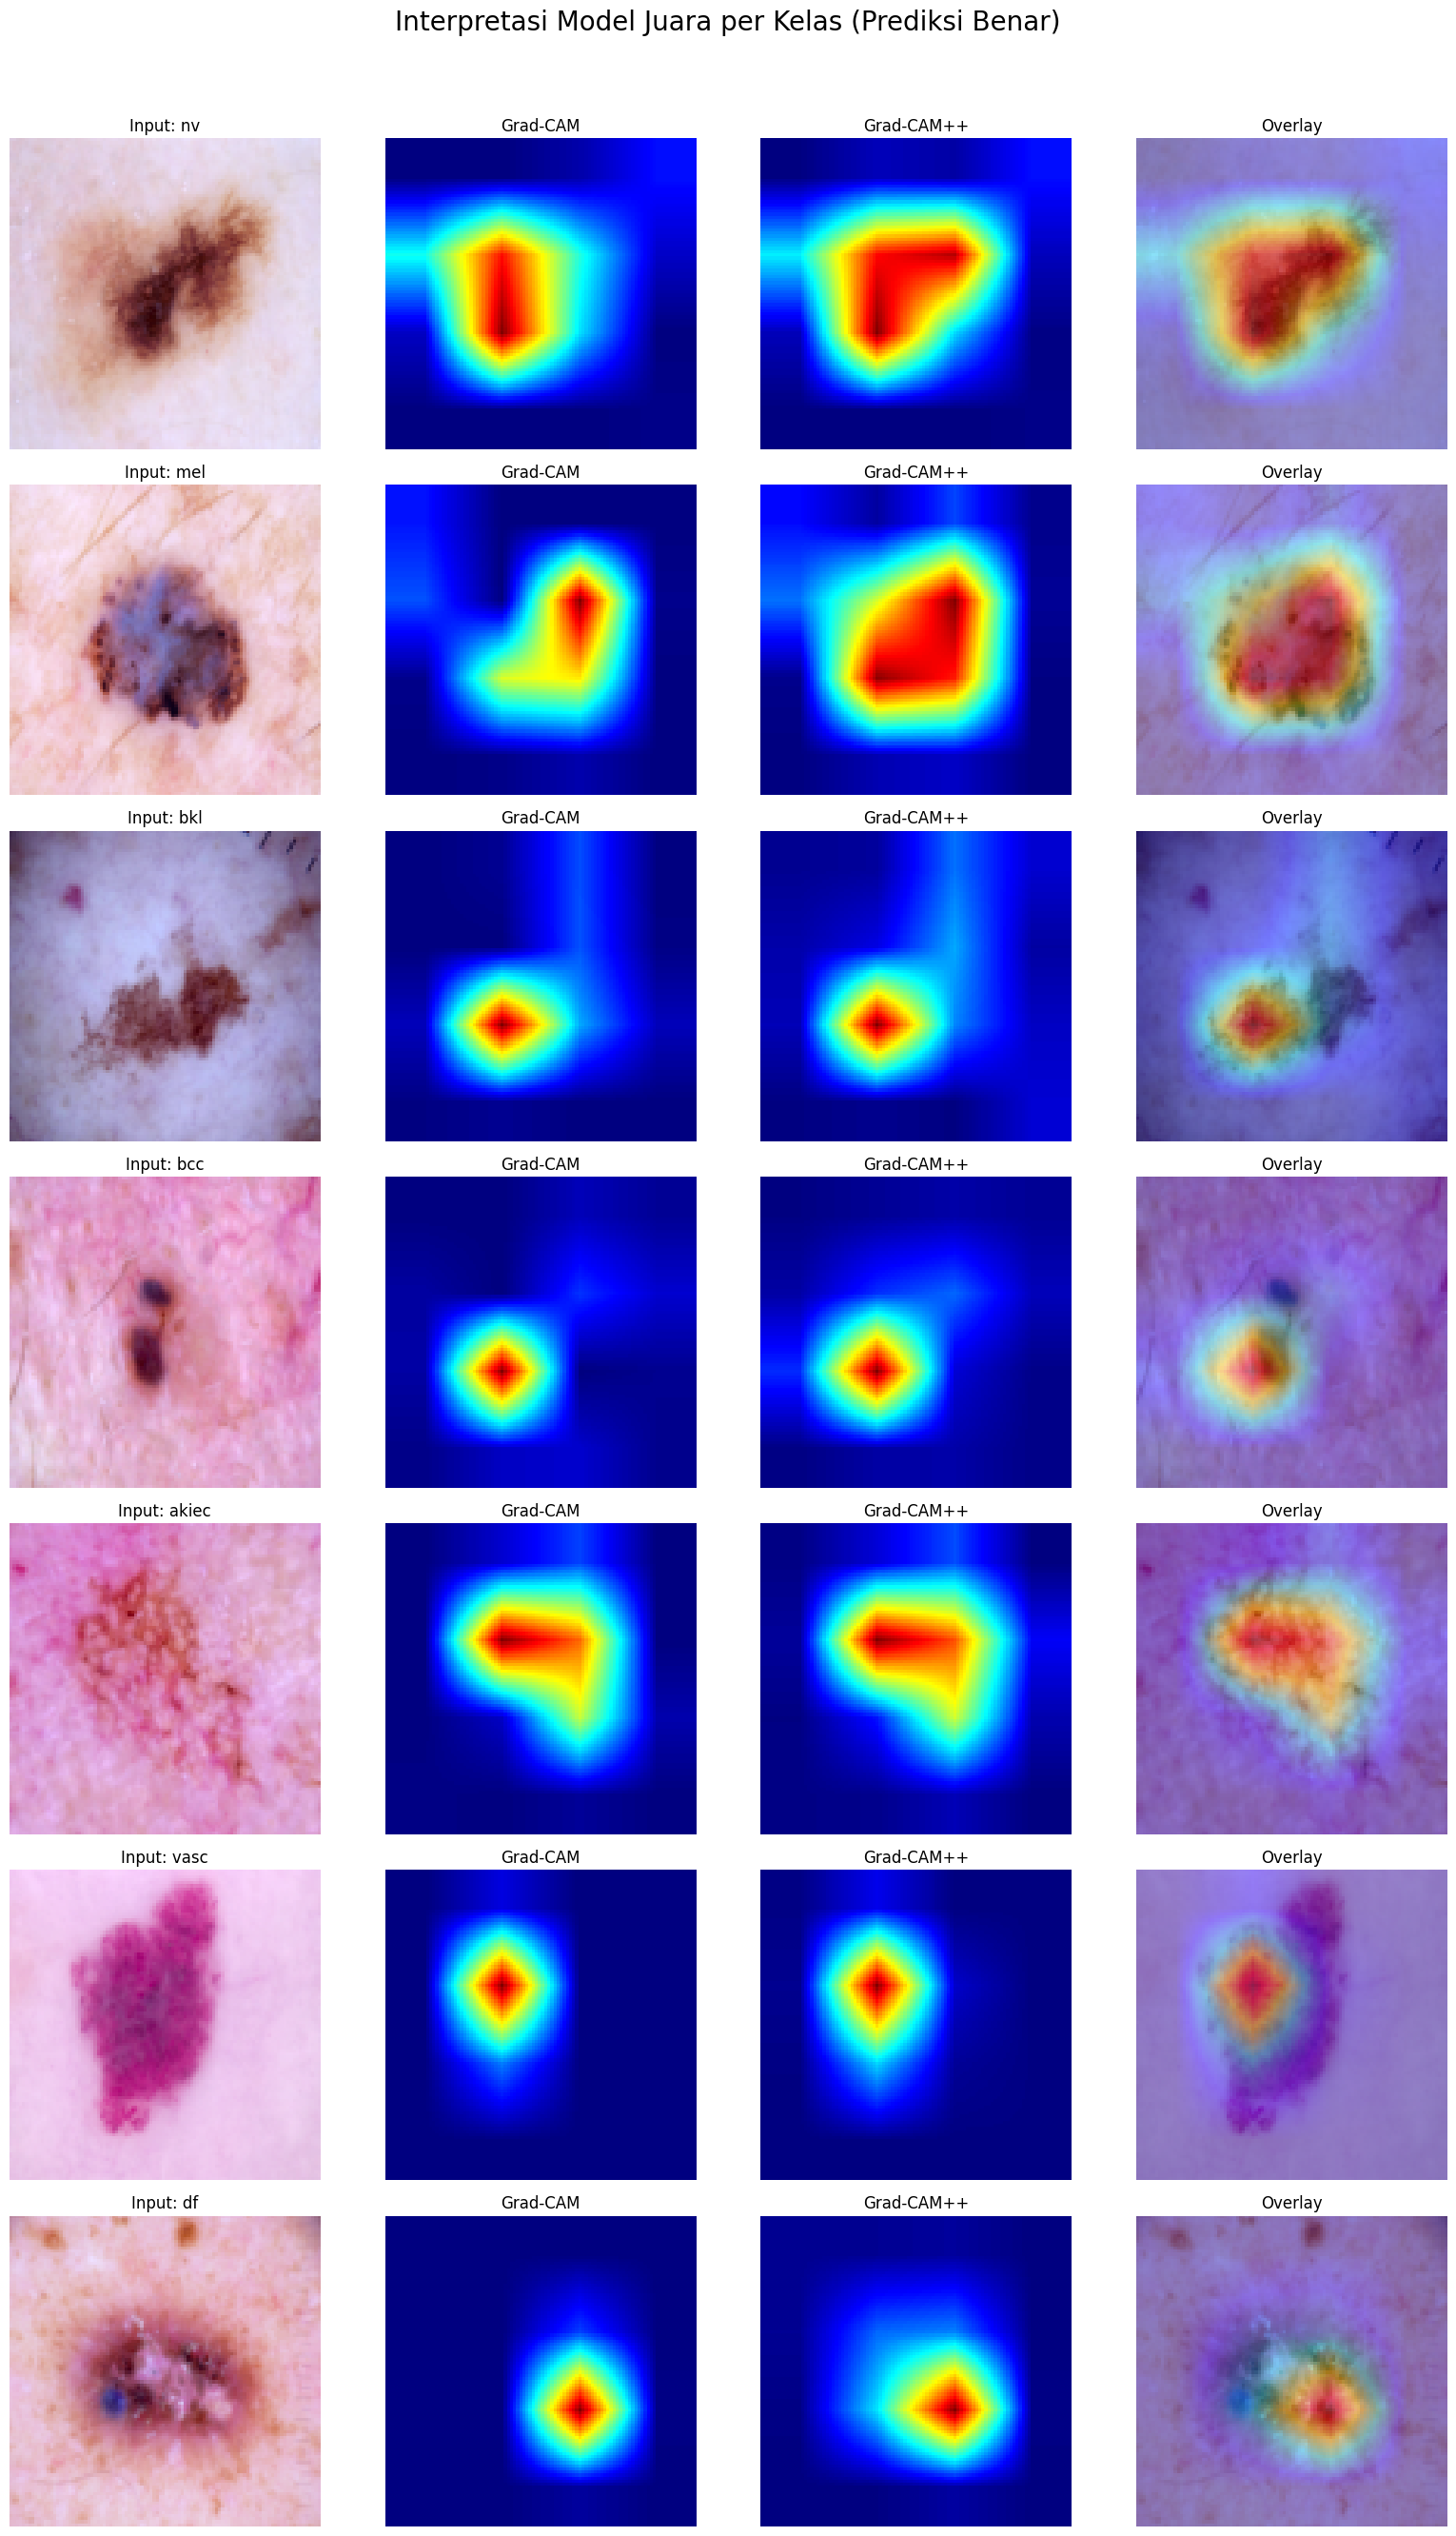

In [ ]:
try:
    # Mendefinisikan kelas GradCAM dan GradCAMPlusPlus
    class GradCAM:
        def __init__(self, model, target_layer):
            self.model = model
            self.target_layer = target_layer
            self.gradients = None
            self.activations = None
            self.model.eval()
            self.hook_layers()

        def hook_layers(self):
            def forward_hook(module, input, output):
                self.activations = output
            def backward_hook(module, grad_in, grad_out):
                self.gradients = grad_out[0]

            self.target_layer.register_forward_hook(forward_hook)
            self.target_layer.register_full_backward_hook(backward_hook)

        def generate_heatmap(self, input_tensor, class_idx=None):
            self.model.zero_grad()
            output = self.model(input_tensor)
            if class_idx is None:
                class_idx = output.argmax(dim=1).item()

            target = output[:, class_idx]
            target.backward()

            pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
            activations = self.activations.detach()

            for i in range(pooled_gradients.shape[0]):
                activations[:, i, :, :] *= pooled_gradients[i]

            heatmap = torch.mean(activations, dim=1).squeeze().cpu()
            heatmap = F.relu(heatmap)
            if torch.max(heatmap) > 0:
                heatmap /= torch.max(heatmap)
            return heatmap.numpy()

    class GradCAMPlusPlus(GradCAM):
        def generate_heatmap(self, input_tensor, class_idx=None):
            self.model.zero_grad()
            output = self.model(input_tensor)
            if class_idx is None:
                class_idx = output.argmax(dim=1).item()

            target = output[:, class_idx]
            target.backward(retain_graph=True)

            gradients = self.gradients.cpu()
            activations = self.activations.cpu()

            alpha_num = gradients.pow(2)
            alpha_denom = 2 * gradients.pow(2) + \
                          torch.sum(activations * gradients.pow(3), dim=(2, 3), keepdim=True)
            alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))

            alpha = alpha_num / alpha_denom
            weights = F.relu(gradients) * alpha
            weights = torch.sum(weights, dim=(2, 3), keepdim=True)

            cam = torch.sum(weights * activations, dim=1).squeeze()

            heatmap = F.relu(cam)
            if torch.max(heatmap) > 0:
                heatmap /= torch.max(heatmap)
            return heatmap.detach().numpy()


    champion_model_path = f"{champion_model_name}.pth"
    print(f"\nMemuat model juara VALID: {champion_model_path} untuk Grad-CAM...")

    # inisialisasi model dan target layer
    if "ResNet" in champion_model_name:
        champion_model = models.resnet50()
        champion_model.fc = nn.Linear(champion_model.fc.in_features, 7)
        champion_model.load_state_dict(torch.load(champion_model_path))
        target_layer = champion_model.layer4[-1]

    elif "DenseNet" in champion_model_name:
        champion_model = models.densenet121()
        champion_model.classifier = nn.Linear(champion_model.classifier.in_features, 7)
        champion_model.load_state_dict(torch.load(champion_model_path))
        target_layer = champion_model.features.denseblock4

    elif "EfficientNet" in champion_model_name:
        champion_model = models.efficientnet_b0()
        num_ftrs = champion_model.classifier[1].in_features
        champion_model.classifier[1] = nn.Linear(num_ftrs, 7)
        champion_model.load_state_dict(torch.load(champion_model_path))
        target_layer = champion_model.features[-1] # <-- Target layer untuk EfficientNet

    else: # CNN Baseline
        champion_model = OptimizedCNN()
        champion_model.load_state_dict(torch.load(champion_model_path))
        target_layer = champion_model.conv4

    champion_model = champion_model.to(device)
    champion_model.eval()

    # inisialisasi Grad-CAM
    grad_cam = GradCAM(champion_model, target_layer)
    grad_cam_plus_plus = GradCAMPlusPlus(champion_model, target_layer)

    def create_visualizations(img_tensor, raw_heatmap):
        img_for_display = img_tensor.permute(1, 2, 0).numpy()
        img_for_display = (img_for_display - img_for_display.min()) / (img_for_display.max() - img_for_display.min())

        smooth_heatmap = cv2.resize(raw_heatmap, (img_for_display.shape[1], img_for_display.shape[0]))
        smooth_heatmap = np.uint8(255 * smooth_heatmap)
        smooth_heatmap_bgr = cv2.applyColorMap(smooth_heatmap, cv2.COLORMAP_JET)

        smooth_heatmap_rgb = cv2.cvtColor(smooth_heatmap_bgr, cv2.COLOR_BGR2RGB)

        smooth_heatmap_float = smooth_heatmap_rgb.astype(float) / 255

        overlay = smooth_heatmap_float * 0.4 + img_for_display * 0.6
        overlay = np.clip(overlay, 0, 1)

        return smooth_heatmap_rgb, overlay

    # perbedaan loading dataset augmentasi offline dan dataset augmentasi online
    if "Online_Sampler" in champion_model_name:
        print("Model juara berasal dari Eksperimen 2 (Online). Menggunakan 'test_loader_online'.")
        loader_for_gradcam = test_loader_online
    else:
        print("Model juara berasal dari Eksperimen 1 (Offline). Menggunakan 'test_loader'.")
        loader_for_gradcam = test_loader

    # menampilkan contoh per kelas yang ditebak benar
    found_samples = {}
    num_classes = 7

    print("\nMencari contoh prediksi yang benar untuk setiap kelas...")
    for images, labels in tqdm(loader_for_gradcam, desc="Mencari Sampel"):
        images, labels = images.to(device), labels.to(device)
        outputs = champion_model(images)
        preds = torch.argmax(outputs, dim=1)

        # periksa setiap gambar dalam batch
        for i in range(len(images)):
            label = labels[i].item()
            pred = preds[i].item()

            # jika prediksi benar dan kelas ini belum ditemukan maka masukan ke sampel yang akan di tampilkan
            if label == pred and label not in found_samples:
                found_samples[label] = images[i].cpu()
                print(f"  > Ditemukan sampel untuk kelas: {class_names[label]}")

        # setelah semua 7 kelas sudah ditemukan, hentikan pencarian
        if len(found_samples) == num_classes:
            break

    # plot
    fig, axs = plt.subplots(num_classes, 4, figsize=(16, 4 * num_classes))
    fig.suptitle("Interpretasi Model Juara per Kelas (Prediksi Benar)", fontsize=20)

    for class_idx in sorted(found_samples.keys()):
        img_tensor = found_samples[class_idx]
        input_tensor = img_tensor.unsqueeze(0).to(device)

        # heatmap mentah (pixelated 4x4, bawaan gradcam)
        raw_heatmap_gc = grad_cam.generate_heatmap(input_tensor, class_idx)
        raw_heatmap_gcpp = grad_cam_plus_plus.generate_heatmap(input_tensor, class_idx)

        # visualisasi halus
        smooth_heatmap_gc, _ = create_visualizations(img_tensor, raw_heatmap_gc)
        smooth_heatmap_gcpp, overlay_gcpp = create_visualizations(img_tensor, raw_heatmap_gcpp)

        # baris yang sesuai untuk plot
        row = class_idx

        # plotting
        original_img_display = img_tensor.permute(1, 2, 0).numpy()
        original_img_display = (original_img_display - original_img_display.min()) / (original_img_display.max() - original_img_display.min())

        axs[row, 0].imshow(original_img_display)
        axs[row, 0].set_title(f"Input: {class_names[class_idx]}")
        axs[row, 0].axis('off')

        axs[row, 1].imshow(smooth_heatmap_gc)
        axs[row, 1].set_title(f"Grad-CAM")
        axs[row, 1].axis('off')

        axs[row, 2].imshow(smooth_heatmap_gcpp)
        axs[row, 2].set_title(f"Grad-CAM++")
        axs[row, 2].axis('off')

        axs[row, 3].imshow(overlay_gcpp)
        axs[row, 3].set_title("Overlay")
        axs[row, 3].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

except ImportError:
    print("\nSkipping Grad-CAM: cv2 (OpenCV) tidak terinstal. Silakan instal dengan `pip install opencv-python-headless`.")
except Exception as e:
    print(f"\nTerjadi error saat menjalankan Grad-CAM: {e}")

Visualisasi yang dihasilkan menunjukkan heatmap yang menyorot area lesi dengan cukup akurat. Ini memberikan kami keyakinan bahwa model kami tidak hanya menebak, tetapi benar-benar telah belajar untuk mengenali fitur-fitur visual yang relevan dari lesi kulit

# **19. Analisis dan Pembahasan**

Dari serangkaian eksperimen yang telah kami lakukan, kami menarik beberapa analisis dan pembahasan kunci,

## **19.1. Implikasi Kritis dari Data Leakage**

Temuan paling signifikan dari proyek kami adalah bukti nyata dampak data leakage. Dengan mereplikasi metodologi paper acuan (augmentasi sebelum split), kami mendapatkan akurasi yang terinflasi secara artifisial sebesar 91.39%. Namun, setelah kami perbaiki metodologinya (split sebelum augmentasi), arsitektur yang sama hanya mampu mencapai 75.18%. Perbedaan drastis sebesar ~16% ini secara jelas menunjukkan bahwa hasil dari paper acuan tidak dapat diandalkan dan menegaskan betapa krusialnya penerapan prosedur validasi yang benar.

## **19.2. Perbandingan Kinerja Arsitektur**

Eksperimen kami secara konsisten menunjukkan bahwa model berbasis transfer learning (ResNet50, DenseNet121, EfficientNetB0) jauh lebih unggul daripada arsitektur CNN kustom yang kami bangun dari awal. Model terbaik kami, ResNet50_FineTune, mencapai akurasi valid 84.36%, sementara CNN kustom terbaik kami hanya mencapai 76.91%. Ini membuktikan bahwa memanfaatkan pengetahuan dari model yang telah dilatih pada dataset besar seperti ImageNet sangat efektif untuk tugas klasifikasi citra medis dengan data terbatas.

## **19.3. Analisis Metode Augmentasi: Offline vs. Online**

Kami menemukan bahwa metode augmentasi offline secara konsisten memberikan hasil yang sedikit lebih baik daripada augmentasi online di semua arsitektur. Sebagai contoh, ResNet50 mencapai 84.36% dengan metode offline, dibandingkan 83.03% dengan metode online. Kami menduga ini karena augmentasi offline menciptakan dataset pelatihan yang lebih besar dan statis sejak awal, yang mungkin memberikan sinyal belajar yang lebih stabil bagi model.

## **19.4. Kendala dan Insight**
Meskipun berhasil mencapai objective, kami mengidentifikasi beberapa tantangan:

1. Ketidakseimbangan Kelas Ekstrem: Model terbaik kami masih kesulitan pada kelas yang sangat minoritas seperti df (Dermatofibroma), di mana tingkat recall-nya hanya 52.94%.

2. Kemiripan Visual: Terdapat kebingungan antara kelas mel (Melanoma) dan bkl (Benign Keratosis), yang mencerminkan tantangan diagnosis di dunia nyata.

3. Interpretasi Model: Dengan menggunakan Grad-CAM, kami dapat memvisualisasikan bahwa model juara kami telah belajar untuk fokus pada area lesi yang relevan, yang meningkatkan kepercayaan kami terhadap hasil yang didapat.

# **20. Kesimpulan**

Berdasarkan seluruh analisis dan eksperimen yang telah kami lakukan, kami dapat menarik beberapa kesimpulan utama:

1. **Arsitektur Terbaik**: ResNet50 terbukti menjadi arsitektur paling unggul di antara model-model yang kami uji untuk tugas klasifikasi kanker kulit ini.

2. **Kombinasi Optimal**: Kombinasi arsitektur ResNet50 dengan strategi augmentasi offline menghasilkan performa terbaik, dengan mencapai akurasi pengujian sebesar 84.36% pada data yang valid.

3. **Validitas Metodologi**: Studi kami berhasil menunjukkan bahwa metodologi yang salah (seperti data leakage) dapat menghasilkan skor akurasi yang terinflasi dan tidak dapat dipercaya. Hasil kami yang lebih rendah namun valid secara metodologis (75.18% vs 91.39%) menyoroti pentingnya prosedur eksperimen yang ketat dalam penelitian machine learning.

# **Reference**

### **Referensi Utama**

1.  **Paper Acuan yang kami Replikasi & Analisis**
    * **Penulis**: K. Mridha, Md. Mezbah Uddin, J. Shin, S. Khadka, and M. F. Mridha
    * [cite_start]**Judul**: An Interpretable Skin Cancer Classification Using Optimized Convolutional Neural Network for a Smart Healthcare System [cite: 4]
    * **Publikasi**: IEEE Access, vol. 11, pp. 41003-41018
    * **Tahun**: 2023
    * **Link**: [https://ieeexplore.ieee.org/document/10107401](https://ieeexplore.ieee.org/document/10107401)



### **Referensi Lainnya**

2.  **Dataset HAM10000**
    * **Penulis**: P. Tschandl, C. Rosendahl, and H. Kittler
    * **Judul**: The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions
    * **Publikasi**: Scientific Data, vol. 5, no. 1, p. 180161
    * **Tahun**: 2018
    * **Link**: [https://www.nature.com/articles/sdata2018161](https://www.nature.com/articles/sdata2018161)

3.  **Batch Normalization (Justifikasi untuk CNN_V2)**
    * **Penulis**: S. Ioffe and C. Szegedy
    * **Judul**: Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
    * **Publikasi**: Proceedings of the 32nd International Conference on Machine Learning (ICML)
    * **Tahun**: 2015
    * **Link**: [https://arxiv.org/abs/1502.03167](https://arxiv.org/abs/1502.03167)

4.  **Global Average Pooling (Justifikasi untuk CNN_V2)**
    * **Penulis**: M. Lin, Q. Chen, and S. Yan
    * **Judul**: Network In Network
    * **Publikasi**: International Conference on Learning Representations (ICLR)
    * **Tahun**: 2014
    * **Link**: [https://arxiv.org/abs/1312.4400](https://arxiv.org/abs/1312.4400)

5.  **ResNet (Arsitektur ResNet50)**
    * **Penulis**: K. He, X. Zhang, S. Ren, and J. Sun
    * **Judul**: Deep Residual Learning for Image Recognition
    * **Publikasi**: 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR)
    * **Tahun**: 2016
    * **Link**: [https://arxiv.org/abs/1512.03385](https://arxiv.org/abs/1512.03385)

6.  **DenseNet (Arsitektur DenseNet121)**
    * **Penulis**: G. Huang, Z. Liu, L. Van Der Maaten, and K. Q. Weinberger
    * **Judul**: Densely Connected Convolutional Networks
    * **Publikasi**: 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR)
    * **Tahun**: 2017
    * **Link**: [https://arxiv.org/abs/1608.06993](https://arxiv.org/abs/1608.06993)

7.  **EfficientNet (Arsitektur EfficientNetB0)**
    * **Penulis**: M. Tan and Q. V. Le
    * **Judul**: EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks
    * **Publikasi**: Proceedings of the 36th International Conference on Machine Learning (ICML)
    * **Tahun**: 2019
    * **Link**: [https://arxiv.org/abs/1905.11946](https://arxiv.org/abs/1905.11946)

8.  **Grad-CAM (Untuk Interpretasi Model)**
    * **Penulis**: R. R. Selvaraju, M. Cogswell, A. Das, R. Vedantam, D. Parikh, and D. Batra
    * [cite_start]**Judul**: Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization [cite: 1141]
    * [cite_start]**Publikasi**: 2017 IEEE International Conference on Computer Vision (ICCV) [cite: 1142]
    * [cite_start]**Tahun**: 2017 [cite: 1142]
    * **Link**: [https://arxiv.org/abs/1610.02391](https://arxiv.org/abs/1610.02391)